In [1]:
from collections import OrderedDict
from time import time
import re
import json
from natsort import natsorted
from glob import glob
from pathlib import Path
import os

import math
from random import random, shuffle, choice

# import pydot
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.drawing.nx_pydot import read_dot

import numpy as np
from scipy.spatial import Delaunay

from matplotlib import collections  as mc
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
from IPython.display import clear_output

nodePattern = re.compile('^(\d+) ')
edgePattern = re.compile('^(\d+) -- (\d+)')
attrsPattern = re.compile('\[(.+)\]')

def isNode(line):
    return '--' not in line


def processAttrs(line):
    attrs = attrsPattern.findall(line)
    if len(attrs) > 0:
        attrs = attrs[0].split(',')
    attrs = [a.split('=') for a in attrs]
    attrs = [[a[0].strip(), a[1].replace('"','').strip()] for a in attrs]
    for a in attrs:
        try:
            a[1] = int(a[1])
        except ValueError:
            try:
                a[1] = float(a[1])
            except:
                pass
    return attrs


def processEdge(line):
    finding = edgePattern.findall(line)[0]
    source, target = finding[:2]
    source, target = int(source), int(target)
    attrs = processAttrs(line)
    return dict(attrs, source=source, target=target)


def processNode(line):
    nodeId = int(line.split(' ')[0])
    nodeAttrs = processAttrs(line)
    return dict(nodeAttrs, id=nodeId)


def draw(g, pos, edges=True, labels=True, figsize=[8,8], s=2, lw=0.5):
    xy = np.array(list([pos[k] for k in g.nodes]))
    fig = plt.figure(figsize=figsize)
    ax = fig.subplots()
    
    ## nodes
    ax.scatter(xy[:,0], xy[:,1], s=s, zorder=3)
    
    ## edges
    if edges:
        lines = [[pos[i], pos[j]] for (i,j) in g.edges]
        lc = mc.LineCollection(lines, colors='grey', linewidths=lw)
        ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
#     plt.axis('equal')

    if labels:
        for i in g.nodes:
            plt.text(pos[i][0], pos[i][1], g.nodes[i]['label'])
    plt.show()

#     plt.figure(figsize=figsize)
#     nx.draw(
#         g, 
#         pos=pos,
#         node_size=10,
#         width=0.5,
#     )




def subtree_sizes(tree, root):
    tree = nx.bfs_tree(g, source=root)
    s = [len(nx.bfs_tree(tree, i).nodes) for i in tree.neighbors(root)]
    total = sum(s)
    return np.array(s)


def fan(nodes, origin=[0,0], radius=1, phaseCenter=0, phaseRange=np.pi, ratio=[1,1]):
    pos = {}
    phases = {}
    ranges = {}
    n = len(nodes)
    cos, sin = np.cos, np.sin
    
    ratioTotal = sum(ratio)
    ratio = [r/ratioTotal for r in ratio]
    
    
    nr = sorted(zip(nodes, ratio), key=lambda x:x[1])
    nr2 = []
    for i in range(len(nr)-1, -1, -1):
        if i%2 == 0:
            nr2.append(nr[i])
        else:
            nr2.insert(0, nr[i])
    nodes, ratio = zip(*nr2)
    
    
    ratioCumSum = [sum(ratio[:i]) for i in range(len(ratio)+1)]
    for i in range(n):
        angle_offset = (ratioCumSum[i]+ratioCumSum[i+1])/2 * phaseRange
        angle_i = phaseCenter - phaseRange/2 + angle_offset
        pos[nodes[i]] = [radius*cos(angle_i), radius*sin(angle_i)]
        phases[nodes[i]] = angle_i
        ranges[nodes[i]] = ratio[i] * phaseRange * 0.95
    return pos, phases, ranges


def radial_layout(g, root=None):
    g0 = g
    g = nx.bfs_tree(g, source=root)
    origin = [0,0]
    pos = {}
    phases = {}
    ranges = {}
    if root is None:
        root = next(iter(g.nodes))
    pos[root] = origin
    phases[root] = 0
    ranges[root] = np.pi*2
#     neighbors = list(g.neighbors(root))
    radius = 0
    roots = [root, ]
    while len(pos) < len(g.nodes):
        radius += 1
        newRoots = []
        for root in roots:
            neighbors = [n for n in g.neighbors(root) if n not in pos]
            subTreeSizes = [len(nx.bfs_tree(g, i).nodes) for i in neighbors]
#             neighborSizes = [len(list(g0.neighbors(i))) for i in neighbors]
            newRoots += neighbors
            if len(neighbors) > 0:
                newPos, newPhases, newRanges = fan(
                    neighbors, 
                    origin, 
                    radius, 
                    phaseCenter=phases[root], 
                    phaseRange=ranges[root], 
                    ratio=subTreeSizes,
                )
                pos.update(newPos)
                phases.update(newPhases)
                ranges.update(newRanges)
        roots = newRoots
    return pos

def normalize(node):
    for prop in node:
        
            
        if prop == 'pos':
            pos = node[prop].replace('"', '')
            pos = pos.split(',')
            pos = [float(pos[0]), float(pos[1])]
            node[prop] = pos
        else:
            if type(node[prop]) == str:
                node[prop] = node[prop].replace('"', '')
                
            try:
                node[prop] = int(node[prop])
            except ValueError:
                try:
                    node[prop] = float(node[prop])
                except ValueError:
                    pass
            except Exception as err:
                print(err)
                print(node, prop)


## Generate a Graph

### Faryad's Google Topics - 5,000 nodes

In [18]:
def edges2graph(lines, i2k=None, label2i=None):
    pattern = re.compile('"(.+)" -- "(.+)"')
    nodes = set()
    edges = set()
    for i,line in enumerate(lines):
        if len(line.strip()) > 0:
            edge = re.findall(pattern, line)[0]
            source, target = edge
            nodes.update([source, target])
            edges.add( (source, target) )
    
    if label2i is None:
        label2i = {k:i for i,k in enumerate(nodes)}
        i2k = list(range(len(nodes)))
    g = nx.Graph()
    
    nodes = [dict(id=label2i[k], label=k) for i,k in enumerate(nodes)]
    ids = [n['id'] for n in nodes]
    g.add_nodes_from( zip(ids, nodes) )
    
    edges = [(i2k[label2i[e[0]]],i2k[label2i[e[1]]]) for e in edges]
    g.add_edges_from(edges)
    return g, i2k, label2i


# fns = natsorted(glob('./data/txt/topics_faryad_500/*.txt'))
fns = natsorted(glob('./data/txt/topics_faryad_5000/*.txt'))#[:4]
fn_level_pairs = list(zip(fns, range(1, len(fns)+1, 1)))
max_level = len(fns)

print(fn_level_pairs[-1])
with open(fns[-1]) as f:
    g, i2k, label2i = edges2graph(f.readlines())
    level = max_level
    for n in g.nodes:
        g.nodes[n]['level'] = level
    for e in g.edges:
        g.edges[e]['level'] = level
        g.edges[e]['weight'] = (max_level - level + 1)*50
        
for fn, level in list(fn_level_pairs)[:-1][::-1]:
    print(fn, level)
    with open(fn) as f:
        subgraph,_,_ = edges2graph(f.readlines(), i2k, label2i)
        for n in subgraph.nodes:
            g.nodes[n]['level'] = level
            
        for e in subgraph.edges:
            g.edges[e]['level'] = level
            g.edges[e]['weight'] = (max_level - level + 1)*50
#             print(e, g.edges[e]['weight'])

fn = fns[-1]

print('all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
d = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = dk[0]
    target_dist = dk[1]
    d[source,:] = [target_dist[i] for i in range(len(g.nodes))]
    
    
# print('k-hop all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
hops = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = dk[0]
    target_dist = dk[1]
    hops[source,:] = [target_dist[i] for i in range(len(g.nodes))]


('./data/txt/topics_faryad_5000/Graph_5000.txt', 14)
./data/txt/topics_faryad_5000/Graph_4500.txt 13
./data/txt/topics_faryad_5000/Graph_4000.txt 12
./data/txt/topics_faryad_5000/Graph_3500.txt 11
./data/txt/topics_faryad_5000/Graph_3000.txt 10
./data/txt/topics_faryad_5000/Graph_2500.txt 9
./data/txt/topics_faryad_5000/Graph_2000.txt 8
./data/txt/topics_faryad_5000/Graph_1600.txt 7
./data/txt/topics_faryad_5000/Graph_1200.txt 6
./data/txt/topics_faryad_5000/Graph_800.txt 5
./data/txt/topics_faryad_5000/Graph_500.txt 4
./data/txt/topics_faryad_5000/Graph_200.txt 3
./data/txt/topics_faryad_5000/Graph_100.txt 2
./data/txt/topics_faryad_5000/Graph_50.txt 1
all_pairs_shortest_path...


### Math Genealogy

In [ ]:

### 67 nodes
fn = './data/txt/math-genealogy/math-67.txt'
# label_to_id = {'K. Müller':66,'A. E. R. Kneschke':22,'B. Karstens':70,'K. E. Stork':35,'W. Fricke':9,'R. C. Straubel':8,'K. Ludwig':49,'W. Lauf':84,'R. Buchweitz':81,'A. K. Holzwarth':24,'O. Mayer':65,'W. von Heygendorff':2,'D. Schuldt':67,'L. Kämmerer':68,'J. Meyer':11,'H. Kessler':12,'G. H. Wannier':30,'V. Hartmann':69,'S. M. geb. Zacharias':56,'A. Hagenbach':3,'L. Neumann':16,'M. Mitchell':83,'M. D. Thomure':91,'E. Oettinger':18,'O. Volk':14,'W. Schorcht':10,'J. Ostwald':0,'M. T. geb. Deutschmann':58,'W. Landecker':89,'H. Tietz':33,'G. Schmieder':82,'K. Heun':6,'M. Krafft':17,'P. Peter':61,'A. Tafelmacher':7,'E. C. G. Stueckelberg':26,'M. Fruth':54,'K. Ebbinghaus':4,'K. J. Thomae':1,'H. Schreiter':51,'G. F. L. Frege':5,'G. Wiarda':19,'M. Cenek':92,'W. Müller':53,'F. W. M. Müller':23,'W. Merten':20,'E. Pippig':71,'P. Katilius':15,'H. Bückner':34,'K. Potthoff':78,'C. Schoen':64,'K. Mätzel':50,'D. Hudak':55,'M. Schoch':52,'H. K. O. Liebmann':13,'K. Neumann':57,'R. Hopsch':60,'G. Stiege':80,'D. R. Hofstadter':32,'D. Tzscharschuch':59,'P. Ghosh':93,'A. Thedy':21,'H. Jäckel':47,'R. Juengling':90,'V. Padervinskas':31,'A. Wolf':25,'E. C. J. Schering':5}
# label_to_id['G. F. L. Frege'] = 999
# id_to_label = {66:'K. Müller',22:'A. E. R. Kneschke',70:'B. Karstens',35:'K. E. Stork',9:'W. Fricke',8:'R. C. Straubel',49:'K. Ludwig',84:'W. Lauf',81:'R. Buchweitz',24:'A. K. Holzwarth',65:'O. Mayer',2:'W. von Heygendorff',67:'D. Schuldt',68:'L. Kämmerer',11:'J. Meyer',12:'H. Kessler',30:'G. H. Wannier',69:'V. Hartmann',56:'S. M. geb. Zacharias',3:'A. Hagenbach',16:'L. Neumann',83:'M. Mitchell',91:'M. D. Thomure',18:'E. Oettinger',14:'O. Volk',10:'W. Schorcht',0:'J. Ostwald',58:'M. T. geb. Deutschmann',89:'W. Landecker',33:'H. Tietz',82:'G. Schmieder',6:'K. Heun',17:'M. Krafft',61:'P. Peter',7:'A. Tafelmacher',26:'E. C. G. Stueckelberg',54:'M. Fruth',4:'K. Ebbinghaus',1:'K. J. Thomae',51:'H. Schreiter',5:'G. F. L. Frege',19:'G. Wiarda',92:'M. Cenek',53:'W. Müller',23:'F. W. M. Müller',20:'W. Merten',71:'E. Pippig',15:'P. Katilius',34:'H. Bückner',78:'K. Potthoff',64:'C. Schoen',50:'K. Mätzel',55:'D. Hudak',52:'M. Schoch',13:'H. K. O. Liebmann',57:'K. Neumann',60:'R. Hopsch',80:'G. Stiege',32:'D. R. Hofstadter',59:'D. Tzscharschuch',93:'P. Ghosh',21:'A. Thedy',47:'H. Jäckel',90:'R. Juengling',31:'V. Padervinskas',25:'A. Wolf',5:'E. C. J. Schering'}
# id_to_label = {v:k for k,v in label_to_id.items()}
my_edges = [['J. Ostwald', 'K. J. Thomae'], ['J. Ostwald', 'W. von Heygendorff'], ['J. Ostwald', 'A. Hagenbach'], ['J. Ostwald', 'K. Ebbinghaus'], ['K. J. Thomae', 'E. C. J. Schering'], ['E. C. J. Schering', 'G. F. L. Frege'], ['E. C. J. Schering', 'K. Heun'], ['E. C. J. Schering', 'A. Tafelmacher'], ['K. J. Thomae', 'R. C. Straubel'], ['R. C. Straubel', 'W. Fricke'], ['R. C. Straubel', 'W. Schorcht'], ['R. C. Straubel', 'J. Meyer'], ['R. C. Straubel', 'H. Kessler'], ['K. J. Thomae', 'H. K. O. Liebmann'], ['H. K. O. Liebmann', 'O. Volk'], ['H. K. O. Liebmann', 'P. Katilius'], ['K. J. Thomae', 'L. Neumann'], ['L. Neumann', 'M. Krafft'], ['L. Neumann', 'E. Oettinger'], ['L. Neumann', 'G. Wiarda'], ['L. Neumann', 'W. Merten'], ['R. C. Straubel', 'A. Thedy'], ['G. Wiarda', 'A. E. R. Kneschke'], ['H. K. O. Liebmann', 'F. W. M. Müller'], ['F. W. M. Müller', 'A. K. Holzwarth'], ['F. W. M. Müller', 'A. Wolf'], ['A. Hagenbach', 'E. C. G. Stueckelberg'], ['E. C. G. Stueckelberg', 'G. H. Wannier'], ['P. Katilius', 'V. Padervinskas'], ['G. H. Wannier', 'D. R. Hofstadter'], ['M. Krafft', 'H. Tietz'], ['M. Krafft', 'H. Bückner'], ['M. Krafft', 'K. E. Stork'], ['A. E. R. Kneschke', 'H. Jäckel'], ['H. Jäckel', 'K. Ludwig'], ['H. Jäckel', 'K. Mätzel'], ['H. Jäckel', 'H. Schreiter'], ['A. E. R. Kneschke', 'M. Schoch'], ['A. E. R. Kneschke', 'W. Müller'], ['K. Ludwig', 'M. Fruth'], ['K. Ludwig', 'D. Hudak'], ['K. Ludwig', 'S. M. geb. Zacharias'], ['K. Ludwig', 'K. Neumann'], ['K. Ludwig', 'M. T. geb. Deutschmann'], ['W. Müller', 'D. Tzscharschuch'], ['W. Müller', 'R. Hopsch'], ['W. Müller', 'P. Peter'], ['K. Neumann', 'C. Schoen'], ['K. Neumann', 'O. Mayer'], ['M. Schoch', 'K. Müller'], ['K. Müller', 'D. Schuldt'], ['K. Neumann', 'L. Kämmerer'], ['H. Schreiter', 'V. Hartmann'], ['H. Schreiter', 'B. Karstens'], ['H. Schreiter', 'E. Pippig'], ['H. Tietz', 'K. Potthoff'], ['H. Tietz', 'R. Buchweitz'], ['H. Tietz', 'G. Schmieder'], ['H. Tietz', 'G. Stiege'], ['D. R. Hofstadter', 'M. Mitchell'], ['G. Schmieder', 'W. Lauf'], ['M. Mitchell', 'W. Landecker'], ['M. Mitchell', 'R. Juengling'], ['M. Mitchell', 'M. D. Thomure'], ['M. Mitchell', 'M. Cenek'], ['M. Mitchell', 'P. Ghosh']]
# edge_distance = {0:50,1:50,2:50,3:50,4:50,5:50,6:50,7:50,8:50,9:50,10:50,11:50,12:50,13:50,14:50,15:50,16:50,17:50,18:50,19:50,20:50,21:50,22:50,23:50,24:50,25:50,26:50,27:50,28:50,29:50,30:50,31:50,32:50,33:50,34:50,35:50,36:50,37:50,38:50,39:50,40:50,41:50,42:50,43:50,44:50,45:50,46:50,47:50,48:50,49:50,50:50,51:50,52:50,53:50,54:50,55:50,56:50,57:50,58:50,59:50,60:50,61:50,62:50,63:50,64:50,65:50,66:50}

### 509 nodes
# fn = './data/txt/math-genealogy/math-509.txt'
# # label_to_id = {'M. Farsi':293,'H. Alblas':229,'B. K. Berntson':411,'N. Joshi':106,'S. Ali':464,'A. A. Smith':220,'S. A. Orszag':105,'S. Dhople':466,'I. Nowosad':252,'Y. Delmas-Rigout':225,'J. A. Mingo':148,'M. B. Barbosa':351,'A. Daszkiewicz':205,'R. Malaka':248,'L. R. Frank':301,'D. Simson':135,'L. Adhikari':436,'W. M. Beaver':388,'J. W. Waters':419,'E. J. Hawkins':334,'J. Engelfriet':192,'X. Wan':21,'U. J. Pape':482,'J. Béziau':217,'A. P. Roberts':97,'C. Riveros':392,'A. T. Patera':170,'N. Azevedo':445,'S. Jaśkowski':1,'T. Marschall':479,'T. Singliar':413,'K. Daynes':231,'Z. W. Ras':129,'M. Benda':139,'A. Duwenig':435,'Z. Błaszczyk':257,'Y. Kuang':177,'K. Świrydowicz':156,'P. Pragacz':204,'A. M. Gelbart':39,'B. Kamiński':132,'H. Kaltenbach':481,'M. G. Main':197,'O. E. O. Uribe':374,'K. H. Chiang':451,'S. Slijepcevic':288,'M. J. Bauer':426,'A. Kwela':347,'W. Guzicki':65,'H. D. Toong':219,'O. Milenkovic':260,'H. Cohen':8,'P. Dowbor':236,'W. Holland':235,'A. D. Domínguez-':185,'D. B. Benson':109,'E. Fritzilas':480,'K. Schmidt':26,'J. Czajsner':52,'J. G. Eichhorn':13,'H. Gadamer':18,'A. Wieczorek':88,'N. Hadjiconstant':277,'A. Manzoni':461,'P. Szolovits':108,'C. Castillo-Chav':127,'P. J. Mucha':173,'H. H. Mostafa':77,'N. T. A. Haydn':285,'J. Tao':467,'L. Rubenfeld':115,'R. J. Deeley':434,'E. Gillaspy':462,'W. M. Jr.':58,'W. S. Song':302,'B. Sobociński':29,'F. C. Hoppenstea':126,'M. A. Martins':209,'G. Morales-Luna':72,'D. Lucor':354,'K. Ajdukiewicz':24,'U. F. Mayer':267,'I. Marusic':387,'S. R. Tuladhar':406,'M. Omyła':2,'T. D. Wu':282,'J. Bazer':59,'J. R. Jiang':145,'S. Waligórski':90,'A. Elyasov':200,'P. Ouwehand':262,'J. Zieleniewski':33,'G. Gripenberg':116,'Y. Yetim':365,'K. Palasinska':206,'M. Mostowski':169,'C. S. Zhu':367,'I. J. Aalbersber':194,'K. Junosza-Szani':247,'A. Dardzinska':216,'A. Ehrenfeucht':67,'S. Balcerzyk':87,'M. Wata':256,'M. C. Smith':186,'K. Hirsch':244,'M. D. Kruskal':57,'T. Kotarbinski':23,'F. Rabe':296,'R. Kannan':312,'M. V. G. Sánchez':318,'D. Q. Mayne':5,'J. Łukasiewicz':21,'A. F. B. C. Leit':398,'M. A. Proschan':162,'B. Stanosz':85,'Ö. Öztürk':270,'F. E. Baginski':168,'F. Echenique':386,'M. Feder':376,'B. Klemp':240,'J. Szymański':243,'P. Bhaduri':198,'A. Rozkosz':307,'E. P. Guentner':326,'F. Ballarin':463,'Y. C. Eldar':375,'B. Ketelboeter':438,'W. G. Aiello':180,'H. C. Sager':158,'J. Li':258,'D. H. Haussler':70,'D. C. Fogg':281,'K. E. Wage':380,'G. Akishev':232,'J. Ko':458,'R. I. Becker':120,'R. S. Finn':78,'E. W. M. Jr.':69,'D. L. Pigozzi':44,'M. Khalkhali':149,'A. Meinong':3,'F. C. Brentano':0,'W. T. Kraśkiewic':203,'T. Klimsiak':396,'C. Ma':191,'J. A. Kułaga-Prz':336,'H. Emerson':329,'C. M. Shannon':13,'L. J. Rotenberg':218,'G. Filè':230,'M. Codescu':295,'A. R. Zinsmeiste':159,'G. E. Karniadaki':22,'D. H. Jacobson':10,'T. Batóg':51,'N. Soja-Kukieła':311,'P. A. Fillmore':81,'S. J. Sherwin':359,'J. Kosakowska':238,'D. Pinheiro':287,'M. Scheepers':181,'I. Liu':405,'L. Dharmarajan':484,'E. A. V. García':319,'J. E. Schindall':41,'A. Grzegorczyk':66,'I. Normann':297,'M. Valko':415,'D. Burkow':315,'M. Moczurad':330,'K. Flores':321,'E. Mally':19,'Z. Pogorzały':245,'K. Adhikari':410,'B. Friedman':37,'L. Rossi':342,'L. S. Borkowski':76,'R. E. Bogner':99,'S. V. Babyonyshe':208,'J. Tryba':478,'R. Suszko':3,'B. Jónsson':48,'H. L. Ewald':5,'M. J. Cresswell':56,'A. Vargas':433,'H. N. Gupta':50,'R. A. Bull':55,'E. I. Su':102,'A. G. Bose':38,'R. G. Halburd':357,'Z. Adamowicz':71,'R. Bubner':27,'C. E. Cherry':43,'H. A. (. H. A. E':15,'G. Hernandez':122,'M. K. Ganai':404,'A. Jakubowski':134,'E. Schrader':16,'E. I. Ettinger':389,'J. A. Ernesti':11,'S. Matwin':130,'N. Eklund':7,'P. E. J. Vos':400,'H. Li':234,'M. J. Coleman':338,'D. Sampson':397,'J. Guaschi':284,'Z. Reznic':450,'M. Zarza':449,'E. T. Bullister':174,'K. J. Compton':141,'P. Seraji':447,'K. Szaniawski':32,'J. Choi':371,'O. Costin':103,'N. D. Santo':472,'E. Sąsiada':86,'M. T. Lemańczyk':254,'F. F. Zadeh':369,'B. E. Cortes':323,'Z. S. Szewczak':308,'G. Pastuszak':409,'G. Sochos':343,'F. Kübler':15,'R. D. Noren':187,'D. A. Hague':408,'P. Jędrzejewicz':250,'M. Mishali':441,'H. L. Planck':14,'J. Duda':332,'F. W. Leysieffer':91,'J. Hage':195,'D. Yen':114,'G. N. S. (. N. P':303,'C. Naturman':261,'H. Jeong':299,'W. Zielonka':155,'C. Mavriplis':276,'D. C. Jensen':68,'J. N. Findlay':28,'C. A. E. Botsari':184,'Y. Psiloyenis':348,'W. Li':379,'W. Bridewell':412,'E. Machery':223,'J. Weyman':202,'J. L. Dias':279,'K. S. Messan':322,'R. I. Goldblatt':164,'H. C. Calvet':166,'F. Yang':352,'G. W. Irwin':151,'S. A. Kasjan':237,'A. Kanigowski':341,'A. Hajduk':292,'G. G. Creamer':382,'R. M. K. Ii':353,'V. Elander':418,'D. A. Pearce':100,'M. Barg':337,'V. K. Sotirov':259,'A. B. Clarke':82,'A. N. Prior':54,'N. Butt':361,'D. J. Brown':4,'K. Reinert':370,'K. Mazur':345,'A. J. Blikle':131,'F. A. Trendelenb':2,'A. Idzik':89,'K. Grygiel':333,'R. Poss':63,'N. J. Korevaar':93,'B. J. Bayly':171,'M. A. (. A. Khan':14,'H. Huang':476,'S. Londen':113,'J. C. Allwright':11,'S. Ahn':264,'S. X. Bai':212,'B. M. Sayers':98,'H. T. Wansing':101,'R. J. Lorentz':196,'T. Bartoszynski':215,'M. Staniszewski':477,'H. Rose':84,'M. E. Frankowska':350,'F. G. Brauer':125,'V. F. Rickey':60,'M. A. D. Torres':274,'S. Malik':143,'J. Waldron':439,'F. Xie':366,'R. F. Marcia':226,'M. Kandulski':154,'F. Durrell':427,'J. Łoś':75,'W. Buszkowski':153,'R. Laudone':471,'K. M. Frączek':335,'R. C. Floricel':278,'T. Mossakowski':294,'P. J. Bankston':140,'R. Vohra':222,'A. W. Nowicki':137,'B. J. S. Blair':381,'M. P. Brannan':273,'T. Song':385,'S. Łuszczewska-R':22,'G. J. Wang':424,'N. Hartmann':10,'D. L. Black':291,'M. Kozak':253,'A. Aziz':146,'L. Dubikajtis':0,'S. M. Wilde':61,'A. Karimi':443,'T. Zalla':224,'C. (. Shilepsky':112,'H. (. Z. Chang':189,'T. Salin':118,'A. Backwell':428,'S. B. Gershwin':182,'D. M. Andler':210,'G. Voutsadakis':207,'Y. Freund':286,'Z. Pawlak':34,'H. S. Aldana':324,'D. J. Navinchand':283,'A. V. Oppenheim':40,'M. J. Schell':161,'S. Shields':422,'J. Kozik':331,'J. Słupecki':30,'A. K. Wiszniewsk':228,'D. R. Gilbert':233,'J. Wesserling':19,'W. M. Getz':183,'N. Wiener':25,'J. Lee':339,'S. G. Campbell':79,'F. D. S. Troncos':316,'C. Ley':390,'V. A. Armentano':201,'P. Dawkins':265,'A. M. Abdel-Mone':160,'W. R. Belding':64,'C. Levasseur':399,'A. Wójtowicz':17,'J. Karłowska-Pik':310,'K. Hannsgen':111,'G. Cui':179,'R. Gandham':431,'P. E. Gill':9,'W. Just':213,'J. Zhai':23,'Z. Zainib':465,'J. R. Buck':378,'P. E. Beckmann':300,'J. Brzykcy':421,'K. Warwick':96,'O. Walsh':188,'J. H. Westcott':6,'R. S. Patil':241,'Y. Ren':383,'M. Hauskrecht':242,'E. H. G. Gutiérr':459,'T. Michaeli':444,'F. W. Galvin':83,'A. Tarski':45,'J. Obrębska':20,'E. V. Erp':327,'L. Szamkołowicz':74,'F. Kraemer':373,'A. Skowroński':239,'S. Bahceci':313,'S. Pagani':475,'D. P. Brown':414,'J. G. Heywood':92,'J. Ratajski':271,'J. Mccuan':95,'Z. Assadi':448,'A. Cortesi':306,'B. M. N. Clarke':12,'M. L. Southcott':221,'L. Chen':393,'M. Vachharajani':364,'M. K. Kemppainen':469,'P. G. Natorp':9,'J. W. Kwiatkowsk':133,'J. D. Bruce':42,'D. Figueiredo':457,'S. Salehi':73,'J. J. Levin':110,'T. Yee':368,'M. Kysiak':344,'Y. Jing':363,'O. M. N. Tapiola':474,'M. Hoelle':432,'J. Hu':104,'V. Padron':123,'M. A. Benedikt':142,'A. Jaworska-Past':360,'B. Jordi':403,'R. A. C. Campos':416,'G. V. V. Zanten':356,'D. D. Grazia':402,'E. R. Zweifel':290,'H. Vu':391,'A. Madeira':452,'S. Rahmann':425,'P. O. Luttighuis':358,'J. C. Preisig':377,'A. Nowik':346,'D. Anderson':227,'P. Berk':423,'F. A. Ongay-Lari':317,'P. K. Ossowski':249,'C. G. Heyne':12,'J. Golińska-Pila':16,'W. Xie':190,'W. Collier':328,'K. Twardowski':1,'E. A. Reckwerdt':395,'G. Mengaldo':401,'S. Banach':20,'R. Brijder':199,'M. Zaionc':163,'D. Lücke':304,'N. D. Higson':147,'T. G. Kecker':407,'T. Józefiak':136,'M. Golasiński':138,'Y. Gu':305,'T. Warburton':355,'R. S. Mackay':107,'I. M. Navon':176,'R. Neves':454,'D. G. Aronson':8,'E. P. Sacks':280,'J. P. F. Teixeir':144,'T. P. Hytönen':117,'G. Rozenberg':128,'T. E. Gelsema':193,'A. J. Lee':417,'T. Serbinowski':268,'M. E. Hafsi':372,'G. L. König':4,'S. R. Dunbar':121,'H. J. (. Keisler':47,'A. Delegge':266,'M. M. Covell':362,'A. Görland':7,'M. M. Sysło':150,'C. B. Harris':325,'E. Cassirer':6,'R. P. Delong':157,'Z. Ben-Haim':442,'J. T. Smith':167,'M. K. Mentzen':255,'D. I. Meiron':172,'N. Levinson':36,'T. S. Hänninen':468,'P. Zakrzewski':214,'G. Chowell':320,'J. Klein':17,'R. K. Brayton':119,'M. Ninčević':429,'A. L. Kairema':473,'K. Sjolander':289,'G. I. Dodds':246,'P. Safari':446,'D. Costa':453,'M. Chen':420,'G. Rozza':275,'J. Zielinski':251,'H. I. Freedman':178,'S. V. Sam':263,'A. Kasperczuk':456,'W. G. Malcolm':165,'C. Jurado':384,'M. Bendkowski':340,'A. M. DallOlio':314,'G. H. Knightly':94,'J. Giedymin':35,'H. F. Becksfort':80,'H. J. Martikaine':470,'T. Puczyłowski':18,'R. E. Montó':211,'A. Alzulaibani':437,'P. Klinga':349,'T. R. Atcheson':430,'P. J. Donohoe':152,'D. Rios-Doria':460,'A. Tarlecki':175,'D. H. Terman':124,'J. T. Canty':62,'A. Mostowski':46,'H. Greniewski':31,'M. Martin':483,'B. R. Musicus':298,'F. H. Farnoud':440,'G. S. Gandenberg':455,'G. Panicker':394,'J. D. Kececioglu':269,'M. Jarosz':53,'F. B. Thompson':49,'C. E. I. Redelme':272,'D. P. Borkowski':309}
# # id_to_label = {293:'M. Farsi',229:'H. Alblas',411:'B. K. Berntson',106:'N. Joshi',464:'S. Ali',220:'A. A. Smith',105:'S. A. Orszag',466:'S. Dhople',252:'I. Nowosad',225:'Y. Delmas-Rigout',148:'J. A. Mingo',351:'M. B. Barbosa',205:'A. Daszkiewicz',248:'R. Malaka',301:'L. R. Frank',135:'D. Simson',436:'L. Adhikari',388:'W. M. Beaver',419:'J. W. Waters',334:'E. J. Hawkins',192:'J. Engelfriet',21:'X. Wan',482:'U. J. Pape',217:'J. Béziau',97:'A. P. Roberts',392:'C. Riveros',170:'A. T. Patera',445:'N. Azevedo',1:'S. Jaśkowski',479:'T. Marschall',413:'T. Singliar',231:'K. Daynes',129:'Z. W. Ras',139:'M. Benda',435:'A. Duwenig',257:'Z. Błaszczyk',177:'Y. Kuang',156:'K. Świrydowicz',204:'P. Pragacz',39:'A. M. Gelbart',132:'B. Kamiński',481:'H. Kaltenbach',197:'M. G. Main',374:'O. E. O. Uribe',451:'K. H. Chiang',288:'S. Slijepcevic',426:'M. J. Bauer',347:'A. Kwela',65:'W. Guzicki',219:'H. D. Toong',260:'O. Milenkovic',8:'H. Cohen',236:'P. Dowbor',235:'W. Holland',185:'A. D. Domínguez-',109:'D. B. Benson',480:'E. Fritzilas',26:'K. Schmidt',52:'J. Czajsner',13:'J. G. Eichhorn',18:'H. Gadamer',88:'A. Wieczorek',277:'N. Hadjiconstant',461:'A. Manzoni',108:'P. Szolovits',127:'C. Castillo-Chav',173:'P. J. Mucha',77:'H. H. Mostafa',285:'N. T. A. Haydn',467:'J. Tao',115:'L. Rubenfeld',434:'R. J. Deeley',462:'E. Gillaspy',58:'W. M. Jr.',302:'W. S. Song',29:'B. Sobociński',126:'F. C. Hoppenstea',209:'M. A. Martins',72:'G. Morales-Luna',354:'D. Lucor',24:'K. Ajdukiewicz',267:'U. F. Mayer',387:'I. Marusic',406:'S. R. Tuladhar',2:'M. Omyła',282:'T. D. Wu',59:'J. Bazer',145:'J. R. Jiang',90:'S. Waligórski',200:'A. Elyasov',262:'P. Ouwehand',33:'J. Zieleniewski',116:'G. Gripenberg',365:'Y. Yetim',206:'K. Palasinska',169:'M. Mostowski',367:'C. S. Zhu',194:'I. J. Aalbersber',247:'K. Junosza-Szani',216:'A. Dardzinska',67:'A. Ehrenfeucht',87:'S. Balcerzyk',256:'M. Wata',186:'M. C. Smith',244:'K. Hirsch',57:'M. D. Kruskal',23:'T. Kotarbinski',296:'F. Rabe',312:'R. Kannan',318:'M. V. G. Sánchez',5:'D. Q. Mayne',21:'J. Łukasiewicz',398:'A. F. B. C. Leit',162:'M. A. Proschan',85:'B. Stanosz',270:'Ö. Öztürk',168:'F. E. Baginski',386:'F. Echenique',376:'M. Feder',240:'B. Klemp',243:'J. Szymański',198:'P. Bhaduri',307:'A. Rozkosz',326:'E. P. Guentner',463:'F. Ballarin',375:'Y. C. Eldar',438:'B. Ketelboeter',180:'W. G. Aiello',158:'H. C. Sager',258:'J. Li',70:'D. H. Haussler',281:'D. C. Fogg',380:'K. E. Wage',232:'G. Akishev',458:'J. Ko',120:'R. I. Becker',78:'R. S. Finn',69:'E. W. M. Jr.',44:'D. L. Pigozzi',149:'M. Khalkhali',3:'A. Meinong',0:'F. C. Brentano',203:'W. T. Kraśkiewic',396:'T. Klimsiak',191:'C. Ma',336:'J. A. Kułaga-Prz',329:'H. Emerson',13:'C. M. Shannon',218:'L. J. Rotenberg',230:'G. Filè',295:'M. Codescu',159:'A. R. Zinsmeiste',22:'G. E. Karniadaki',10:'D. H. Jacobson',51:'T. Batóg',311:'N. Soja-Kukieła',81:'P. A. Fillmore',359:'S. J. Sherwin',238:'J. Kosakowska',287:'D. Pinheiro',181:'M. Scheepers',405:'I. Liu',484:'L. Dharmarajan',319:'E. A. V. García',41:'J. E. Schindall',66:'A. Grzegorczyk',297:'I. Normann',415:'M. Valko',315:'D. Burkow',330:'M. Moczurad',321:'K. Flores',19:'E. Mally',245:'Z. Pogorzały',410:'K. Adhikari',37:'B. Friedman',342:'L. Rossi',76:'L. S. Borkowski',99:'R. E. Bogner',208:'S. V. Babyonyshe',478:'J. Tryba',3:'R. Suszko',48:'B. Jónsson',5:'H. L. Ewald',56:'M. J. Cresswell',433:'A. Vargas',50:'H. N. Gupta',55:'R. A. Bull',102:'E. I. Su',38:'A. G. Bose',357:'R. G. Halburd',71:'Z. Adamowicz',27:'R. Bubner',43:'C. E. Cherry',15:'H. A. (. H. A. E',122:'G. Hernandez',404:'M. K. Ganai',134:'A. Jakubowski',16:'E. Schrader',389:'E. I. Ettinger',11:'J. A. Ernesti',130:'S. Matwin',7:'N. Eklund',400:'P. E. J. Vos',234:'H. Li',338:'M. J. Coleman',397:'D. Sampson',284:'J. Guaschi',450:'Z. Reznic',449:'M. Zarza',174:'E. T. Bullister',141:'K. J. Compton',447:'P. Seraji',32:'K. Szaniawski',371:'J. Choi',103:'O. Costin',472:'N. D. Santo',86:'E. Sąsiada',254:'M. T. Lemańczyk',369:'F. F. Zadeh',323:'B. E. Cortes',308:'Z. S. Szewczak',409:'G. Pastuszak',343:'G. Sochos',15:'F. Kübler',187:'R. D. Noren',408:'D. A. Hague',250:'P. Jędrzejewicz',441:'M. Mishali',14:'H. L. Planck',332:'J. Duda',91:'F. W. Leysieffer',195:'J. Hage',114:'D. Yen',303:'G. N. S. (. N. P',261:'C. Naturman',299:'H. Jeong',155:'W. Zielonka',276:'C. Mavriplis',68:'D. C. Jensen',28:'J. N. Findlay',184:'C. A. E. Botsari',348:'Y. Psiloyenis',379:'W. Li',412:'W. Bridewell',223:'E. Machery',202:'J. Weyman',279:'J. L. Dias',322:'K. S. Messan',164:'R. I. Goldblatt',166:'H. C. Calvet',352:'F. Yang',151:'G. W. Irwin',237:'S. A. Kasjan',341:'A. Kanigowski',292:'A. Hajduk',382:'G. G. Creamer',353:'R. M. K. Ii',418:'V. Elander',100:'D. A. Pearce',337:'M. Barg',259:'V. K. Sotirov',82:'A. B. Clarke',54:'A. N. Prior',361:'N. Butt',4:'D. J. Brown',370:'K. Reinert',345:'K. Mazur',131:'A. J. Blikle',2:'F. A. Trendelenb',89:'A. Idzik',333:'K. Grygiel',63:'R. Poss',93:'N. J. Korevaar',171:'B. J. Bayly',14:'M. A. (. A. Khan',476:'H. Huang',113:'S. Londen',11:'J. C. Allwright',264:'S. Ahn',212:'S. X. Bai',98:'B. M. Sayers',101:'H. T. Wansing',196:'R. J. Lorentz',215:'T. Bartoszynski',477:'M. Staniszewski',84:'H. Rose',350:'M. E. Frankowska',125:'F. G. Brauer',60:'V. F. Rickey',274:'M. A. D. Torres',143:'S. Malik',439:'J. Waldron',366:'F. Xie',226:'R. F. Marcia',154:'M. Kandulski',427:'F. Durrell',75:'J. Łoś',153:'W. Buszkowski',471:'R. Laudone',335:'K. M. Frączek',278:'R. C. Floricel',294:'T. Mossakowski',140:'P. J. Bankston',222:'R. Vohra',137:'A. W. Nowicki',381:'B. J. S. Blair',273:'M. P. Brannan',385:'T. Song',22:'S. Łuszczewska-R',424:'G. J. Wang',10:'N. Hartmann',291:'D. L. Black',253:'M. Kozak',146:'A. Aziz',0:'L. Dubikajtis',61:'S. M. Wilde',443:'A. Karimi',224:'T. Zalla',112:'C. (. Shilepsky',189:'H. (. Z. Chang',118:'T. Salin',428:'A. Backwell',182:'S. B. Gershwin',210:'D. M. Andler',207:'G. Voutsadakis',286:'Y. Freund',34:'Z. Pawlak',324:'H. S. Aldana',283:'D. J. Navinchand',40:'A. V. Oppenheim',161:'M. J. Schell',422:'S. Shields',331:'J. Kozik',30:'J. Słupecki',228:'A. K. Wiszniewsk',233:'D. R. Gilbert',19:'J. Wesserling',183:'W. M. Getz',25:'N. Wiener',339:'J. Lee',79:'S. G. Campbell',316:'F. D. S. Troncos',390:'C. Ley',201:'V. A. Armentano',265:'P. Dawkins',160:'A. M. Abdel-Mone',64:'W. R. Belding',399:'C. Levasseur',17:'A. Wójtowicz',310:'J. Karłowska-Pik',111:'K. Hannsgen',179:'G. Cui',431:'R. Gandham',9:'P. E. Gill',213:'W. Just',23:'J. Zhai',465:'Z. Zainib',378:'J. R. Buck',300:'P. E. Beckmann',421:'J. Brzykcy',96:'K. Warwick',188:'O. Walsh',6:'J. H. Westcott',241:'R. S. Patil',383:'Y. Ren',242:'M. Hauskrecht',459:'E. H. G. Gutiérr',444:'T. Michaeli',83:'F. W. Galvin',45:'A. Tarski',20:'J. Obrębska',327:'E. V. Erp',74:'L. Szamkołowicz',373:'F. Kraemer',239:'A. Skowroński',313:'S. Bahceci',475:'S. Pagani',414:'D. P. Brown',92:'J. G. Heywood',271:'J. Ratajski',95:'J. Mccuan',448:'Z. Assadi',306:'A. Cortesi',12:'B. M. N. Clarke',221:'M. L. Southcott',393:'L. Chen',364:'M. Vachharajani',469:'M. K. Kemppainen',9:'P. G. Natorp',133:'J. W. Kwiatkowsk',42:'J. D. Bruce',457:'D. Figueiredo',73:'S. Salehi',110:'J. J. Levin',368:'T. Yee',344:'M. Kysiak',363:'Y. Jing',474:'O. M. N. Tapiola',432:'M. Hoelle',104:'J. Hu',123:'V. Padron',142:'M. A. Benedikt',360:'A. Jaworska-Past',403:'B. Jordi',416:'R. A. C. Campos',356:'G. V. V. Zanten',402:'D. D. Grazia',290:'E. R. Zweifel',391:'H. Vu',452:'A. Madeira',425:'S. Rahmann',358:'P. O. Luttighuis',377:'J. C. Preisig',346:'A. Nowik',227:'D. Anderson',423:'P. Berk',317:'F. A. Ongay-Lari',249:'P. K. Ossowski',12:'C. G. Heyne',16:'J. Golińska-Pila',190:'W. Xie',328:'W. Collier',1:'K. Twardowski',395:'E. A. Reckwerdt',401:'G. Mengaldo',20:'S. Banach',199:'R. Brijder',163:'M. Zaionc',304:'D. Lücke',147:'N. D. Higson',407:'T. G. Kecker',136:'T. Józefiak',138:'M. Golasiński',305:'Y. Gu',355:'T. Warburton',107:'R. S. Mackay',176:'I. M. Navon',454:'R. Neves',8:'D. G. Aronson',280:'E. P. Sacks',144:'J. P. F. Teixeir',117:'T. P. Hytönen',128:'G. Rozenberg',193:'T. E. Gelsema',417:'A. J. Lee',268:'T. Serbinowski',372:'M. E. Hafsi',4:'G. L. König',121:'S. R. Dunbar',47:'H. J. (. Keisler',266:'A. Delegge',362:'M. M. Covell',7:'A. Görland',150:'M. M. Sysło',325:'C. B. Harris',6:'E. Cassirer',157:'R. P. Delong',442:'Z. Ben-Haim',167:'J. T. Smith',255:'M. K. Mentzen',172:'D. I. Meiron',36:'N. Levinson',468:'T. S. Hänninen',214:'P. Zakrzewski',320:'G. Chowell',17:'J. Klein',119:'R. K. Brayton',429:'M. Ninčević',473:'A. L. Kairema',289:'K. Sjolander',246:'G. I. Dodds',446:'P. Safari',453:'D. Costa',420:'M. Chen',275:'G. Rozza',251:'J. Zielinski',178:'H. I. Freedman',263:'S. V. Sam',456:'A. Kasperczuk',165:'W. G. Malcolm',384:'C. Jurado',340:'M. Bendkowski',314:'A. M. DallOlio',94:'G. H. Knightly',35:'J. Giedymin',80:'H. F. Becksfort',470:'H. J. Martikaine',18:'T. Puczyłowski',211:'R. E. Montó',437:'A. Alzulaibani',349:'P. Klinga',430:'T. R. Atcheson',152:'P. J. Donohoe',460:'D. Rios-Doria',175:'A. Tarlecki',124:'D. H. Terman',62:'J. T. Canty',46:'A. Mostowski',31:'H. Greniewski',483:'M. Martin',298:'B. R. Musicus',440:'F. H. Farnoud',455:'G. S. Gandenberg',394:'G. Panicker',269:'J. D. Kececioglu',53:'M. Jarosz',49:'F. B. Thompson',272:'C. E. I. Redelme',309:'D. P. Borkowski'}
# my_edges = [['F. C. Brentano', 'K. Twardowski'], ['F. C. Brentano', 'F. A. Trendelenb'], ['F. C. Brentano', 'A. Meinong'], ['F. A. Trendelenb', 'G. L. König'], ['F. A. Trendelenb', 'H. Cohen'], ['H. Cohen', 'P. G. Natorp'], ['H. Cohen', 'N. Hartmann'], ['H. Cohen', 'E. Cassirer'], ['G. L. König', 'C. G. Heyne'], ['C. G. Heyne', 'J. G. Eichhorn'], ['J. G. Eichhorn', 'H. L. Planck'], ['H. L. Planck', 'H. A. (. H. A. E'], ['H. A. (. H. A. E', 'E. Schrader'], ['N. Hartmann', 'J. Klein'], ['N. Hartmann', 'H. Gadamer'], ['A. Meinong', 'E. Mally'], ['K. Twardowski', 'S. Banach'], ['K. Twardowski', 'J. Łukasiewicz'], ['K. Twardowski', 'S. Łuszczewska-R'], ['K. Twardowski', 'T. Kotarbinski'], ['K. Twardowski', 'K. Ajdukiewicz'], ['P. G. Natorp', 'A. Görland'], ['P. G. Natorp', 'K. Schmidt'], ['H. Gadamer', 'R. Bubner'], ['E. Mally', 'J. N. Findlay'], ['J. Łukasiewicz', 'B. Sobociński'], ['J. Łukasiewicz', 'J. Słupecki'], ['J. Łukasiewicz', 'S. Jaśkowski'], ['T. Kotarbinski', 'H. Greniewski'], ['T. Kotarbinski', 'K. Szaniawski'], ['T. Kotarbinski', 'J. Zieleniewski'], ['H. Greniewski', 'Z. Pawlak'], ['K. Ajdukiewicz', 'R. Suszko'], ['K. Ajdukiewicz', 'J. Giedymin'], ['S. Łuszczewska-R', 'T. Batóg'], ['S. Łuszczewska-R', 'J. Czajsner'], ['S. Łuszczewska-R', 'M. Jarosz'], ['S. Jaśkowski', 'L. Dubikajtis'], ['J. N. Findlay', 'A. N. Prior'], ['B. Sobociński', 'V. F. Rickey'], ['B. Sobociński', 'S. M. Wilde'], ['B. Sobociński', 'J. T. Canty'], ['B. Sobociński', 'R. Poss'], ['B. Sobociński', 'W. R. Belding'], ['J. Słupecki', 'L. Szamkołowicz'], ['J. Słupecki', 'J. Łoś'], ['J. Słupecki', 'L. S. Borkowski'], ['R. Suszko', 'B. Stanosz'], ['R. Suszko', 'M. Omyła'], ['R. Suszko', 'D. J. Brown'], ['J. Łoś', 'E. Sąsiada'], ['J. Łoś', 'S. Balcerzyk'], ['J. Łoś', 'A. Wieczorek'], ['J. Łoś', 'A. Idzik'], ['J. Giedymin', 'D. A. Pearce'], ['D. A. Pearce', 'E. I. Su'], ['Z. Pawlak', 'G. Rozenberg'], ['Z. Pawlak', 'Z. W. Ras'], ['Z. Pawlak', 'S. Matwin'], ['Z. Pawlak', 'A. J. Blikle'], ['E. Sąsiada', 'B. Kamiński'], ['E. Sąsiada', 'J. W. Kwiatkowsk'], ['E. Sąsiada', 'A. Jakubowski'], ['S. Balcerzyk', 'D. Simson'], ['S. Balcerzyk', 'T. Józefiak'], ['S. Balcerzyk', 'A. W. Nowicki'], ['S. Balcerzyk', 'M. Golasiński'], ['L. Szamkołowicz', 'M. M. Sysło'], ['T. Batóg', 'W. Buszkowski'], ['T. Batóg', 'M. Kandulski'], ['T. Batóg', 'W. Zielonka'], ['T. Batóg', 'K. Świrydowicz'], ['B. Stanosz', 'M. Mostowski'], ['A. J. Blikle', 'A. Tarlecki'], ['G. Rozenberg', 'J. Engelfriet'], ['G. Rozenberg', 'T. E. Gelsema'], ['G. Rozenberg', 'I. J. Aalbersber'], ['G. Rozenberg', 'J. Hage'], ['G. Rozenberg', 'R. Brijder'], ['J. Hage', 'A. Elyasov'], ['T. Józefiak', 'J. Weyman'], ['T. Józefiak', 'W. T. Kraśkiewic'], ['T. Józefiak', 'P. Pragacz'], ['T. Józefiak', 'A. Daszkiewicz'], ['D. J. Brown', 'C. M. Shannon'], ['D. J. Brown', 'M. A. (. A. Khan'], ['D. J. Brown', 'F. Kübler'], ['Z. W. Ras', 'A. Dardzinska'], ['M. Omyła', 'J. Golińska-Pila'], ['M. Omyła', 'A. Wójtowicz'], ['M. Omyła', 'T. Puczyłowski'], ['M. Omyła', 'J. Wesserling'], ['M. Omyła', 'J. Obrębska'], ['M. A. (. A. Khan', 'R. Vohra'], ['A. Wieczorek', 'A. K. Wiszniewsk'], ['J. Engelfriet', 'H. Alblas'], ['J. Engelfriet', 'G. Filè'], ['D. Simson', 'P. Dowbor'], ['D. Simson', 'S. A. Kasjan'], ['D. Simson', 'J. Kosakowska'], ['D. Simson', 'A. Skowroński'], ['D. Simson', 'B. Klemp'], ['B. Kamiński', 'J. Szymański'], ['B. Kamiński', 'K. Hirsch'], ['A. Skowroński', 'Z. Pogorzały'], ['A. Idzik', 'K. Junosza-Szani'], ['A. W. Nowicki', 'P. K. Ossowski'], ['A. W. Nowicki', 'P. Jędrzejewicz'], ['A. W. Nowicki', 'J. Zielinski'], ['A. W. Nowicki', 'I. Nowosad'], ['K. Świrydowicz', 'M. Kozak'], ['J. W. Kwiatkowsk', 'M. T. Lemańczyk'], ['J. W. Kwiatkowsk', 'M. K. Mentzen'], ['J. W. Kwiatkowsk', 'M. Wata'], ['M. Golasiński', 'Z. Błaszczyk'], ['J. Weyman', 'S. V. Sam'], ['P. Pragacz', 'Ö. Öztürk'], ['P. Pragacz', 'J. Ratajski'], ['P. Dowbor', 'A. Hajduk'], ['A. Tarlecki', 'T. Mossakowski'], ['A. Tarlecki', 'M. Codescu'], ['T. Mossakowski', 'F. Rabe'], ['T. Mossakowski', 'I. Normann'], ['T. Mossakowski', 'D. Lücke'], ['G. Filè', 'A. Cortesi'], ['A. Jakubowski', 'A. Rozkosz'], ['A. Jakubowski', 'Z. S. Szewczak'], ['A. Jakubowski', 'D. P. Borkowski'], ['A. Jakubowski', 'J. Karłowska-Pik'], ['A. Jakubowski', 'N. Soja-Kukieła'], ['R. Vohra', 'R. Kannan'], ['R. Vohra', 'S. Bahceci'], ['R. Vohra', "A. M. Dall'Olio"], ['M. T. Lemańczyk', 'K. M. Frączek'], ['M. T. Lemańczyk', 'J. A. Kułaga-Prz'], ['M. T. Lemańczyk', 'A. Kanigowski'], ['H. Alblas', 'G. V. V. Zanten'], ['H. Alblas', 'P. O. Luttighuis'], ['Z. Pogorzały', 'A. Jaworska-Past'], ['C. M. Shannon', 'F. Echenique'], ['A. Rozkosz', 'T. Klimsiak'], ['S. A. Kasjan', 'G. Pastuszak'], ['K. M. Frączek', 'J. Brzykcy'], ['K. M. Frączek', 'P. Berk'], ['F. Kübler', 'M. Hoelle'], ['A. Dardzinska', 'A. Kasperczuk'], ['S. V. Sam', 'R. Laudone'], ['S. V. Sam', 'H. Huang'], ['E. Cassirer', 'H. L. Ewald'], ['C. G. Heyne', 'J. A. Ernesti'], ['A. N. Prior', 'R. A. Bull'], ['D. A. Pearce', 'H. T. Wansing'], ['K. Schmidt', 'N. Wiener'], ['N. Wiener', 'B. Friedman'], ['N. Wiener', 'A. M. Gelbart'], ['N. Wiener', 'C. E. Cherry'], ['A. N. Prior', 'M. J. Cresswell'], ['B. Friedman', 'W. M. Jr.'], ['A. M. Gelbart', 'H. H. Mostafa'], ['A. M. Gelbart', 'S. G. Campbell'], ['C. E. Cherry', 'J. H. Westcott'], ['J. H. Westcott', 'A. P. Roberts'], ['C. E. Cherry', 'B. M. Sayers'], ['A. P. Roberts', 'G. W. Irwin'], ['W. M. Jr.', 'R. P. Delong'], ['M. J. Cresswell', 'R. I. Goldblatt'], ['R. I. Goldblatt', 'K. Daynes'], ['R. I. Goldblatt', 'D. R. Gilbert'], ['G. W. Irwin', 'G. I. Dodds'], ['N. Wiener', 'N. Levinson'], ['B. Friedman', 'M. D. Kruskal'], ['A. M. Gelbart', 'R. S. Finn'], ['R. S. Finn', 'J. G. Heywood'], ['R. S. Finn', 'G. H. Knightly'], ['J. H. Westcott', 'K. Warwick'], ['C. E. Cherry', 'R. E. Bogner'], ['M. D. Kruskal', 'J. Hu'], ['M. D. Kruskal', 'N. Joshi'], ['N. Levinson', 'J. J. Levin'], ['J. J. Levin', 'C. (. Shilepsky'], ['N. Levinson', 'R. K. Brayton'], ['N. Levinson', 'F. G. Brauer'], ['F. G. Brauer', 'C. Castillo-Chav'], ['R. K. Brayton', 'S. Malik'], ['R. K. Brayton', 'J. R. Jiang'], ['A. P. Roberts', 'P. J. Donohoe'], ['M. J. Cresswell', 'W. G. Malcolm'], ['G. H. Knightly', 'F. E. Baginski'], ['J. G. Heywood', 'O. Walsh'], ['J. G. Heywood', 'W. Xie'], ['R. E. Bogner', 'M. L. Southcott'], ['R. I. Goldblatt', 'G. Akishev'], ['K. Warwick', 'M. Farsi'], ['C. Castillo-Chav', 'D. Burkow'], ['C. Castillo-Chav', 'G. Chowell'], ['C. Castillo-Chav', 'K. S. Messan'], ['F. E. Baginski', 'W. Collier'], ['F. E. Baginski', 'M. Barg'], ['F. E. Baginski', 'J. Lee'], ['M. Farsi', 'M. B. Barbosa'], ['N. Joshi', 'R. G. Halburd'], ['D. Burkow', 'Y. Kuang'], ['S. Malik', 'M. Vachharajani'], ['S. Malik', 'F. Xie'], ['J. Hu', 'T. Yee'], ['R. G. Halburd', 'T. G. Kecker'], ['R. G. Halburd', 'B. K. Berntson'], ['J. R. Jiang', 'K. H. Chiang'], ['G. Chowell', 'E. H. G. Gutiérr'], ['N. Wiener', 'A. G. Bose'], ['A. G. Bose', 'J. E. Schindall'], ['B. Friedman', 'J. Bazer'], ['A. M. Gelbart', 'H. F. Becksfort'], ['R. S. Finn', 'N. J. Korevaar'], ['J. H. Westcott', 'D. Q. Mayne'], ['M. D. Kruskal', 'S. A. Orszag'], ['J. J. Levin', 'K. Hannsgen'], ['J. Bazer', 'D. Yen'], ['N. Levinson', 'R. I. Becker'], ['F. G. Brauer', 'F. C. Hoppenstea'], ['R. K. Brayton', 'A. Aziz'], ['R. I. Becker', 'H. C. Sager'], ['F. C. Hoppenstea', 'H. C. Calvet'], ['S. A. Orszag', 'A. T. Patera'], ['S. A. Orszag', 'D. I. Meiron'], ['S. A. Orszag', 'E. T. Bullister'], ['Y. Kuang', 'H. I. Freedman'], ['H. I. Freedman', 'W. G. Aiello'], ['D. Q. Mayne', 'P. E. Gill'], ['D. Q. Mayne', 'J. C. Allwright'], ['J. E. Schindall', 'A. D. Domínguez-'], ['K. Hannsgen', 'R. D. Noren'], ['J. G. Heywood', 'C. Ma'], ['J. C. Allwright', 'V. A. Armentano'], ['P. E. Gill', 'R. F. Marcia'], ['N. J. Korevaar', 'U. F. Mayer'], ['A. T. Patera', 'G. E. Karniadaki'], ['A. T. Patera', 'C. Mavriplis'], ['A. T. Patera', 'N. Hadjiconstant'], ['H. C. Calvet', 'F. A. Ongay-Lari'], ['H. C. Calvet', 'E. A. V. García'], ['C. Castillo-Chav', 'B. E. Cortes'], ['R. D. Noren', 'C. B. Harris'], ['F. E. Baginski', 'M. J. Coleman'], ['G. E. Karniadaki', 'R. M. K. Ii'], ['G. E. Karniadaki', 'T. Warburton'], ['G. E. Karniadaki', 'S. J. Sherwin'], ['S. Malik', 'Y. Yetim'], ['U. F. Mayer', 'C. Levasseur'], ['S. J. Sherwin', 'G. Mengaldo'], ['S. J. Sherwin', 'B. Jordi'], ['A. Aziz', 'I. Liu'], ['N. Hadjiconstant', 'G. J. Wang'], ['T. Warburton', 'T. R. Atcheson'], ['T. Warburton', 'A. Vargas'], ['R. F. Marcia', 'L. Adhikari'], ['R. M. K. Ii', 'P. E. J. Vos'], ['G. Chowell', 'D. Rios-Doria'], ['A. D. Domínguez-', 'S. Dhople'], ['A. G. Bose', 'A. V. Oppenheim'], ['R. S. Finn', 'J. Mccuan'], ['M. D. Kruskal', 'R. S. Mackay'], ['J. J. Levin', 'S. Londen'], ['S. Londen', 'G. Gripenberg'], ['S. Londen', 'T. Salin'], ['N. Levinson', 'D. G. Aronson'], ['S. A. Orszag', 'B. J. Bayly'], ['H. I. Freedman', 'G. Cui'], ['D. Q. Mayne', 'D. H. Jacobson'], ['K. Hannsgen', 'M. C. Smith'], ['N. J. Korevaar', 'T. Serbinowski'], ['A. T. Patera', 'G. Rozza'], ['R. S. Mackay', 'J. L. Dias'], ['R. S. Mackay', 'J. Guaschi'], ['R. S. Mackay', 'D. Pinheiro'], ['H. C. Calvet', 'M. V. G. Sánchez'], ['B. J. Bayly', 'L. Rossi'], ['G. E. Karniadaki', 'D. Lucor'], ['Y. Kuang', 'K. Flores'], ['A. V. Oppenheim', 'M. M. Covell'], ['S. Malik', 'C. S. Zhu'], ['J. Guaschi', 'O. E. O. Uribe'], ['A. V. Oppenheim', 'M. Feder'], ['A. V. Oppenheim', 'J. R. Buck'], ['J. Mccuan', 'D. Sampson'], ['S. J. Sherwin', 'D. D. Grazia'], ['J. R. Buck', 'S. R. Tuladhar'], ['J. R. Buck', 'K. Adhikari'], ['T. Warburton', 'R. Gandham'], ['J. L. Dias', 'N. Azevedo'], ['M. Feder', 'Z. Reznic'], ['D. Lucor', 'J. Ko'], ['G. Rozza', 'F. Ballarin'], ['G. Rozza', 'Z. Zainib'], ['F. Ballarin', 'A. Manzoni'], ['A. Manzoni', 'S. Pagani'], ['F. Ballarin', 'S. Ali'], ['A. G. Bose', 'J. D. Bruce'], ['M. D. Kruskal', 'O. Costin'], ['J. Bazer', 'L. Rubenfeld'], ['D. G. Aronson', 'S. R. Dunbar'], ['D. G. Aronson', 'G. Hernandez'], ['D. G. Aronson', 'D. H. Terman'], ['S. A. Orszag', 'P. J. Mucha'], ['D. H. Jacobson', 'S. B. Gershwin'], ['D. H. Jacobson', 'C. A. E. Botsari'], ['J. G. Heywood', 'H. (. Z. Chang'], ['S. B. Gershwin', 'S. X. Bai'], ['J. D. Bruce', 'L. J. Rotenberg'], ['J. D. Bruce', 'A. A. Smith'], ['D. H. Terman', 'S. Ahn'], ['S. R. Dunbar', 'A. Delegge'], ['R. S. Mackay', 'N. T. A. Haydn'], ['R. S. Mackay', 'S. Slijepcevic'], ['B. J. Bayly', 'G. Sochos'], ['N. T. A. Haydn', 'Y. Psiloyenis'], ['N. T. A. Haydn', 'F. Yang'], ['G. E. Karniadaki', 'X. Wan'], ['M. M. Covell', 'Y. Jing'], ['S. X. Bai', 'J. Choi'], ['S. X. Bai', 'F. Kraemer'], ['A. V. Oppenheim', 'J. C. Preisig'], ['J. C. Preisig', 'W. Li'], ['J. C. Preisig', 'B. J. S. Blair'], ['A. Aziz', 'M. K. Ganai'], ['S. Slijepcevic', 'M. Ninčević'], ['X. Wan', 'J. Zhai'], ['A. Manzoni', 'N. D. Santo'], ['S. Londen', 'T. P. Hytönen'], ['D. G. Aronson', 'V. Padron'], ['D. H. Jacobson', 'I. M. Navon'], ['D. H. Jacobson', 'W. M. Getz'], ['J. D. Bruce', 'H. D. Toong'], ['W. M. Getz', 'R. Malaka'], ['S. R. Dunbar', 'P. Dawkins'], ['S. Ahn', 'W. Just'], ['S. X. Bai', 'M. E. Hafsi'], ['J. C. Preisig', 'K. E. Wage'], ['J. R. Buck', 'D. A. Hague'], ['T. P. Hytönen', 'T. S. Hänninen'], ['T. P. Hytönen', 'H. J. Martikaine'], ['T. P. Hytönen', 'O. M. N. Tapiola'], ['D. G. Aronson', 'N. Eklund'], ['D. Q. Mayne', 'B. M. N. Clarke'], ['W. Just', 'W. Guzicki'], ['W. Guzicki', 'T. Bartoszynski'], ['B. M. N. Clarke', 'H. Li'], ['I. M. Navon', 'J. Li'], ['A. V. Oppenheim', 'Y. C. Eldar'], ['J. Li', 'A. J. Lee'], ['J. Li', 'J. W. Waters'], ['J. Li', 'S. Shields'], ['Y. C. Eldar', 'M. Mishali'], ['Y. C. Eldar', 'T. Michaeli'], ['T. P. Hytönen', 'M. K. Kemppainen'], ['W. Guzicki', 'A. Mostowski'], ['A. Mostowski', 'A. Ehrenfeucht'], ['A. Ehrenfeucht', 'E. W. M. Jr.'], ['A. Mostowski', 'Z. Adamowicz'], ['Z. Adamowicz', 'S. Salehi'], ['W. Guzicki', 'P. Zakrzewski'], ['B. M. N. Clarke', 'W. Holland'], ['E. W. M. Jr.', 'J. D. Kececioglu'], ['P. Zakrzewski', 'M. Kysiak'], ['P. Zakrzewski', 'A. Nowik'], ['A. Nowik', 'P. Klinga'], ['J. D. Kececioglu', 'K. Reinert'], ['J. Li', 'V. Elander'], ['K. Reinert', 'S. Rahmann'], ['Y. C. Eldar', 'Z. Ben-Haim'], ['S. Salehi', 'P. Safari'], ['S. Salehi', 'Z. Assadi'], ['T. P. Hytönen', 'A. L. Kairema'], ['S. Rahmann', 'T. Marschall'], ['S. Rahmann', 'H. Kaltenbach'], ['S. Rahmann', 'M. Martin'], ['A. Mostowski', 'A. Tarski'], ['A. Tarski', 'B. Jónsson'], ['A. Tarski', 'H. N. Gupta'], ['A. Ehrenfeucht', 'D. C. Jensen'], ['Z. Adamowicz', 'G. Morales-Luna'], ['B. Jónsson', 'A. B. Clarke'], ['B. Jónsson', 'H. Rose'], ['A. B. Clarke', 'F. W. Leysieffer'], ['F. W. Leysieffer', 'A. R. Zinsmeiste'], ['F. W. Leysieffer', 'M. J. Schell'], ['H. N. Gupta', 'J. T. Smith'], ['H. Rose', 'C. Naturman'], ['G. Morales-Luna', 'F. D. S. Troncos'], ['G. Morales-Luna', 'H. S. Aldana'], ['P. Zakrzewski', 'K. Mazur'], ['A. Nowik', 'M. E. Frankowska'], ['F. D. S. Troncos', 'R. A. C. Campos'], ['K. Reinert', 'M. J. Bauer'], ['S. Salehi', 'A. Karimi'], ['S. Salehi', 'M. Zarza'], ['S. Rahmann', 'E. Fritzilas'], ['H. Kaltenbach', 'L. Dharmarajan'], ['A. Tarski', 'D. L. Pigozzi'], ['A. Tarski', 'F. B. Thompson'], ['A. Ehrenfeucht', 'D. H. Haussler'], ['B. Jónsson', 'F. W. Galvin'], ['F. B. Thompson', 'P. Szolovits'], ['F. W. Leysieffer', 'A. M. Abdel-Mone'], ['F. W. Galvin', 'M. Scheepers'], ['D. L. Pigozzi', 'K. Palasinska'], ['D. L. Pigozzi', 'S. V. Babyonyshe'], ['D. L. Pigozzi', 'R. E. Montó'], ['P. Szolovits', 'R. S. Patil'], ['H. Rose', 'P. Ouwehand'], ['R. S. Patil', 'E. P. Sacks'], ['R. S. Patil', 'T. D. Wu'], ['D. H. Haussler', 'Y. Freund'], ['P. Zakrzewski', 'A. Kwela'], ['Y. Freund', 'G. G. Creamer'], ['G. G. Creamer', 'C. Jurado'], ['Y. Freund', 'W. M. Beaver'], ['J. Li', 'M. Chen'], ['P. Ouwehand', 'A. Backwell'], ['S. Salehi', 'P. Seraji'], ['A. Kwela', 'M. Staniszewski'], ['S. Rahmann', 'U. J. Pape'], ['A. Tarski', 'H. J. (. Keisler'], ['B. Jónsson', 'P. A. Fillmore'], ['F. B. Thompson', 'D. B. Benson'], ['H. J. (. Keisler', 'P. J. Bankston'], ['H. J. (. Keisler', 'M. A. Benedikt'], ['P. A. Fillmore', 'N. D. Higson'], ['P. A. Fillmore', 'M. Khalkhali'], ['D. B. Benson', 'R. J. Lorentz'], ['D. B. Benson', 'P. Bhaduri'], ['D. L. Pigozzi', 'M. A. Martins'], ['P. J. Bankston', 'D. Anderson'], ['R. S. Patil', 'D. C. Fogg'], ['D. H. Haussler', 'K. Sjolander'], ['D. C. Fogg', 'B. R. Musicus'], ['B. R. Musicus', 'W. S. Song'], ['N. D. Higson', 'E. P. Guentner'], ['N. D. Higson', 'H. Emerson'], ['N. D. Higson', 'E. J. Hawkins'], ['E. P. Sacks', 'N. Butt'], ['G. G. Creamer', 'Y. Ren'], ['M. A. Benedikt', 'I. Marusic'], ['M. A. Benedikt', 'C. Ley'], ['M. A. Benedikt', 'C. Riveros'], ['P. Bhaduri', 'G. Panicker'], ['K. Sjolander', 'D. P. Brown'], ['P. Ouwehand', 'F. Durrell'], ['H. Emerson', 'A. Duwenig'], ['E. J. Hawkins', 'J. Waldron'], ['M. A. Martins', 'A. Madeira'], ['M. A. Martins', 'R. Neves'], ['M. A. Martins', 'D. Figueiredo'], ['A. Kwela', 'J. Tryba'], ['A. Mostowski', 'A. Grzegorczyk'], ['H. J. (. Keisler', 'M. Benda'], ['H. J. (. Keisler', 'J. P. F. Teixeir'], ['F. W. Leysieffer', 'M. A. Proschan'], ['D. B. Benson', 'M. G. Main'], ['M. Benda', 'D. M. Andler'], ['D. M. Andler', 'E. Machery'], ['D. M. Andler', 'Y. Delmas-Rigout'], ['J. P. F. Teixeir', 'V. K. Sotirov'], ['R. S. Patil', 'D. J. Navinchand'], ['M. G. Main', 'D. L. Black'], ['B. R. Musicus', 'P. E. Beckmann'], ['B. R. Musicus', 'G. N. S. (. N. P'], ['N. D. Higson', 'E. V. Erp'], ['M. Khalkhali', 'F. F. Zadeh'], ['G. G. Creamer', 'T. Song'], ['M. A. Benedikt', 'H. Vu'], ['E. P. Guentner', 'E. A. Reckwerdt'], ['H. Emerson', 'R. J. Deeley'], ['M. A. Martins', 'D. Costa'], ['E. V. Erp', 'E. Gillaspy'], ['F. F. Zadeh', 'J. Tao'], ['A. Grzegorczyk', 'S. Waligórski'], ['P. A. Fillmore', 'J. A. Mingo'], ['D. L. Pigozzi', 'G. Voutsadakis'], ['D. M. Andler', 'T. Zalla'], ['J. A. Mingo', 'C. E. I. Redelme'], ['J. A. Mingo', 'M. A. D. Torres'], ['J. A. Mingo', 'R. C. Floricel'], ['B. R. Musicus', 'H. Jeong'], ['J. A. Mingo', 'Y. Gu'], ['Y. Freund', 'E. I. Ettinger'], ['R. C. Floricel', 'A. Alzulaibani'], ['E. Machery', 'G. S. Gandenberg'], ['H. J. (. Keisler', 'K. J. Compton'], ['D. M. Andler', 'J. Béziau'], ['K. J. Compton', 'O. Milenkovic'], ['M. G. Main', 'E. R. Zweifel'], ['M. A. Benedikt', 'L. Chen'], ['R. C. Floricel', 'B. Ketelboeter'], ['S. Waligórski', 'M. Zaionc'], ['J. A. Mingo', 'M. P. Brannan'], ['B. R. Musicus', 'L. R. Frank'], ['M. Zaionc', 'M. Moczurad'], ['M. Zaionc', 'J. Duda'], ['M. Zaionc', 'M. Bendkowski'], ['J. Béziau', 'A. F. B. C. Leit'], ['O. Milenkovic', 'F. H. Farnoud'], ['M. Bendkowski', 'K. Grygiel'], ['P. Szolovits', 'M. Hauskrecht'], ['M. Zaionc', 'J. Kozik'], ['M. Hauskrecht', 'W. Bridewell'], ['M. Hauskrecht', 'M. Valko'], ['M. Hauskrecht', 'T. Singliar']]
# # edge_distance = {0:50,1:50,2:50,3:50,4:50,5:50,6:50,7:50,8:50,9:50,10:50,11:50,12:50,13:50,14:50,15:50,16:50,17:50,18:50,19:50,20:50,21:50,22:50,23:50,24:50,25:50,26:50,27:50,28:50,29:50,30:50,31:50,32:50,33:50,34:50,35:50,36:50,37:50,38:50,39:50,40:50,41:50,42:50,43:50,44:50,45:50,46:50,47:50,48:50,49:50,50:50,51:50,52:50,53:50,54:50,55:50,56:50,57:50,58:50,59:50,60:50,61:50,62:50,63:50,64:50,65:50,66:50,67:50,68:50,69:50,70:50,71:50,72:50,73:50,74:50,75:50,76:50,77:50,78:50,79:50,80:50,81:50,82:50,83:50,84:50,85:50,86:50,87:50,88:50,89:50,90:50,91:50,92:50,93:50,94:50,95:50,96:50,97:50,98:50,99:50,100:50,101:50,102:50,103:50,104:50,105:50,106:50,107:50,108:50,109:50,110:50,111:50,112:50,113:50,114:50,115:50,116:50,117:50,118:50,119:50,120:50,121:50,122:50,123:50,124:50,125:50,126:50,127:50,128:50,129:50,130:50,131:50,132:50,133:50,134:50,135:50,136:50,137:50,138:50,139:50,140:50,141:50,142:50,143:50,144:50,145:50,146:50,147:50,148:50,149:50,150:50,151:50,152:50,153:50,154:50,155:50,156:50,157:50,158:50,159:50,160:50,161:50,162:50,163:50,164:50,165:50,166:50,167:50,168:50,169:50,170:50,171:50,172:50,173:50,174:50,175:50,176:50,177:50,178:50,179:50,180:50,181:50,182:50,183:50,184:50,185:50,186:50,187:50,188:50,189:50,190:50,191:50,192:50,193:50,194:50,195:50,196:50,197:50,198:50,199:50,200:50,201:50,202:50,203:50,204:50,205:50,206:50,207:50,208:50,209:50,210:50,211:50,212:50,213:50,214:50,215:50,216:50,217:50,218:50,219:50,220:50,221:50,222:50,223:50,224:50,225:50,226:50,227:50,228:50,229:50,230:50,231:50,232:50,233:50,234:50,235:50,236:50,237:50,238:50,239:50,240:50,241:50,242:50,243:50,244:50,245:50,246:50,247:50,248:50,249:50,250:50,251:50,252:50,253:50,254:50,255:50,256:50,257:50,258:50,259:50,260:50,261:50,262:50,263:50,264:50,265:50,266:50,267:50,268:50,269:50,270:50,271:50,272:50,273:50,274:50,275:50,276:50,277:50,278:50,279:50,280:50,281:50,282:50,283:50,284:50,285:50,286:50,287:50,288:50,289:50,290:50,291:50,292:50,293:50,294:50,295:50,296:50,297:50,298:50,299:50,300:50,301:50,302:50,303:50,304:50,305:50,306:50,307:50,308:50,309:50,310:50,311:50,312:50,313:50,314:50,315:50,316:50,317:50,318:50,319:50,320:50,321:50,322:50,323:50,324:50,325:50,326:50,327:50,328:50,329:50,330:50,331:50,332:50,333:50,334:50,335:50,336:50,337:50,338:50,339:50,340:50,341:50,342:50,343:50,344:50,345:50,346:50,347:50,348:50,349:50,350:50,351:50,352:50,353:50,354:50,355:50,356:50,357:50,358:50,359:50,360:50,361:50,362:50,363:50,364:50,365:50,366:50,367:50,368:50,369:50,370:50,371:50,372:50,373:50,374:50,375:50,376:50,377:50,378:50,379:50,380:50,381:50,382:50,383:50,384:50,385:50,386:50,387:50,388:50,389:50,390:50,391:50,392:50,393:50,394:50,395:50,396:50,397:50,398:50,399:50,400:50,401:50,402:50,403:50,404:50,405:50,406:50,407:50,408:50,409:50,410:50,411:50,412:50,413:50,414:50,415:50,416:50,417:50,418:50,419:50,420:50,421:50,422:50,423:50,424:50,425:50,426:50,427:50,428:50,429:50,430:50,431:50,432:50,433:50,434:50,435:50,436:50,437:50,438:50,439:50,440:50,441:50,442:50,443:50,444:50,445:50,446:50,447:50,448:50,449:50,450:50,451:50,452:50,453:50,454:50,455:50,456:50,457:50,458:50,459:50,460:50,461:50,462:50,463:50,464:50,465:50,466:50,467:50,468:50,469:50,470:50,471:50,472:50,473:50,474:50,475:50,476:50,477:50,478:50,479:50,480:50,481:50,482:50,483:50,484:50,485:50,486:50,487:50,488:50,489:50,490:50,491:50,492:50,493:50,494:50,495:50,496:50,497:50,498:50,499:50,500:50,501:50,502:50,503:50,504:50,505:50,506:50,507:50,508:50}

## Euler 293
# fn = './data/txt/math-genealogy/euler-293.txt'
# # label_to_id = {'E. Doberkat':154,'K. Geihs':158,'M. P. Baldwin':102,'D. H. Nguyen':211,'R. Koch':49,'C. Thiemann':179,'S. Jacobs':183,'M. Rümekasten':164,'M. J. Hoffman':123,'M. D. Clark':177,'S. Scholtes':118,'H. Osnes':289,'P. H. Schmitt':266,'L. Capra':256,'L. Euler':2,'G. Staff':261,'R. Kummer':14,'H. F. Blichfeldt':11,'Y. D. Khomskii':217,'J. Pfalzgraf':67,'G. Junkermann':169,'K. Alber':54,'W. Kuhn':240,'J. D. Courtemanc':129,'A. Riedel':246,'D. A. Mejia':218,'E. E. K. D. Riva':81,'E. Holst':16,'K. Kowalski':130,'A. Wilkie':189,'S. Glimsdal':209,'H. Hauser':221,'P. Martini':159,'J. J. OBrien':53,'R. Yatchak':299,'J. A. Gmeiner':32,'M. Čáp':292,'J. F. Böhme':92,'W. Emmerich':253,'G. H. W. Kowalew':9,'P. Nolan':175,'J. R. Barnes':101,'V. Ulm':248,'J. Kreulich':120,'S. Rosseland':48,'H. Kippels':24,'K. Georg':109,'W. Struckmann':98,'L. Gegenbauer':27,'H. Hasse':36,'J. Gärtner':150,'G. K. Pedersen':116,'P. Guo':204,'M. F. Shalaby':231,'H. Ihl':34,'J. M. Küster':201,'O. Thomas':243,'T. Shintani':210,'J. Poutanen':126,'J. P. Pierpont':25,'M. Piel':30,'R. Vollmar':97,'H. Weller':55,'A. Kimms':71,'R. Wittenberg':163,'J. Dörr':133,'J. F. Drake':90,'Ö. S. Alp':180,'B. Gambin':106,'R. O. Reid':51,'J. R. Bates':83,'A. Drexl':70,'B. Moore':233,'J. A. Knox':197,'G. E. Wahlin':26,'S. K. Kotelnikov':8,'S. Kueenzi':241,'K. Waldmann':136,'D. Vogel':148,'C. Wendt':33,'J. André':65,'Ø. Evju':298,'C. S. Bretherton':144,'P. Kazimierczyk':108,'G. Pickert':64,'H. Vieregge':22,'W. Martin':142,'S. Zachariadis':254,'E. Gröller':187,'F. Matthias':166,'M. Luipersbeck':288,'P. Breuning':61,'H. U. Sverdrup':47,'B. Reusch':205,'J. R. Holton':82,'C. A. Bjerknes':15,'H. Brückner':63,'U. Jannsen':268,'K. Mardal':262,'J. Fleck':228,'W. Groissboeck':250,'C. Clancy':174,'J. Schicho':181,'C. Linnhoff-Popi':161,'J. Courtney':176,'V. James':13,'A. Zündorf':236,'B. Beckert':270,'J. Wohlrabe':140,'W. Hasselbring':155,'M. Scheurer':206,'B. Gjevik':43,'K. A. Emanuel':80,'J. L. Lagrange':0,'M. O. Farooq':173,'S. Höppner':252,'F. D. Sordo':214,'J. W. Buckner':131,'J. Greenyer':199,'N. Fuss':6,'M. Gallet':234,'H. Falckenberg':29,'M. Kuchta':296,'W. Purgathofer':167,'O. Vilhu':78,'A. Karwowski':104,'K. Hensel':37,'N. Tutaş':132,'C. M. Danforth':122,'F. J. Rammig':257,'K. F. Aceves':128,'M. Dugas':60,'D. A. Rothrock':50,'O. Spaniol':153,'B. Klaassen':265,'U. Felgner':216,'H. Kühn':113,'B. Moskowitz':195,'L. Kronecker':4,'H. Fernau':224,'C. Schneider':238,'K. Sobczyk':87,'S. Gulan':225,'C. L. Bouton':18,'H. J. Bünger':207,'E. Palm':41,'J. B. Haga':290,'Y. Zhang':294,'I. Tuominen':77,'E. C. Harney':178,'K. Wingberg':143,'S. Aberson':124,'C. Becker':251,'A. Brandenburg':125,'M. Pizka':114,'J. Trębicki':107,'W. Händler':93,'C. Dahlhausen':279,'H. Meyer':58,'B. M. Wagner':127,'J. J. Fourier':1,'A. Pfeifer':156,'W. Ruess':119,'K. Färber':39,'P. J. Hakala':135,'W. Wiechert':146,'I. Diethelm':237,'C. Arf':66,'G. Engels':198,'P. P. Spies':94,'H. Schellhaas':139,'J. Holmboe':42,'M. Kauers':232,'K. Nguyen':212,'W. J. Jamroga':276,'Z. Mróz':88,'B. M. Księżopols':190,'E. T. Mager':23,'M. Nagl':170,'C. B. Leovy':84,'M. Nordaas':297,'S. Gumbrich':165,'A. Muleshkov':194,'G. Heidenreich':242,'J. Dix':267,'M. Peters':192,'M. Leitner':287,'M. Prandtstetter':285,'J. A. Euler':7,'V. P. Quang':220,'S. Bogan':271,'H. Huang':293,'M. Erdmann':112,'O. Venjakob':145,'G. Tamme':278,'M. Ruthmair':284,'R. Karabek':160,'D. E. Stevens':193,'P. Lynch':115,'H. J. Schneider':95,'A. Komenda':291,'R. Sharman':91,'H. Unger':110,'M. Jaroschek':295,'W. Schäfer':200,'G. Bamberg':68,'B. Gruschke':229,'W. P. Barth':151,'M. Stöhr':213,'M. Wander':259,'D. J. Rusinek':191,'G. Wallner':223,'E. Fischer':28,'J. Grue':44,'A. O. Walther':96,'D. E. Pallaschke':117,'C. Ihlemann':184,'A. Thue':17,'M. S. Lie':10,'G. Dorn':57,'A. Cherchago':202,'W. Olszak':35,'A. Kasprzik':227,'M. Heiden':69,'T. Weis':258,'K. Weinmann':134,'R. D. Grotjahn':103,'M. H. Hitchman':100,'C. L. Bretschnei':52,'E. Falkenberg':157,'S. Breitsprecher':59,'P. Lehleiter':137,'P. Novak':275,'P. Barth':244,'J. G. Charney':73,'A. Pal':247,'Z. Li':239,'R. Lieger':185,'R. Depke':203,'M. Affenzeller':188,'E. H. Waldschmid':152,'M. Maenishi':235,'S. D. Kaliski':86,'T. Kunz':172,'J. Bartels':147,'K. Grannemann':20,'T. Haberstroh':186,'G. Weber':171,'C. F. Mecklenbrä':141,'Z. A. Kotulski':105,'T. Yorioka':219,'C. Schrade':277,'L. S. E. V. Rech':31,'A. Enneper':5,'D. Binkele-Raibl':226,'F. W. Neuhaus':21,'A. Schmidt':149,'R. Bubel':272,'I. Armac':162,'M. Umeyama':99,'V. Piirola':79,'J. Puchinger':260,'M. G. Wurtele':74,'S. Ziemba':85,'B. Artmann':56,'S. Bruckner':222,'H. P. Langtangen':208,'W. H. Myers':12,'G. R. Clements':19,'H. I. Karakas':76,'T. Ackemann':255,'K. Holmås':46,'J. Tuominen':72,'J. Brendle':215,'T. A. Skolem':38,'I. B. G. Pina':273,'M. Kerz':269,'J. Nossen':45,'V. G. Jakubowski':121,'G. R. Raidl':168,'A. Drescher':89,'H. A. L. Fuhrman':230,'D. Krause':138,'V. Sofronie-Stok':182,'M. Lüders':274,'V. F. K. Bjerkne':40,'L. Back':196,'G. P. L. Dirichl':3,'D. Izychev':245,'T. Borys':249,'H. I. Siyyam':111,'A. Hayfavi':75,'H. Benz':62}
# # id_to_label = {154:'E. Doberkat',158:'K. Geihs',102:'M. P. Baldwin',211:'D. H. Nguyen',49:'R. Koch',179:'C. Thiemann',183:'S. Jacobs',164:'M. Rümekasten',123:'M. J. Hoffman',177:'M. D. Clark',118:'S. Scholtes',289:'H. Osnes',266:'P. H. Schmitt',256:'L. Capra',2:'L. Euler',261:'G. Staff',14:'R. Kummer',11:'H. F. Blichfeldt',217:'Y. D. Khomskii',67:'J. Pfalzgraf',169:'G. Junkermann',54:'K. Alber',240:'W. Kuhn',129:'J. D. Courtemanc',246:'A. Riedel',218:'D. A. Mejia',81:'E. E. K. D. Riva',16:'E. Holst',130:'K. Kowalski',189:'A. Wilkie',209:'S. Glimsdal',221:'H. Hauser',159:'P. Martini',53:'J. J. OBrien',299:'R. Yatchak',32:'J. A. Gmeiner',292:'M. Čáp',92:'J. F. Böhme',253:'W. Emmerich',9:'G. H. W. Kowalew',175:'P. Nolan',101:'J. R. Barnes',248:'V. Ulm',120:'J. Kreulich',48:'S. Rosseland',24:'H. Kippels',109:'K. Georg',98:'W. Struckmann',27:'L. Gegenbauer',36:'H. Hasse',150:'J. Gärtner',116:'G. K. Pedersen',204:'P. Guo',231:'M. F. Shalaby',34:'H. Ihl',201:'J. M. Küster',243:'O. Thomas',210:'T. Shintani',126:'J. Poutanen',25:'J. P. Pierpont',30:'M. Piel',97:'R. Vollmar',55:'H. Weller',71:'A. Kimms',163:'R. Wittenberg',133:'J. Dörr',90:'J. F. Drake',180:'Ö. S. Alp',106:'B. Gambin',51:'R. O. Reid',83:'J. R. Bates',70:'A. Drexl',233:'B. Moore',197:'J. A. Knox',26:'G. E. Wahlin',8:'S. K. Kotelnikov',241:'S. Kueenzi',136:'K. Waldmann',148:'D. Vogel',33:'C. Wendt',65:'J. André',298:'Ø. Evju',144:'C. S. Bretherton',108:'P. Kazimierczyk',64:'G. Pickert',22:'H. Vieregge',142:'W. Martin',254:'S. Zachariadis',187:'E. Gröller',166:'F. Matthias',288:'M. Luipersbeck',61:'P. Breuning',47:'H. U. Sverdrup',205:'B. Reusch',82:'J. R. Holton',15:'C. A. Bjerknes',63:'H. Brückner',268:'U. Jannsen',262:'K. Mardal',228:'J. Fleck',250:'W. Groissboeck',174:'C. Clancy',181:'J. Schicho',161:'C. Linnhoff-Popi',176:'J. Courtney',13:'V. James',236:'A. Zündorf',270:'B. Beckert',140:'J. Wohlrabe',155:'W. Hasselbring',206:'M. Scheurer',43:'B. Gjevik',80:'K. A. Emanuel',0:'J. L. Lagrange',173:'M. O. Farooq',252:'S. Höppner',214:'F. D. Sordo',131:'J. W. Buckner',199:'J. Greenyer',6:'N. Fuss',234:'M. Gallet',29:'H. Falckenberg',296:'M. Kuchta',167:'W. Purgathofer',78:'O. Vilhu',104:'A. Karwowski',37:'K. Hensel',132:'N. Tutaş',122:'C. M. Danforth',257:'F. J. Rammig',128:'K. F. Aceves',60:'M. Dugas',50:'D. A. Rothrock',153:'O. Spaniol',265:'B. Klaassen',216:'U. Felgner',113:'H. Kühn',195:'B. Moskowitz',4:'L. Kronecker',224:'H. Fernau',238:'C. Schneider',87:'K. Sobczyk',225:'S. Gulan',18:'C. L. Bouton',207:'H. J. Bünger',41:'E. Palm',290:'J. B. Haga',294:'Y. Zhang',77:'I. Tuominen',178:'E. C. Harney',143:'K. Wingberg',124:'S. Aberson',251:'C. Becker',125:'A. Brandenburg',114:'M. Pizka',107:'J. Trębicki',93:'W. Händler',279:'C. Dahlhausen',58:'H. Meyer',127:'B. M. Wagner',1:'J. J. Fourier',156:'A. Pfeifer',119:'W. Ruess',39:'K. Färber',135:'P. J. Hakala',146:'W. Wiechert',237:'I. Diethelm',66:'C. Arf',198:'G. Engels',94:'P. P. Spies',139:'H. Schellhaas',42:'J. Holmboe',232:'M. Kauers',212:'K. Nguyen',276:'W. J. Jamroga',88:'Z. Mróz',190:'B. M. Księżopols',23:'E. T. Mager',170:'M. Nagl',84:'C. B. Leovy',297:'M. Nordaas',165:'S. Gumbrich',194:'A. Muleshkov',242:'G. Heidenreich',267:'J. Dix',192:'M. Peters',287:'M. Leitner',285:'M. Prandtstetter',7:'J. A. Euler',220:'V. P. Quang',271:'S. Bogan',293:'H. Huang',112:'M. Erdmann',145:'O. Venjakob',278:'G. Tamme',284:'M. Ruthmair',160:'R. Karabek',193:'D. E. Stevens',115:'P. Lynch',95:'H. J. Schneider',291:'A. Komenda',91:'R. Sharman',110:'H. Unger',295:'M. Jaroschek',200:'W. Schäfer',68:'G. Bamberg',229:'B. Gruschke',151:'W. P. Barth',213:'M. Stöhr',259:'M. Wander',191:'D. J. Rusinek',223:'G. Wallner',28:'E. Fischer',44:'J. Grue',96:'A. O. Walther',117:'D. E. Pallaschke',184:'C. Ihlemann',17:'A. Thue',10:'M. S. Lie',57:'G. Dorn',202:'A. Cherchago',35:'W. Olszak',227:'A. Kasprzik',69:'M. Heiden',258:'T. Weis',134:'K. Weinmann',103:'R. D. Grotjahn',100:'M. H. Hitchman',52:'C. L. Bretschnei',157:'E. Falkenberg',59:'S. Breitsprecher',137:'P. Lehleiter',275:'P. Novak',244:'P. Barth',73:'J. G. Charney',247:'A. Pal',239:'Z. Li',185:'R. Lieger',203:'R. Depke',188:'M. Affenzeller',152:'E. H. Waldschmid',235:'M. Maenishi',86:'S. D. Kaliski',172:'T. Kunz',147:'J. Bartels',20:'K. Grannemann',186:'T. Haberstroh',171:'G. Weber',141:'C. F. Mecklenbrä',105:'Z. A. Kotulski',219:'T. Yorioka',277:'C. Schrade',31:'L. S. E. V. Rech',5:'A. Enneper',226:'D. Binkele-Raibl',21:'F. W. Neuhaus',149:'A. Schmidt',272:'R. Bubel',162:'I. Armac',99:'M. Umeyama',79:'V. Piirola',260:'J. Puchinger',74:'M. G. Wurtele',85:'S. Ziemba',56:'B. Artmann',222:'S. Bruckner',208:'H. P. Langtangen',12:'W. H. Myers',19:'G. R. Clements',76:'H. I. Karakas',255:'T. Ackemann',46:'K. Holmås',72:'J. Tuominen',215:'J. Brendle',38:'T. A. Skolem',273:'I. B. G. Pina',269:'M. Kerz',45:'J. Nossen',121:'V. G. Jakubowski',168:'G. R. Raidl',89:'A. Drescher',230:'H. A. L. Fuhrman',138:'D. Krause',182:'V. Sofronie-Stok',274:'M. Lüders',40:'V. F. K. Bjerkne',196:'L. Back',3:'G. P. L. Dirichl',245:'D. Izychev',249:'T. Borys',111:'H. I. Siyyam',75:'A. Hayfavi',62:'H. Benz'}
# my_edges = [['Joseph Louis Lagrange', 'Jean-Baptiste Joseph Fourier'], ['Joseph Louis Lagrange', 'Leonhard Euler'], ['Jean-Baptiste Joseph Fourier', 'Gustav Peter Lejeune Dirichlet'], ['Gustav Peter Lejeune Dirichlet', 'Leopold Kronecker'], ['Gustav Peter Lejeune Dirichlet', 'Alfred Enneper'], ['Leonhard Euler', 'Nicolaus Fuss'], ['Leonhard Euler', 'Johann Albrecht Euler'], ['Leonhard Euler', 'Semen Kirillovich Kotelnikov'], ['Leopold Kronecker', 'Leopold Gegenbauer'], ['Leopold Gegenbauer', 'Lothar Schrutka Edler von Rechtenstamm'], ['Leopold Gegenbauer', 'Josef Anton Gmeiner'], ['Leopold Gegenbauer', 'Cäcilie Wendt'], ['Lothar Schrutka Edler von Rechtenstamm', 'Wacław Olszak'], ['Leopold Kronecker', 'Kurt Hensel'], ['Leopold Kronecker', 'Karl Färber'], ['Wacław Olszak', 'Stefan Ziemba'], ['Stefan Ziemba', 'Sylwester Damazy Kaliski'], ['Sylwester Damazy Kaliski', 'Kazimierz Sobczyk'], ['Wacław Olszak', 'Zenon Mróz'], ['Kazimierz Sobczyk', 'Andrzej Karwowski'], ['Kazimierz Sobczyk', 'Zbigniew Adam Kotulski'], ['Kazimierz Sobczyk', 'Barbara Gambin'], ['Kazimierz Sobczyk', 'Jerzy Trębicki'], ['Kazimierz Sobczyk', 'Piotr Kazimierczyk'], ['Zbigniew Adam Kotulski', 'Bogdan Marcin Księżopolski'], ['Zbigniew Adam Kotulski', 'Damian Józef Rusinek'], ['Leopold Gegenbauer', 'James P. Pierpont'], ['Leopold Gegenbauer', 'Ernst Fischer'], ['Ernst Fischer', 'Martin Piel'], ['Kurt Hensel', 'Helmut Hasse'], ['Helmut Hasse', 'Klaus Alber'], ['Helmut Hasse', 'Herbert Benz'], ['Helmut Hasse', 'Günter Pickert'], ['Günter Pickert', 'Peter Breuning'], ['Zenon Mróz', 'Andrew (Andrzej) Drescher'], ['Klaus Alber', 'Werner Struckmann'], ['Herbert Benz', 'Jürgen Wohlrabe'], ['James P. Pierpont', 'George Eric Wahlin'], ['Ernst Fischer', 'Hans Falckenberg'], ['Peter Breuning', 'Siegfried Breitsprecher'], ['Günter Pickert', 'Benno Artmann'], ['Günter Pickert', 'Johannes André'], ['Johannes André', 'Jochen Pfalzgraf'], ['Werner Struckmann', 'Roland Vollmar'], ['Jochen Pfalzgraf', 'Josef Schicho'], ['Jochen Pfalzgraf', 'Michael Affenzeller'], ['Roland Vollmar', 'Henning Fernau'], ['Henning Fernau', 'Daniel Binkele-Raible'], ['Josef Schicho', 'Mohamed Fathy Shalaby'], ['Josef Schicho', 'Brian Moore'], ['Josef Schicho', 'Zijia Li'], ['Michael Affenzeller', 'Werner Groissboeck'], ['Roland Vollmar', 'Jürgen Dix'], ['Jürgen Dix', 'Peter Novak'], ['Peter Novak', 'Antonín Komenda'], ['Ernst Fischer', 'Friedrich Wilhelm Neuhaus'], ['Benno Artmann', 'Herbert Weller'], ['Siegfried Breitsprecher', 'Hanns-Martin Meyer'], ['Helmut Hasse', 'Helmut Brückner'], ['Helmut Hasse', 'Cahit Arf'], ['Cahit Arf', 'Azize Hayfavi'], ['Roland Vollmar', 'Wolfgang Händler'], ['Helmut Brückner', 'Kay Wingberg'], ['Kay Wingberg', 'Otmar Venjakob'], ['Kay Wingberg', 'Johannes Bartels'], ['Kay Wingberg', 'Alexander Schmidt'], ['Helmut Brückner', 'Cristoph Thiemann'], ['Jochen Pfalzgraf', 'Viorica Sofronie-Stokkermans'], ['Viorica Sofronie-Stokkermans', 'Carsten Ihlemann'], ['Helmut Brückner', 'Vu Pham Quang'], ['Henning Fernau', 'Stefan Gulan'], ['Josef Schicho', 'Manuel Kauers'], ['Helmut Brückner', 'Masayuki Maenishi'], ['Roland Vollmar', 'Walter Kuhn'], ['Otmar Venjakob', 'Oliver Thomas'], ['Otmar Venjakob', 'Dmitriy Izychev'], ['Otmar Venjakob', 'Aprameyo Pal'], ['Jürgen Dix', 'Peter Hans Schmitt'], ['Peter Hans Schmitt', 'Bernhard Beckert'], ['Peter Hans Schmitt', 'Richard Bubel'], ['Jürgen Dix', 'Wojciech Janusz Jamroga'], ['Peter Novak', 'Michal Čáp'], ['Manuel Kauers', 'Yi Zhang'], ['Manuel Kauers', 'Rika Yatchak'], ['Friedrich Wilhelm Neuhaus', 'Klaus Grannemann'], ['Friedrich Wilhelm Neuhaus', 'Elisabeth Trude Mager'], ['Hans Falckenberg', 'Heinrich Ihl'], ['Benno Artmann', 'Gernot Dorn'], ['Johannes André', 'Günter Bamberg'], ['Günter Bamberg', 'Andreas Drexl'], ['Cahit Arf', 'H. Ibrahim Karakas'], ['Wolfgang Händler', 'Johann Friedrich Böhme'], ['Wolfgang Händler', 'Hans Jürgen Schneider'], ['H. Ibrahim Karakas', 'Nesrin Tutaş'], ['Johann Friedrich Böhme', 'Christoph Friedrich Mecklenbräuker'], ['Kay Wingberg', 'Denis Vogel'], ['Azize Hayfavi', 'Özge Sezgin Alp'], ['Henning Fernau', 'Anna Kasprzik'], ['Josef Schicho', 'Matteo Gallet'], ['Walter Kuhn', 'Stefan Kueenzi'], ['Hans Jürgen Schneider', 'Manfred Nagl'], ['Otmar Venjakob', 'Peter Barth'], ['Hans Jürgen Schneider', 'Volker Ulm'], ['Peter Hans Schmitt', 'Ulrich Felgner'], ['Bernhard Beckert', 'Sebastian Bogan'], ['Manuel Kauers', 'Hui Huang'], ['Friedrich Wilhelm Neuhaus', 'Heinz Vieregge'], ['Benno Artmann', 'Manfred Dugas'], ['Günter Bamberg', 'Moritz Heiden'], ['Wolfgang Händler', 'Peter Paul Spies'], ['Peter Paul Spies', 'Hans-Jürgen Kühn'], ['Manfred Dugas', 'Bradley M. Wagner'], ['Manfred Dugas', 'Jordan D. Courtemanche'], ['Manfred Dugas', 'Joshua William Buckner'], ['Johann Friedrich Böhme', 'Wolfgang Martin'], ['Wolfgang Martin', 'Wolfgang Wiechert'], ['Manfred Nagl', 'Ibrahim Armac'], ['Viorica Sofronie-Stokkermans', 'Swen Jacobs'], ['Manfred Nagl', 'Gregor Engels'], ['Gregor Engels', 'Jochen Malte Küster'], ['Gregor Engels', 'Ralph Depke'], ['Ulrich Felgner', 'Jörg Brendle'], ['Jörg Brendle', 'Diego Alejandro Mejia'], ['Manfred Nagl', 'Albert Zündorf'], ['Albert Zündorf', 'Christian Schneider'], ['Hans Jürgen Schneider', 'Georg Heidenreich'], ['Volker Ulm', 'Thomas Borys'], ['Jochen Malte Küster', 'Franz Josef Rammig'], ['Franz Josef Rammig', 'Bernhard Klaassen'], ['Helmut Brückner', 'Uwe Jannsen'], ['Manuel Kauers', 'Maximilian Jaroschek'], ['Friedrich Wilhelm Neuhaus', 'Herbert Kippels'], ['Andreas Drexl', 'Alf Kimms'], ['Wolfgang Händler', 'Alwin Oswald Walther'], ['Peter Paul Spies', 'Markus Pizka'], ['Manfred Dugas', 'Kelly F. Aceves'], ['Kay Wingberg', 'Jochen Gärtner'], ['Alwin Oswald Walther', 'Helmut Schellhaas'], ['Alwin Oswald Walther', 'Johannes Dörr'], ['Alwin Oswald Walther', 'Gerhard Hermann Waldemar Kowalewski'], ['Ibrahim Armac', 'Otto Spaniol'], ['Gregor Engels', 'Joel Greenyer'], ['Gregor Engels', 'Alexey Cherchago'], ['Jörg Brendle', 'Yurii Daniilovich Khomskii'], ['Albert Zündorf', 'Ira Diethelm'], ['Otmar Venjakob', 'Andreas Riedel'], ['Ralph Depke', 'Wilhelm Schäfer'], ['Wilhelm Schäfer', 'Gerald Junkermann'], ['Franz Josef Rammig', 'Ping Guo'], ['Gerhard Hermann Waldemar Kowalewski', 'M. Sophus (Marius) Lie'], ['M. Sophus (Marius) Lie', 'Richard Kummer'], ['M. Sophus (Marius) Lie', 'Elling Holst'], ['M. Sophus (Marius) Lie', 'Charles Leonard Bouton'], ['Richard Kummer', 'Richard Koch'], ['Manfred Dugas', 'Klaus Kowalski'], ['Helmut Schellhaas', 'Karl-Heinz Waldmann'], ['Helmut Schellhaas', 'Andreas Pfeifer'], ['Helmut Schellhaas', 'Ernst-Erich Doberkat'], ['Alwin Oswald Walther', 'Heinz Unger'], ['Otto Spaniol', 'Peter Martini'], ['Otto Spaniol', 'Claudia Linnhoff-Popien'], ['Peter Martini', 'Ralf Wittenberg'], ['Peter Martini', 'Stefan Gumbrich'], ['Heinz Unger', 'Bernd Reusch'], ['Heinz Unger', 'Hans Josef Bünger'], ['Jörg Brendle', 'Teruyuki Yorioka'], ['Claudia Linnhoff-Popien', 'Boris Gruschke'], ['Wilhelm Schäfer', 'Wolfgang Emmerich'], ['Wolfgang Emmerich', 'Torsten Ackemann'], ['Uwe Jannsen', 'Moritz Kerz'], ['Moritz Kerz', 'Morten Lüders'], ['Moritz Kerz', 'Christian Dahlhausen'], ['M. Sophus (Marius) Lie', 'Hans Frederik Blichfeldt'], ['Hans Frederik Blichfeldt', 'Vern James'], ['Elling Holst', 'Axel Thue'], ['Axel Thue', 'Thoralf Albert Skolem'], ['Richard Kummer', 'David Andrew Rothrock'], ['Heinz Unger', 'Kurt Georg'], ['Kurt Georg', 'Melissa Erdmann'], ['Heinz Unger', 'Wolfgang Ruess'], ['Wolfgang Ruess', 'Volker G. Jakubowski'], ['Johannes Dörr', 'Karl-Heinz Weinmann'], ['Karl-Heinz Waldmann', 'Peter Lehleiter'], ['Ernst-Erich Doberkat', 'Wilhelm Hasselbring'], ['Alwin Oswald Walther', 'Wilhelm P. Barth'], ['Otto Spaniol', 'Raschid Karabek'], ['Peter Martini', 'Markus Rümekasten'], ['Wilhelm P. Barth', 'Werner Purgathofer'], ['Werner Purgathofer', 'Roland Lieger'], ['Werner Purgathofer', 'Eduard Gröller'], ['Bernd Reusch', 'Martin Scheurer'], ['Eduard Gröller', 'Helwig Hauser'], ['Eduard Gröller', 'Günter Wallner'], ['Wilhelm Hasselbring', 'Hauke Axel Ludwig Fuhrmann'], ['Wolfgang Emmerich', 'Stefanos Zachariadis'], ['Moritz Kerz', 'Ivan Barrientos Garcia Pina'], ['Christian Dahlhausen', 'Georg Tamme'], ['Hans Frederik Blichfeldt', 'William Howard Myers'], ['Charles Leonard Bouton', 'Guy Roger Clements'], ['Kurt Georg', 'Hani Ibrahim Siyyam'], ['Wolfgang Ruess', 'Diethard Ernst Pallaschke'], ['Karl-Heinz Waldmann', 'Dirk Krause'], ['Wilhelm P. Barth', 'Ernst Helmut Waldschmidt'], ['Helmut Schellhaas', 'Egbert Falkenberg'], ['Peter Martini', 'Frank Matthias'], ['Ernst Helmut Waldschmidt', 'Günther Weber'], ['Werner Purgathofer', 'Thomas Haberstroh'], ['Eduard Gröller', 'Stefan Bruckner'], ['Günther Weber', 'Silke Höppner'], ['Georg Tamme', 'Christoph Schrade'], ['M. Sophus (Marius) Lie', 'Carl Anton Bjerknes'], ['Carl Anton Bjerknes', 'Vilhelm Friman Koren Bjerknes'], ['Vilhelm Friman Koren Bjerknes', 'Harald Ulrik Sverdrup'], ['Harald Ulrik Sverdrup', 'Robert O. Reid'], ['Robert O. Reid', "James Joseph O'Brien"], ["James Joseph O'Brien", 'Richard Donald Grotjahn'], ['Diethard Ernst Pallaschke', 'Stefan Scholtes'], ['Otto Spaniol', 'Kurt Geihs'], ['Wilhelm P. Barth', 'Günther R. Raidl'], ['Ernst Helmut Waldschmidt', 'Thomas Kunz'], ['Werner Purgathofer', 'Alexander Wilkie'], ['Stefan Scholtes', 'Michael Stöhr'], ['Günther Weber', 'Jacques Fleck'], ['Kurt Geihs', 'Christian Becker'], ['Kurt Geihs', 'Torben Weis'], ['Günther R. Raidl', 'Jakob Puchinger'], ['Günther R. Raidl', 'Mario Ruthmair'], ['Günther R. Raidl', 'Markus Leitner'], ['Vilhelm Friman Koren Bjerknes', 'Enok Palm'], ['Enok Palm', 'Bjørn Gjevik'], ['Enok Palm', 'Jan Nossen'], ['Jan Nossen', 'Kristian Holmås'], ['Robert O. Reid', 'Charles Leroy Bretschneider'], ['Charles Leroy Bretschneider', 'Motohiko Umeyama'], ['Bjørn Gjevik', 'Geir Kleivstul Pedersen'], ['Thomas Kunz', 'Muhamad Omer Farooq'], ['Geir Kleivstul Pedersen', 'Hans Petter Langtangen'], ['Hans Petter Langtangen', 'Sylfest Glimsdal'], ['Motohiko Umeyama', 'Duc Hoang Nguyen'], ['Wolfgang Emmerich', 'Licia Capra'], ['Günther R. Raidl', 'Matthias Prandtstetter'], ['Markus Leitner', 'Martin Luipersbeck'], ['Hans Petter Langtangen', 'Kent-Andre Mardal'], ['Kent-Andre Mardal', 'Miroslav Kuchta'], ['Kent-Andre Mardal', 'Øyvind Evju'], ['Vilhelm Friman Koren Bjerknes', 'Jorgen Holmboe'], ['Jan Nossen', 'John Grue'], ['Jorgen Holmboe', 'Jule Gregory Charney'], ['Jule Gregory Charney', 'Kerry Andrew Emanuel'], ['Jule Gregory Charney', 'James Reed Holton'], ['Jule Gregory Charney', 'Conway B. Leovy'], ['Conway B. Leovy', 'Matthew Harold Hitchman'], ['James Reed Holton', 'Mark P. Baldwin'], ['Wolfgang Ruess', 'Josef Kreulich'], ['Kerry Andrew Emanuel', 'Christopher Stephen Bretherton'], ['Christopher Stephen Bretherton', 'Matthew Peters'], ['Christopher Stephen Bretherton', 'Angel Muleshkov'], ['Christopher Stephen Bretherton', 'Larissa Back'], ['Motohiko Umeyama', 'Tetsuya Shintani'], ['Torben Weis', 'Matthäus Wander'], ['Kent-Andre Mardal', 'Gunnar Staff'], ['Hans Petter Langtangen', 'Harald Osnes'], ['Harald Osnes', 'Joachim Berdal Haga'], ['Vilhelm Friman Koren Bjerknes', 'Svein Rosseland'], ['Svein Rosseland', 'Jaakko Tuominen'], ['Jaakko Tuominen', 'Ilkka Tuominen'], ['Jaakko Tuominen', 'Vilppu Piirola'], ['Jule Gregory Charney', 'J. (John) Raphael Bates'], ['Conway B. Leovy', 'Jeffrey Richard Barnes'], ['Ilkka Tuominen', 'Axel Brandenburg'], ['Vilppu Piirola', 'Pasi J. Hakala'], ['Christopher Stephen Bretherton', 'David Eric Stevens'], ['Matthew Harold Hitchman', 'John Andrew Knox'], ['Motohiko Umeyama', 'Kim-Cuong Nguyen'], ['Kent-Andre Mardal', 'Magne Nordaas'], ['Jorgen Holmboe', 'Morton Gaither Wurtele'], ['Jule Gregory Charney', 'Eugenia Enriqueta Kálnay de Rivas'], ['Morton Gaither Wurtele', 'Robert Sharman'], ['Eugenia Enriqueta Kálnay de Rivas', 'Christopher M. Danforth'], ['Eugenia Enriqueta Kálnay de Rivas', 'Sim Aberson'], ['Christopher Stephen Bretherton', 'Benjamin Moskowitz'], ['Axel Brandenburg', 'Fabio del Sordo'], ['Jaakko Tuominen', 'Osmi Vilhu'], ['J. (John) Raphael Bates', 'Peter Lynch'], ['Osmi Vilhu', 'Juri Poutanen'], ['Peter Lynch', 'Colm Clancy'], ['Peter Lynch', 'Jennifer Courtney'], ['Peter Lynch', 'Eoghan Conor Harney'], ['Morton Gaither Wurtele', 'James Frederick Drake'], ['Peter Lynch', 'Paul Nolan'], ['Eugenia Enriqueta Kálnay de Rivas', 'Matthew Joseph Hoffman'], ['Peter Lynch', 'Michael D. Clark']]
# # edge_distance = {0:50,1:50,2:50,3:50,4:50,5:50,6:50,7:50,8:50,9:50,10:50,11:50,12:50,13:50,14:50,15:50,16:50,17:50,18:50,19:50,20:50,21:50,22:50,23:50,24:50,25:50,26:50,27:50,28:50,29:50,30:50,31:50,32:50,33:50,34:50,35:50,36:50,37:50,38:50,39:50,40:50,41:50,42:50,43:50,44:50,45:50,46:50,47:50,48:50,49:50,50:50,51:50,52:50,53:50,54:50,55:50,56:50,57:50,58:50,59:50,60:50,61:50,62:50,63:50,64:50,65:50,66:50,67:50,68:50,69:50,70:50,71:50,72:50,73:50,74:50,75:50,76:50,77:50,78:50,79:50,80:50,81:50,82:50,83:50,84:50,85:50,86:50,87:50,88:50,89:50,90:50,91:50,92:50,93:50,94:50,95:50,96:50,97:50,98:50,99:50,100:50,101:50,102:50,103:50,104:50,105:50,106:50,107:50,108:50,109:50,110:50,111:50,112:50,113:50,114:50,115:50,116:50,117:50,118:50,119:50,120:50,121:50,122:50,123:50,124:50,125:50,126:50,127:50,128:50,129:50,130:50,131:50,132:50,133:50,134:50,135:50,136:50,137:50,138:50,139:50,140:50,141:50,142:50,143:50,144:50,145:50,146:50,147:50,148:50,149:50,150:50,151:50,152:50,153:50,154:50,155:50,156:50,157:50,158:50,159:50,160:50,161:50,162:50,163:50,164:50,165:50,166:50,167:50,168:50,169:50,170:50,171:50,172:50,173:50,174:50,175:50,176:50,177:50,178:50,179:50,180:50,181:50,182:50,183:50,184:50,185:50,186:50,187:50,188:50,189:50,190:50,191:50,192:50,193:50,194:50,195:50,196:50,197:50,198:50,199:50,200:50,201:50,202:50,203:50,204:50,205:50,206:50,207:50,208:50,209:50,210:50,211:50,212:50,213:50,214:50,215:50,216:50,217:50,218:50,219:50,220:50,221:50,222:50,223:50,224:50,225:50,226:50,227:50,228:50,229:50,230:50,231:50,232:50,233:50,234:50,235:50,236:50,237:50,238:50,239:50,240:50,241:50,242:50,243:50,244:50,245:50,246:50,247:50,248:50,249:50,250:50,251:50,252:50,253:50,254:50,255:50,256:50,257:50,258:50,259:50,260:50,261:50,262:50,263:50,264:50,265:50,266:50,267:50,268:50,269:50,270:50,271:50,272:50,273:50,274:50,275:50,276:50,277:50,278:50,279:50,280:50,281:50,282:50,283:50,284:50,285:50,286:50,287:50,288:50,289:50,290:50,291:50,292:50}


edges = sum(my_edges, [])
labels = OrderedDict()
labels.update(zip(edges,edges))

label_to_id = {l:i for i,l in enumerate(labels)}
id_to_label = {v:k for k,v in label_to_id.items()}


g = nx.Graph()
g.add_nodes_from(label_to_id.values())
g.add_edges_from([[label_to_id[e0], label_to_id[e1]] for e0,e1 in my_edges])

for i,n in enumerate(g.nodes):
    g.nodes[n]['level'] = 1
    g.nodes[n]['index'] = i
    g.nodes[n]['id'] = n
    g.nodes[n]['label'] = id_to_label[n]
    
for e in g.edges:
    g.edges[e]['level'] = 1
    g.edges[e]['weight'] = 50

i2k = sorted(list(g.nodes))
k2i = {k:i for i,k in enumerate(i2k)}


print('all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
d = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = k2i[dk[0]]
    target_dist = dk[1]
    d[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]
    
    
# print('k-hop all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
hops = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = k2i[dk[0]]
    target_dist = dk[1]
    hops[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]


### topics 100-800

In [ ]:
fn = './data/txt/topics-800/topics-800.txt'

my_edges =  [['algorithmic ', 'approximat02'], ['algorithmic ', 'mechanism de'], ['approximat02', 'combinatoria'], ['mechanism de', 'auction theo'], ['combinatoria', 'operations r'], ['auction theo', 'market desig'], ['auction theo', 'microeconomi'], ['operations r', 'scheduling'], ['operations r', 'optimization'], ['market desig', 'auctions'], ['microeconomi', 'game theory'], ['scheduling', 'planning'], ['scheduling', 'production p'], ['optimization', 'simulation'], ['optimization', 'control'], ['auctions', 'industrial o'], ['game theory', 'experiment10'], ['planning', 'power syst05'], ['production p', 'supply cha02'], ['simulation', 'modeling'], ['control', 'guidance'], ['control', 'dynamics'], ['control', 'mechatronics'], ['industrial o', 'antitrust'], ['industrial o', 'applied micr'], ['industrial o', 'internatio24'], ['experiment10', 'behavioral02'], ['power syst05', 'electricity '], ['supply cha02', 'logistics'], ['guidance', 'navigation'], ['dynamics', 'vibration'], ['mechatronics', 'robotics'], ['antitrust', 'intellectu05'], ['applied micr', 'labor econom'], ['electricity ', 'demand respo'], ['logistics', 'transporta03'], ['navigation', 'gnss'], ['vibration', 'acoustics'], ['vibration', 'structural d'], ['robotics', 'control theo'], ['robotics', 'artificial i'], ['intellectu05', 'patents'], ['labor econom', 'health econo'], ['labor econom', 'development '], ['labor econom', 'public econo'], ['demand respo', 'smart grid'], ['transporta03', 'transition'], ['gnss', 'ionosphere'], ['gnss', 'geodesy'], ['structural d', 'structural05'], ['structural d', 'earthquake e'], ['artificial i', 'reinforcemen'], ['artificial i', 'natural la02'], ['artificial i', 'machine lear'], ['artificial i', 'evolutiona12'], ['artificial i', 'multi-agent '], ['artificial i', 'computer vis'], ['artificial i', 'knowledge re'], ['patents', 'copyright'], ['health econo', 'outcomes res'], ['development ', 'political 04'], ['development ', 'agricultur02'], ['public econo', 'urban econom'], ['smart grid', 'power syst02'], ['ionosphere', 'space physic'], ['geodesy', 'geophysics'], ['geodesy', 'surveying'], ['structural05', 'system ident'], ['earthquake e', 'structural03'], ['earthquake e', 'reinforced c'], ['natural la02', 'computatio28'], ['machine lear', 'data mining'], ['machine lear', 'signal pro02'], ['evolutiona12', 'artificial l'], ['multi-agent ', 'cooperativ03'], ['computer vis', 'computer gra'], ['computer vis', 'biometrics'], ['knowledge re', 'automated re'], ['knowledge re', 'logic progra'], ['knowledge re', 'semantic web'], ['copyright', 'open access'], ['outcomes res', 'pharmacoecon'], ['political 04', 'comparativ10'], ['agricultur02', 'environmen06'], ['agricultur02', 'rural develo'], ['urban econom', 'real estate'], ['urban econom', 'economic g02'], ['power syst02', 'power electr'], ['space physic', 'plasma physi'], ['geophysics', 'geology'], ['surveying', 'geomatics'], ['structural03', 'civil engine'], ['reinforced c', 'frp'], ['computatio28', 'corpus lingu'], ['data mining', 'business int'], ['data mining', 'databases'], ['data mining', 'social net02'], ['data mining', 'recommender '], ['data mining', 'informatio05'], ['signal pro02', 'informatio06'], ['signal pro02', 'communicat06'], ['artificial l', 'complex syst'], ['cooperativ03', 'autonomous v'], ['computer gra', 'visualizatio'], ['computer gra', 'geometric mo'], ['computer gra', 'computatio05'], ['biometrics', 'image proces'], ['biometrics', 'pattern reco'], ['automated re', 'verification'], ['logic progra', 'constraint p'], ['open access', 'altmetrics'], ['pharmacoecon', 'pharmacoepid'], ['comparativ10', 'political pa'], ['environmen06', 'energy econo'], ['environmen06', 'ecological e'], ['rural develo', 'agriculture'], ['real estate', 'housing'], ['economic g02', 'regional sci'], ['power electr', 'renewable en'], ['power electr', 'electrical m'], ['geology', 'geochronolog'], ['geology', 'sedimentolog'], ['geology', 'geochemistry'], ['geomatics', 'photogrammet'], ['civil engine', 'geotechnical'], ['frp', 'concrete'], ['corpus lingu', 'translation '], ['corpus lingu', 'discourse an'], ['databases', 'data managem'], ['recommender ', 'user modelin'], ['informatio06', 'communicat05'], ['communicat06', 'media'], ['complex syst', 'statistica04'], ['complex syst', 'network scie'], ['autonomous v', 'intelligen05'], ['visualizatio', 'visual analy'], ['computatio05', 'computatio29'], ['verification', 'formal metho'], ['verification', 'synthesis'], ['altmetrics', 'bibliometric'], ['political pa', 'elections'], ['energy econo', 'energy polic'], ['ecological e', 'industrial04'], ['agriculture', 'food securit'], ['housing', 'gentrificati'], ['regional sci', 'spatial ec02'], ['electrical m', 'condition mo'], ['sedimentolog', 'marine geolo'], ['sedimentolog', 'geomorpholog'], ['sedimentolog', 'basin analys'], ['sedimentolog', 'stratigraphy'], ['geochemistry', 'cosmochemist'], ['geochemistry', 'mineralogy'], ['photogrammet', 'remote sensi'], ['geotechnical', 'geomechanics'], ['geotechnical', 'engineerin03'], ['concrete', 'building mat'], ['translation ', 'comparativ02'], ['discourse an', 'applied ling'], ['discourse an', 'sociolinguis'], ['data managem', 'data curatio'], ['user modelin', 'personality'], ['communicat05', 'wireless com'], ['media', 'journalism'], ['network scie', 'computatio09'], ['intelligen05', 'traffic safe'], ['visual analy', 'informatio02'], ['computatio29', 'inverse prob'], ['formal metho', 'programming '], ['formal metho', 'software eng'], ['bibliometric', 'informatio11'], ['elections', 'congress'], ['elections', 'political sc'], ['industrial04', 'life cycle a'], ['gentrificati', 'urban studie'], ['spatial ec02', 'regional eco'], ['condition mo', 'fault diagno'], ['marine geolo', 'paleoceanogr'], ['geomorpholog', 'hydrology'], ['geomorpholog', 'geoarchaeolo'], ['basin analys', 'tectonics'], ['stratigraphy', 'palaeontolog'], ['stratigraphy', 'paleontology'], ['cosmochemist', 'planetary sc'], ['mineralogy', 'crystallogra'], ['remote sensi', 'gis'], ['engineerin03', 'landslides'], ['building mat', 'constructi03'], ['comparativ02', 'literary the'], ['comparativ02', 'cultural stu'], ['applied ling', 'second lan02'], ['sociolinguis', 'change'], ['data curatio', 'digital pres'], ['personality', 'assessment'], ['wireless com', 'mimo'], ['journalism', 'periodismo'], ['journalism', 'social media'], ['journalism', 'political co'], ['traffic safe', 'traffic engi'], ['informatio02', 'graph drawin'], ['informatio02', 'human-comput'], ['inverse prob', 'uncertainty '], ['programming ', 'compilers'], ['software eng', 'computer s02'], ['software eng', 'requirements'], ['software eng', 'software mai'], ['informatio11', 'library'], ['congress', 'american p02'], ['political sc', 'internatio13'], ['political sc', 'public polic'], ['political sc', 'methodology'], ['life cycle a', 'sustainabili'], ['urban studie', 'human geogra'], ['regional eco', 'urban'], ['paleoceanogr', 'paleoclimate'], ['geoarchaeolo', 'archaeology'], ['tectonics', 'structural g'], ['paleontology', 'paleoecology'], ['paleontology', 'paleobiology'], ['planetary sc', 'astrobiology'], ['crystallogra', 'crystal engi'], ['gis', 'geography'], ['landslides', 'natural haza'], ['constructi03', 'lean constru'], ['second lan02', 'bilingualism'], ['change', 'climate vari'], ['digital pres', 'digital libr'], ['mimo', 'ofdm'], ['periodismo', 'comunicación'], ['political co', 'media effect'], ['graph drawin', 'computatio10'], ['human-comput', 'interactio02'], ['human-comput', 'ubiquitous c'], ['compilers', 'computer arc'], ['compilers', 'parallel com'], ['requirements', 'business pro'], ['library', 'informatio10'], ['american p02', 'judicial pol'], ['internatio13', 'internatio23'], ['public polic', 'public admin'], ['methodology', 'design theor'], ['human geogra', 'political ec'], ['urban', 'architecture'], ['archaeology', 'ancient hist'], ['archaeology', 'anthropology'], ['archaeology', 'heritage'], ['structural g', 'active tecto'], ['paleoecology', 'paleoclimato'], ['paleobiology', 'macroevoluti'], ['astrobiology', 'exoplanets'], ['crystal engi', 'supramolecul'], ['lean constru', 'constructi02'], ['bilingualism', 'psycholingui'], ['climate vari', 'climate dyna'], ['comunicación', 'género'], ['media effect', 'health commu'], ['computatio10', 'algorithms'], ['interactio02', 'user experie'], ['ubiquitous c', 'mobile compu'], ['ubiquitous c', 'hci'], ['computer arc', 'operating sy'], ['computer arc', 'embedded sys'], ['parallel com', 'high perform'], ['business pro', 'business p02'], ['informatio10', 'instruction'], ['judicial pol', 'courts'], ['internatio23', 'global gover'], ['internatio23', 'comparativ08'], ['architecture', 'urban design'], ['architecture', 'design'], ['ancient hist', 'classics'], ['heritage', 'tourism'], ['active tecto', 'earthquakes'], ['paleoclimato', 'stable iso02'], ['macroevoluti', 'phylogenetic'], ['exoplanets', 'astronomy'], ['supramolecul', 'coordination'], ['supramolecul', 'self-assembl'], ['psycholingui', 'cognitive sc'], ['psycholingui', 'linguistics'], ['psycholingui', 'cognitive ps'], ['climate dyna', 'physical oce'], ['género', 'educación'], ['health commu', 'persuasion'], ['algorithms', 'graph theory'], ['mobile compu', 'wireless net'], ['mobile compu', 'pervasive co'], ['hci', 'cscw'], ['hci', 'ictd'], ['operating sy', 'distribute03'], ['business p02', 'information '], ['instruction', 'curriculum'], ['courts', 'law'], ['global gover', 'environmen33'], ['comparativ08', 'welfare stat'], ['urban design', 'urban planni'], ['design', 'manufacturin'], ['earthquakes', 'tsunami'], ['stable iso02', 'organic geoc'], ['phylogenetic', 'population g'], ['phylogenetic', 'biogeography'], ['phylogenetic', 'evolutionary'], ['astronomy', 'astrophysics'], ['coordination', 'inorganic ch'], ['self-assembl', 'colloids'], ['cognitive sc', 'philosophy14'], ['linguistics', 'phonetics'], ['linguistics', 'syntax'], ['cognitive ps', 'cognitive 04'], ['educación', 'sociología'], ['persuasion', 'attitudes'], ['graph theory', 'combinatoric'], ['pervasive co', 'mobile'], ['cscw', 'cscl'], ['ictd', 'ict4d'], ['distribute03', 'cloud comput'], ['distribute03', 'networks'], ['distribute03', 'fault tole02'], ['distribute03', 'computer net'], ['information ', 'knowledge ma'], ['curriculum', 'teacher educ'], ['law', 'society'], ['law', 'economics'], ['environmen33', 'policy'], ['welfare stat', 'social polic'], ['organic geoc', 'biogeochemis'], ['population g', 'speciation'], ['biogeography', 'botany'], ['biogeography', 'macroecology'], ['biogeography', 'biodiversi02'], ['astrophysics', 'gravitationa'], ['astrophysics', 'cosmology'], ['inorganic ch', 'organometall'], ['colloids', 'polymers'], ['colloids', 'soft matter'], ['philosophy14', 'metaphysics'], ['phonetics', 'phonology'], ['phonetics', 'laboratory p'], ['phonetics', 'speech techn'], ['syntax', 'semantics'], ['cognitive 04', 'attention'], ['attitudes', 'social psych'], ['combinatoric', 'number theor'], ['combinatoric', 'algebra'], ['combinatoric', 'probability'], ['cscl', 'technology03'], ['cloud comput', 'big data'], ['networks', 'systems'], ['networks', 'security'], ['fault tole02', 'reliability'], ['computer net', 'software def'], ['society', 'internet'], ['economics', 'econometrics'], ['social polic', 'poverty'], ['biogeochemis', 'microbial ec'], ['biogeochemis', 'stable isoto'], ['biogeochemis', 'oceanography'], ['speciation', 'sexual selec'], ['speciation', 'adaptation'], ['botany', 'ethnobotany'], ['macroecology', 'community ec'], ['biodiversi02', 'ecology'], ['gravitationa', 'neutron star'], ['cosmology', 'galaxy forma'], ['organometall', 'catalysis'], ['polymers', 'biomaterials'], ['polymers', 'composites'], ['soft matter', 'gels'], ['metaphysics', 'philosophy'], ['metaphysics', 'philosophy15'], ['phonology', 'morphology'], ['laboratory p', 'speech perce'], ['speech techn', 'speech synth'], ['attention', 'vision'], ['attention', 'memory'], ['attention', 'emotion'], ['number theor', 'algebraic ge'], ['algebra', 'representa03'], ['probability', 'stochastic02'], ['probability', 'statistics'], ['technology03', 'learning ana'], ['security', 'cryptography'], ['security', 'privacy'], ['software def', 'optical netw'], ['econometrics', 'time series'], ['poverty', 'family polic'], ['poverty', 'inequality'], ['microbial ec', 'environmen02'], ['stable isoto', 'food webs'], ['sexual selec', 'mate choice'], ['sexual selec', 'behavioral e'], ['adaptation', 'climate ch02'], ['adaptation', 'vulnerabilit'], ['ethnobotany', 'medicinal pl'], ['ecology', 'evolution'], ['ecology', 'marine biolo'], ['ecology', 'behaviour'], ['ecology', 'biology'], ['ecology', 'conservation'], ['ecology', 'conservati03'], ['neutron star', 'black holes'], ['catalysis', 'chemical eng'], ['biomaterials', 'nanomedicine'], ['biomaterials', 'dental mater'], ['biomaterials', 'stem cells'], ['biomaterials', 'drug deliver'], ['biomaterials', 'gene deliver'], ['composites', 'rhetoric'], ['gels', 'glass'], ['philosophy', 'literature'], ['philosophy', 'ethics'], ['philosophy15', 'history'], ['vision', 'neural codin'], ['vision', 'eye movement'], ['memory', 'hippocampus'], ['memory', 'learning'], ['emotion', 'cognition'], ['emotion', 'emotion regu'], ['emotion', 'music psycho'], ['emotion', 'motivation'], ['representa03', 'quantum grou'], ['representa03', 'homological '], ['stochastic02', 'probability '], ['stochastic02', 'applied prob'], ['learning ana', 'moocs'], ['learning ana', 'educationa02'], ['privacy', 'trust'], ['privacy', 'network secu'], ['optical netw', 'optical comm'], ['time series', 'financial ec'], ['inequality', 'family'], ['environmen02', 'environmen23'], ['mate choice', 'evolutiona05'], ['behavioral e', 'animal beh02'], ['behavioral e', 'primatology'], ['vulnerabilit', 'resilience'], ['evolution', 'genetics'], ['evolution', 'behavior'], ['evolution', 'genomics'], ['marine biolo', 'marine ecolo'], ['conservati03', 'landscape ec'], ['stem cells', 'cancer'], ['stem cells', 'tissue engin'], ['gene deliver', 'drug'], ['ethics', 'political ph'], ['neural codin', 'computatio12'], ['eye movement', 'visual atten'], ['eye movement', 'reading'], ['hippocampus', 'prefrontal c'], ['learning', 'teaching'], ['emotion regu', 'temperament'], ['emotion regu', 'anxiety'], ['music psycho', 'music educat'], ['motivation', 'well-being'], ['quantum grou', 'noncommutati'], ['homological ', 'category the'], ['probability ', 'mathematic07'], ['applied prob', 'stochastic m'], ['moocs', 'online learn'], ['trust', 'cooperation'], ['network secu', 'computatio15'], ['optical comm', 'photonics'], ['financial ec', 'asset pricin'], ['family', 'children'], ['family', 'work'], ['family', 'demography'], ['environmen23', 'wastewater t'], ['evolutiona05', 'comparativ06'], ['animal beh02', 'animal commu'], ['primatology', 'biological a'], ['resilience', 'risk'], ['genetics', 'molecular 06'], ['genomics', 'computatio24'], ['marine ecolo', 'coral reefs'], ['cancer', 'epigenetics'], ['tissue engin', 'mechanobiolo'], ['tissue engin', 'biomedical e'], ['drug', 'alcohol'], ['political ph', 'philosophy10'], ['visual atten', 'visual searc'], ['reading', 'literacy'], ['reading', 'dyslexia'], ['teaching', 'higher educa'], ['temperament', 'parenting'], ['anxiety', 'depression'], ['anxiety', 'ptsd'], ['music educat', 'music'], ['well-being', 'health'], ['noncommutati', 'operator alg'], ['noncommutati', 'mathematic06'], ['category the', 'logic'], ['mathematic07', 'stochastic c'], ['online learn', 'distance edu'], ['photonics', 'nonlinear op'], ['photonics', 'optoelectr02'], ['photonics', 'plasmonics'], ['asset pricin', 'corporate fi'], ['asset pricin', 'internatio15'], ['children', 'adolescence'], ['work', 'occupation05'], ['work', 'gender'], ['work', 'employment'], ['work', 'organizati07'], ['demography', 'sociology'], ['wastewater t', 'desalination'], ['animal commu', 'bioacoustics'], ['biological a', 'evolutiona11'], ['biological a', 'paleoanthrop'], ['molecular 06', 'cell biology'], ['molecular 06', 'microbiology'], ['computatio24', 'systems biol'], ['coral reefs', 'symbiosis'], ['mechanobiolo', 'biomechanics'], ['alcohol', 'addiction'], ['philosophy10', 'legal theory'], ['visual searc', 'video coding'], ['literacy', 'language'], ['dyslexia', 'learning dis'], ['depression', 'stress'], ['ptsd', 'trauma'], ['music', 'musicology'], ['operator alg', 'functional a'], ['stochastic c', 'robust contr'], ['distance edu', 'instructio02'], ['nonlinear op', 'quantum opti'], ['nonlinear op', 'lasers'], ['optoelectr02', 'semiconduc05'], ['plasmonics', 'metamaterial'], ['corporate fi', 'venture capi'], ['corporate fi', 'investments'], ['corporate fi', 'corporate go'], ['internatio15', 'macroeconomi'], ['occupation05', 'environmen32'], ['gender', 'migration'], ['gender', 'sexuality'], ['gender', 'women'], ['gender', 'race'], ['employment', 'sociology 02'], ['organizati07', 'economic soc'], ['sociology', 'education'], ['sociology', 'criminology'], ['desalination', 'membranes'], ['bioacoustics', 'marine mamma'], ['paleoanthrop', 'human evolut'], ['cell biology', 'developmen02'], ['cell biology', 'biochemistry'], ['microbiology', 'host-pathoge'], ['microbiology', 'immunology'], ['microbiology', 'biotechnolog'], ['systems biol', 'bioinformati'], ['symbiosis', 'fungi'], ['biomechanics', 'functional m'], ['biomechanics', 'orthopaedics'], ['biomechanics', 'locomotion'], ['biomechanics', 'osteoarthrit'], ['biomechanics', 'ergonomics'], ['legal theory', 'constitution'], ['video coding', 'imaging'], ['learning dis', 'special educ'], ['trauma', 'surgery'], ['trauma', 'emergency me'], ['functional a', 'harmonic ana'], ['robust contr', 'model predic'], ['instructio02', 'educationa05'], ['quantum opti', 'quantum in03'], ['quantum opti', 'entanglement'], ['lasers', 'optics'], ['semiconduc05', 'solar cells'], ['metamaterial', 'antennas'], ['venture capi', 'entreprene03'], ['investments', 'finance'], ['corporate go', 'corporate so'], ['macroeconomi', 'growth'], ['environmen32', 'air pollutio'], ['sexuality', 'reproductive'], ['women', 'politics'], ['sociology 02', 'employment r'], ['economic soc', 'political so'], ['criminology', 'policing'], ['membranes', 'gas separati'], ['biochemistry', 'biophysics'], ['host-pathoge', 'innate immun'], ['immunology', 'infectious d'], ['immunology', 'allergy'], ['immunology', 'oncology'], ['immunology', 'virology'], ['immunology', 'autoimmunity'], ['orthopaedics', 'spine'], ['locomotion', 'neuromechani'], ['ergonomics', 'safety'], ['ergonomics', 'human factor'], ['constitution', 'human rights'], ['special educ', 'inclusive ed'], ['surgery', 'surgical onc'], ['surgery', 'transplantat'], ['emergency me', 'resuscitatio'], ['harmonic ana', 'geometric me'], ['educationa05', 'e-learning'], ['educationa05', 'learning sci'], ['quantum in03', 'quantum comp'], ['entanglement', 'open quantum'], ['optics', 'physics'], ['optics', 'microscopy'], ['solar cells', 'thin films'], ['solar cells', 'photovoltaic'], ['antennas', 'electromag02'], ['antennas', 'rf'], ['entreprene03', 'strategy'], ['entreprene03', 'innovation'], ['growth', 'development'], ['air pollutio', 'atmospheri05'], ['reproductive', 'women s heal'], ['politics', 'religion'], ['employment r', 'human resour'], ['political so', 'social movem'], ['policing', 'crime'], ['policing', 'gangs'], ['biophysics', 'structural02'], ['innate immun', 'inflammation'], ['infectious d', 'epidemiology'], ['infectious d', 'hiv'], ['infectious d', 'tuberculosis'], ['autoimmunity', 'neuroimmunol'], ['spine', 'neurosurgery'], ['neuromechani', 'motor contro'], ['safety', 'quality'], ['inclusive ed', 'disability'], ['surgical onc', 'general surg'], ['transplantat', 'nephrology'], ['geometric me', 'calculus of '], ['learning sci', 'science educ'], ['open quantum', 'quantum biol'], ['physics', 'chemistry'], ['physics', 'materials sc'], ['physics', 'mathematics'], ['electromag02', 'radar'], ['strategy', 'internatio11'], ['atmospheri05', 'aerosols'], ['atmospheri05', 'air quality'], ['women s heal', 'midwifery'], ['human resour', 'organization'], ['crime', 'delinquency'], ['gangs', 'violence'], ['structural02', 'nmr'], ['epidemiology', 'public hea03'], ['epidemiology', 'biostatistic'], ['neuroimmunol', 'multiple scl'], ['quality', 'patient safe'], ['general surg', 'pediatric su'], ['nephrology', 'internal med'], ['calculus of ', 'partial diff'], ['quantum biol', 'photosynthes'], ['chemistry', 'materials'], ['materials sc', 'engineering'], ['materials sc', 'metallurgy'], ['materials sc', 'nanotechnolo'], ['internatio11', 'internatio17'], ['aerosols', 'cloud'], ['air quality', 'emissions'], ['midwifery', 'nursing'], ['organization', 'leadership'], ['delinquency', 'juvenile jus'], ['nmr', 'mri'], ['nmr', 'metabonomics'], ['public hea03', 'health promo'], ['biostatistic', 'clinical tri'], ['multiple scl', 'neurology'], ['patient safe', 'clinical dec'], ['pediatric su', 'pediatric ur'], ['internal med', 'cardiology'], ['partial diff', 'numerical an'], ['partial diff', 'nonlinear an'], ['internatio17', 'marketing st'], ['cloud', 'climate'], ['emissions', 'internal com'], ['juvenile jus', 'child welfar'], ['mri', 'medical im03'], ['mri', 'dti'], ['mri', 'pet'], ['metabonomics', 'metabolomics'], ['health promo', 'physical act'], ['neurology', 'neuroscience'], ['neurology', 'stroke'], ['neurology', 'movement dis'], ['pediatric ur', 'urology'], ['cardiology', 'arrhythmia'], ['numerical an', 'finite ele03'], ['numerical an', 'applied math'], ['nonlinear an', 'differential'], ['marketing st', 'relationsh02'], ['internal com', 'combustion'], ['dti', 'fmri'], ['pet', 'nuclear medi'], ['metabolomics', 'mass spectro'], ['physical act', 'exercise'], ['physical act', 'obesity'], ['physical act', 'physical edu'], ['neuroscience', 'pharmacology'], ['neuroscience', 'psychology'], ['stroke', 'rehabilita02'], ['movement dis', 'parkinson s '], ['urology', 'andrology'], ['arrhythmia', 'ion channels'], ['finite ele03', 'computatio18'], ['differential', 'dynamical sy'], ['differential', 'mathematic11'], ['relationsh02', 'services mar'], ['combustion', 'cfd'], ['combustion', 'gasification'], ['combustion', 'fuels'], ['fmri', 'eeg'], ['fmri', 'neuroimaging'], ['nuclear medi', 'molecular im'], ['nuclear medi', 'medical phys'], ['mass spectro', 'analytical c'], ['mass spectro', 'proteomics'], ['obesity', 'nutrition'], ['obesity', 'diabetes'], ['physical edu', 'sport'], ['parkinson s ', '39;s disease'], ['computatio18', 'fracture mec'], ['services mar', 'consumer b02'], ['cfd', 'multiphase f'], ['cfd', 'heat transfe'], ['gasification', 'biomass'], ['fuels', 'energy'], ['eeg', 'brain comput'], ['neuroimaging', 'psychiatry'], ['molecular im', 'contrast age'], ['analytical c', 'chemometrics'], ['nutrition', 'food science'], ['diabetes', 'er stress'], ['diabetes', 'metabolism'], ['39;s disease', 'alzheimer s '], ['fracture mec', 'fatigue'], ['consumer b02', 'judgment'], ['consumer b02', 'marketing'], ['multiphase f', 'computatio11'], ['heat transfe', 'nanofluidics'], ['heat transfe', 'fluid mechan'], ['heat transfe', 'thermodynami'], ['biomass', 'bioenergy'], ['energy', 'environment'], ['psychiatry', 'mental healt'], ['chemometrics', 'qsar'], ['food science', 'technology'], ['food science', 'food enginee'], ['alzheimer s ', 'dementia'], ['alzheimer s ', 'neurodegen02'], ['fatigue', 'creep'], ['fatigue', 'fracture'], ['judgment', 'decision mak'], ['nanofluidics', 'microfluidic'], ['fluid mechan', 'turbulence'], ['thermodynami', 'statistica05'], ['bioenergy', 'biofuels'], ['qsar', 'molecular 03'], ['food enginee', 'food safety'], ['dementia', 'aging'], ['neurodegen02', 'neuroprotect'], ['creep', 'superplastic'], ['fracture', 'adhesion'], ['microfluidic', 'mems'], ['microfluidic', 'biosensors'], ['molecular 03', 'computatio04'], ['molecular 03', 'drug design'], ['aging', 'life course'], ['adhesion', 'friction'], ['mems', 'sensors'], ['computatio04', 'quantum chem'], ['computatio04', 'physical che'], ['drug design', 'medicinal ch'], ['friction', 'tribology'], ['sensors', 'instrumentat'], ['sensors', 'actuators'], ['physical che', 'spectroscopy'], ['physical che', 'photochemist'], ['medicinal ch', 'organic chem'], ['tribology', 'surface engi'], ['instrumentat', 'measurement'], ['actuators', 'piezoelectri'], ['photochemist', 'photophysics'], ['surface engi', 'coatings'], ['measurement', 'psychometric'], ['piezoelectri', 'ferroelectri'], ['photophysics', 'ultrafast sp'], ['coatings', 'corrosion'], ['ferroelectri', 'multiferroic'], ['ultrafast sp', 'organic ph02'], ['corrosion', 'electrochemi'], ['multiferroic', 'magnetism'], ['electrochemi', 'nanomaterial'], ['electrochemi', 'batteries'], ['electrochemi', 'electrocatal'], ['magnetism', 'supercondu03'], ['batteries', 'fuel cells'], ['supercondu03', 'condensed 02'], ['supercondu03', 'topologica02'], ['condensed 02', 'computatio02'], ['topologica02', 'graphene']]
label_to_id =  {'artificial i': 41, 'human geogra': 213, 'urban studie': 175, 'mental healt': 744, 'graph drawin': 200, 'neural codin': 413, 'geography': 222, 'geophysics': 66, 'environmen33': 294, 'reproductive': 575, 'functional a': 522, 'energy econo': 114, 'dyslexia': 482, 'cardiology': 670, 'evolution': 395, 'ofdm': 228, 'rhetoric': 408, 'mineralogy': 153, 'er stress': 732, 'guidance': 21, 'diabetes': 718, 'energy': 726, 'differential': 689, 'digital pres': 193, 'wireless com': 163, 'coordination': 277, 'well-being': 454, 'communicat06': 101, 'desalination': 505, 'employment r': 577, 'ergonomics': 556, 'andrology': 702, 'organic chem': 778, 'housing': 117, 'semantic web': 80, 'visual analy': 136, 'informatio11': 171, 'power syst02': 64, 'creep': 750, 'cooperativ03': 75, 'brain comput': 727, 'social media': 197, 'behavioral02': 27, 'internatio11': 637, 'structural02': 618, 'neutron star': 363, 'conservation': 399, 'periodismo': 196, 'demand respo': 35, 'photogrammet': 124, 'fluid mechan': 740, 'software mai': 206, 'neuroimmunol': 623, 'syntax': 308, 'finance': 571, 'oceanography': 357, 'behavioral e': 391, 'human-comput': 201, 'thermodynami': 741, 'biomass': 725, 'geology': 90, 'quantum chem': 770, 'mathematic11': 706, 'anthropology': 245, 'comparativ02': 158, 'engineerin03': 156, 'environmen23': 432, 'political ph': 445, 'coral reefs': 474, 'musicology': 521, 'medical im03': 677, 'structural05': 50, 'algorithms': 257, 'nutrition': 717, 'surveying': 67, 'design': 270, 'macroevoluti': 249, 'logic': 491, 'biomaterials': 366, 'emotion': 376, 'public admin': 240, 'electrocatal': 794, 'geomorpholog': 149, 'quantum comp': 600, 'climate dyna': 254, 'composites': 367, 'alcohol': 478, 'programming ': 169, 'mobile compu': 259, 'transporta03': 36, 'juvenile jus': 662, 'video coding': 516, 'physical che': 771, 'fault tole02': 318, 'signal pro02': 73, 'nonlinear op': 494, 'nursing': 660, 'congress': 172, 'embedded sys': 262, 'finite ele03': 687, 'learning': 416, 'semantics': 340, 'galaxy forma': 364, 'food safety': 758, 'stratigraphy': 151, 'health econo': 43, 'cognitive sc': 279, 'geometric mo': 105, 'consumer b02': 722, 'ecological e': 115, 'computatio09': 165, 'neurodegen02': 749, 'philosophy': 369, 'condensed 02': 797, 'cscw': 288, 'spine': 588, 'library': 207, 'antennas': 569, 'speech perce': 372, 'life cycle a': 174, 'biological a': 470, 'inclusive ed': 593, 'sociology 02': 538, 'mri': 663, 'informatio06': 100, 'astrophysics': 303, 'public econo': 45, 'partial diff': 651, 'psycholingui': 253, 'biogeochemis': 326, 'autoimmunity': 587, 'exoplanets': 250, 'entanglement': 566, 'sedimentolog': 122, 'organizati07': 503, 'pharmacoepid': 112, 'bioenergy': 742, 'emotion regu': 418, 'decision mak': 752, 'geotechnical': 125, 'natural la02': 53, 'artificial l': 74, 'optimization': 9, 'acoustics': 38, 'user modelin': 130, 'auction theo': 4, 'nephrology': 629, 'urban design': 269, 'temperament': 451, 'addiction': 514, 'personality': 162, 'urban econom': 63, 'ict4d': 315, 'language': 517, 'contrast age': 729, 'neurosurgery': 624, 'operating sy': 261, 'paleoclimate': 215, 'astrobiology': 220, 'immunology': 548, 'computatio05': 106, 'innovation': 609, 'employment': 502, 'education': 540, 'internatio23': 239, 'human resour': 614, 'ancient hist': 244, 'parallel com': 235, 'psychometric': 784, 'instrumentat': 774, 'metallurgy': 655, 'comparativ08': 268, 'piezoelectri': 781, 'computatio10': 231, 'systems biol': 511, 'computatio15': 461, 'ion channels': 703, 'midwifery': 640, 'infectious d': 583, 'philosophy10': 479, 'género': 255, 'computer s02': 204, 'learning sci': 599, 'genomics': 439, 'constraint p': 110, 'visual atten': 447, 'community ec': 361, 'agricultur02': 62, 'interactio02': 232, 'cognition': 417, 'open quantum': 601, 'computatio24': 473, 'robotics': 32, 'computer gra': 76, 'bioinformati': 550, 'literacy': 481, 'paleontology': 183, 'neuromechani': 589, 'basin analys': 150, 'osteoarthrit': 555, 'experiment10': 17, 'ethics': 411, 'reliability': 350, 'biodiversi02': 330, 'network secu': 428, 'gene deliver': 407, 'stochastic m': 458, 'mass spectro': 694, 'materials': 653, 'gender': 501, 'space physic': 65, 'curriculum': 292, 'simulation': 14, 'measurement': 780, 'visual searc': 480, 'graphene': 800, 'combinatoric': 312, 'control': 15, 'physical oce': 282, 'multiferroic': 788, 'robust contr': 523, 'biofuels': 756, 'internet': 352, 'sustainabili': 212, 'gangs': 617, 'reading': 448, 'paleobiology': 219, 'civil engine': 92, 'stable iso02': 274, 'higher educa': 483, 'production p': 13, 'environmen02': 388, 'drug design': 766, 'graph theory': 285, 'cryptography': 382, 'crime': 616, 'internatio15': 498, 'geomatics': 91, 'learning dis': 518, 'design theor': 241, 'tribology': 773, 'structural g': 217, 'internatio17': 657, 'numerical an': 671, 'evolutionary': 302, 'intellectu05': 33, 'functional m': 552, 'gravitationa': 331, 'applied math': 688, 'organometall': 333, 'american p02': 208, 'locomotion': 554, 'stress': 519, 'stem cells': 405, 'photonics': 462, 'applied prob': 424, 'active tecto': 247, 'noncommutati': 455, 'methodology': 211, 'inflammation': 619, 'complex syst': 102, 'cognitive 04': 309, 'data mining': 72, 'representa03': 378, 'informatio05': 99, 'obesity': 696, 'ubiquitous c': 233, 'air quality': 639, 'political pa': 113, 'multiphase f': 723, 'surface engi': 779, 'quantum grou': 421, 'friction': 768, 'mathematics': 635, 'earthquakes': 273, 'dti': 678, 'medicinal ch': 772, 'pediatric su': 649, 'human rights': 592, 'courts': 266, 'history': 412, 'energy polic': 142, 'category the': 456, 'visualizatio': 104, 'photovoltaic': 605, 'nmr': 644, 'real estate': 86, 'corpus lingu': 94, 'dynamics': 22, 'human factor': 591, 'industrial o': 16, 'optics': 567, 'instruction': 265, 'population g': 300, 'colloids': 305, 'lasers': 526, 'electrochemi': 790, 'medical phys': 714, 'epidemiology': 620, 'climate vari': 226, 'traffic safe': 166, 'sport': 719, 'statistics': 380, 'ultrafast sp': 786, 'developmen02': 545, 'uncertainty ': 202, 'planetary sc': 184, 'heat transfe': 724, 'urban': 214, 'biogeography': 301, 'nanofluidics': 739, 'safety': 590, 'imaging': 558, 'reinforced c': 70, 'internatio13': 209, 'physical edu': 697, 'computer arc': 234, '39;s disease': 720, 'photophysics': 782, 'marine mamma': 543, 'materials sc': 634, 'fuel cells': 796, 'emissions': 659, 'electricity ': 28, 'wireless net': 286, 'batteries': 793, 'biotechnolog': 549, 'psychology': 699, 'literature': 410, 'statistica04': 133, 'plasmonics': 496, 'race': 537, 'judgment': 736, 'approximat02': 1, 'tsunami': 298, 'data curatio': 161, 'cfd': 708, 'time series': 385, 'geoarchaeolo': 180, 'health promo': 665, 'discourse an': 128, 'mathematic07': 457, 'corporate go': 531, 'computer net': 319, 'tuberculosis': 622, 'metabolomics': 680, 'image proces': 107, 'children': 464, 'proteomics': 716, 'pediatric ur': 669, 'sensors': 769, 'learning ana': 381, 'paleoanthrop': 508, 'organization': 641, 'pervasive co': 287, 'self-assembl': 278, 'inequality': 387, 'lean constru': 224, 'algebraic ge': 377, 'movement dis': 684, 'biostatistic': 646, 'geodesy': 49, 'game theory': 11, 'corporate fi': 497, 'ptsd': 486, 'photochemist': 777, 'constitution': 557, 'poverty': 354, 'climate': 674, 'solar cells': 568, 'cloud': 658, 'semiconduc05': 527, 'magnetism': 791, 'delinquency': 642, 'child welfar': 676, 'morphology': 371, 'resuscitatio': 596, 'quality': 626, 'actuators': 775, 'behavior': 438, 'outcomes res': 60, 'patient safe': 648, 'neuroimaging': 712, 'radar': 636, 'network scie': 134, 'arrhythmia': 686, 'environment': 743, 'media': 132, 'work': 465, 'social psych': 342, 'communicat05': 131, 'social movem': 615, 'educationa05': 564, 'fuels': 710, 'medicinal pl': 394, 'paleoceanogr': 178, 'pet': 679, 'food webs': 389, 'geochronolog': 121, 'clinical tri': 666, 'cell biology': 509, 'autonomous v': 103, 'archaeology': 216, 'metabolism': 733, 'music educat': 453, 'climate ch02': 392, 'hippocampus': 415, 'botany': 328, 'food science': 731, 'astronomy': 276, 'membranes': 542, 'gnss': 37, 'welfare stat': 295, 'animal commu': 469, 'comparativ06': 468, 'vision': 374, 'computatio04': 765, 'elections': 141, 'applied micr': 25, 'condition mo': 147, 'eeg': 711, 'hci': 260, 'mathematic06': 490, 'turbulence': 754, 'big data': 347, 'urology': 685, 'quantum opti': 525, 'superplastic': 761, 'remote sensi': 154, 'metabonomics': 664, 'constructi03': 188, 'traffic engi': 199, 'political ec': 242, 'educationa02': 426, 'optical comm': 429, 'music psycho': 419, 'geometric me': 597, 'symbiosis': 512, 'attitudes': 311, 'development': 610, 'animal beh02': 434, 'eye movement': 414, 'mems': 763, 'dynamical sy': 705, 'marine ecolo': 440, 'photosynthes': 652, 'psychiatry': 728, 'microbiology': 510, 'concrete': 126, 'mechanobiolo': 476, 'catalysis': 365, 'adaptation': 359, 'topologica02': 798, 'social net02': 97, 'ictd': 289, 'vibration': 31, 'speech techn': 339, 'environmen06': 84, 'sociology': 504, 'structural03': 69, 'exercise': 695, 'regional eco': 176, 'microeconomi': 7, 'internal com': 675, 'neuroscience': 682, 'evolutiona12': 55, 'special educ': 559, 'knowledge ma': 320, 'system ident': 68, 'ionosphere': 48, 'digital libr': 227, 'political co': 198, 'industrial04': 143, 'high perform': 263, 'spatial ec02': 146, 'fatigue': 735, 'copyright': 59, 'cancer': 442, 'nuclear medi': 693, 'optical netw': 384, 'food enginee': 747, 'teacher educ': 321, 'privacy': 383, 'gentrificati': 145, 'family': 431, 'databases': 96, 'mimo': 195, 'sociolinguis': 160, 'resilience': 436, 'social polic': 325, 'occupation05': 500, 'fmri': 692, 'frp': 93, 'allergy': 584, 'persuasion': 284, 'teaching': 450, 'judicial pol': 238, 'ferroelectri': 785, 'aerosols': 638, 'palaeontolog': 182, 'depression': 485, 'qsar': 745, 'verification': 109, 'engineering': 654, 'laboratory p': 338, 'e-learning': 598, 'philosophy15': 370, 'comunicación': 229, 'ethnobotany': 360, 'auctions': 10, 'intelligen05': 135, 'technology03': 346, 'pharmacoecon': 82, 'glass': 409, 'host-pathoge': 547, 'distribute03': 290, 'speech synth': 373, 'earthquake e': 51, 'stochastic c': 492, 'cognitive ps': 281, 'journalism': 164, 'informatio10': 237, 'adhesion': 762, 'media effect': 230, 'pattern reco': 108, 'tectonics': 181, 'agriculture': 116, 'supercondu03': 795, 'coatings': 783, 'health': 488, 'clinical dec': 668, 'educación': 283, 'economics': 323, 'bibliometric': 140, 'harmonic ana': 562, 'mobile': 313, 'marketing': 737, 'plasma physi': 89, 'genetics': 437, 'assessment': 194, 'molecular 03': 757, 'nonlinear an': 672, 'chemometrics': 730, 'aging': 759, 'sexuality': 535, 'machine lear': 54, 'dementia': 748, 'atmospheri05': 611, 'food securit': 144, 'regional sci': 118, 'public hea03': 645, 'political so': 578, 'business pro': 236, 'comparativ10': 83, 'molecular 06': 472, 'drug': 444, 'analytical c': 715, 'calculus of ': 630, 'marine biolo': 396, 'translation ': 127, 'human evolut': 544, 'innate immun': 582, 'informatio02': 167, 'quantum in03': 565, 'navigation': 30, 'applied ling': 159, 'power electr': 88, 'architecture': 243, 'rf': 607, 'cooperation': 460, 'distance edu': 493, 'hiv': 621, 'antitrust': 24, 'motivation': 420, 'number theor': 343, 'women': 536, 'requirements': 205, 'gis': 186, 'rural develo': 85, 'asset pricin': 463, 'thin films': 604, 'linguistics': 280, 'alzheimer s ': 734, 'polymers': 334, 'general surg': 628, 'phonology': 337, 'compilers': 203, 'neuroprotect': 760, 'legal theory': 515, 'modeling': 20, 'trauma': 520, 'fungi': 551, 'relationsh02': 690, 'phonetics': 307, 'user experie': 258, 'computatio12': 446, 'stochastic02': 379, 'marine geolo': 148, 'microbial ec': 355, 'probability': 345, 'computatio11': 738, 'multiple scl': 647, 'biology': 398, 'life course': 767, 'microscopy': 603, 'bilingualism': 225, 'automated re': 78, 'software eng': 170, 'soft matter': 335, 'physical act': 681, 'oncology': 585, 'law': 293, 'attention': 341, 'public polic': 210, 'economic soc': 539, 'control theo': 40, 'reinforcemen': 52, 'technology': 746, 'parkinson s ': 701, 'wastewater t': 467, 'structural d': 39, 'homological ': 422, 'inorganic ch': 304, 'spectroscopy': 776, 'science educ': 631, 'global gover': 267, 'nanomaterial': 792, 'biochemistry': 546, 'operator alg': 489, 'evolutiona11': 507, 'transplantat': 595, 'chemistry': 633, 'labor econom': 34, 'pharmacology': 698, 'software def': 351, 'disability': 627, 'combustion': 691, 'epigenetics': 475, 'organic ph02': 789, 'orthopaedics': 553, 'multi-agent ': 56, 'computer vis': 57, 'formal metho': 138, 'economic g02': 87, 'leadership': 661, 'violence': 643, 'paleoecology': 218, 'landslides': 187, 'internatio24': 26, 'cosmology': 332, 'prefrontal c': 449, 'surgery': 560, 'literary the': 189, 'strategy': 608, 'microfluidic': 753, 'econometrics': 353, 'urban planni': 296, 'gas separati': 580, 'altmetrics': 111, 'chemical eng': 402, 'scheduling': 8, 'vulnerabilit': 393, 'demography': 466, 'ecology': 362, 'instructio02': 524, 'renewable en': 119, 'combinatoria': 3, 'metaphysics': 336, 'biosensors': 764, 'corrosion': 787, 'sexual selec': 358, 'logistics': 29, 'services mar': 707, 'surgical onc': 594, 'marketing st': 673, 'building mat': 157, 'rehabilita02': 700, 'business p02': 264, 'molecular im': 713, 'recommender ': 98, 'constructi02': 252, 'transition': 47, 'heritage': 246, 'open access': 81, 'planning': 12, 'internal med': 650, 'geochemistry': 123, 'model predic': 563, 'society': 322, 'probability ': 423, 'trust': 427, 'political 04': 61, 'biomechanics': 513, 'algorithmic ': 0, 'religion': 613, 'smart grid': 46, 'virology': 586, 'tourism': 272, 'music': 487, 'logic progra': 79, 'memory': 375, 'networks': 317, 'data managem': 129, 'classics': 271, 'systems': 348, 'conservati03': 400, 'financial ec': 430, 'sociología': 310, 'family polic': 386, 'cosmochemist': 152, 'corporate so': 572, 'nanotechnolo': 656, 'macroeconomi': 532, 'cscl': 314, 'primatology': 435, 'hydrology': 179, 'stable isoto': 356, 'anxiety': 452, 'speciation': 327, 'drug deliver': 406, 'migration': 534, 'cultural stu': 190, 'supply cha02': 19, 'crystal engi': 221, 'emergency me': 561, 'gels': 368, 'criminology': 541, 'stroke': 683, 'philosophy14': 306, 'fracture mec': 721, 'change': 192, 'neurology': 667, 'natural haza': 223, 'biometrics': 77, 'policy': 324, 'manufacturin': 297, 'quantum biol': 632, 'knowledge re': 58, 'mate choice': 390, 'entreprene03': 570, 'air pollutio': 574, 'policing': 579, 'geomechanics': 155, 'macroecology': 329, 'investments': 530, 'nanomedicine': 403, 'political sc': 173, 'operations r': 5, 'fault diagno': 177, 'risk': 471, 'crystallogra': 185, 'gasification': 709, 'algebra': 344, 'development ': 44, 'synthesis': 139, 'organic geoc': 299, 'environmen32': 533, 'growth': 573, 'inverse prob': 168, 'security': 349, 'landscape ec': 441, 'biomedical e': 477, 'computatio02': 799, 'women s heal': 612, 'evolutiona05': 433, 'computatio18': 704, 'behaviour': 397, 'statistica05': 755, 'phylogenetic': 275, 'computatio29': 137, 'market desig': 6, 'tissue engin': 443, 'black holes': 401, 'electromag02': 606, 'biophysics': 581, 'patents': 42, 'physics': 602, 'fracture': 751, 'computatio28': 71, 'metamaterial': 528, 'mechatronics': 23, 'power syst05': 18, 'information ': 291, 'business int': 95, 'mechanism de': 2, 'dental mater': 404, 'supramolecul': 251, 'second lan02': 191, 'cloud comput': 316, 'online learn': 459, 'venture capi': 529, 'optoelectr02': 495, 'bioacoustics': 506, 'politics': 576, 'moocs': 425, 'adolescence': 499, 'health commu': 256, 'motor contro': 625, 'parenting': 484, 'electrical m': 120, 'paleoclimato': 248}
id_to_label =  {0: 'algorithmic ', 1: 'approximat02', 2: 'mechanism de', 3: 'combinatoria', 4: 'auction theo', 5: 'operations r', 6: 'market desig', 7: 'microeconomi', 8: 'scheduling', 9: 'optimization', 10: 'auctions', 11: 'game theory', 12: 'planning', 13: 'production p', 14: 'simulation', 15: 'control', 16: 'industrial o', 17: 'experiment10', 18: 'power syst05', 19: 'supply cha02', 20: 'modeling', 21: 'guidance', 22: 'dynamics', 23: 'mechatronics', 24: 'antitrust', 25: 'applied micr', 26: 'internatio24', 27: 'behavioral02', 28: 'electricity ', 29: 'logistics', 30: 'navigation', 31: 'vibration', 32: 'robotics', 33: 'intellectu05', 34: 'labor econom', 35: 'demand respo', 36: 'transporta03', 37: 'gnss', 38: 'acoustics', 39: 'structural d', 40: 'control theo', 41: 'artificial i', 42: 'patents', 43: 'health econo', 44: 'development ', 45: 'public econo', 46: 'smart grid', 47: 'transition', 48: 'ionosphere', 49: 'geodesy', 50: 'structural05', 51: 'earthquake e', 52: 'reinforcemen', 53: 'natural la02', 54: 'machine lear', 55: 'evolutiona12', 56: 'multi-agent ', 57: 'computer vis', 58: 'knowledge re', 59: 'copyright', 60: 'outcomes res', 61: 'political 04', 62: 'agricultur02', 63: 'urban econom', 64: 'power syst02', 65: 'space physic', 66: 'geophysics', 67: 'surveying', 68: 'system ident', 69: 'structural03', 70: 'reinforced c', 71: 'computatio28', 72: 'data mining', 73: 'signal pro02', 74: 'artificial l', 75: 'cooperativ03', 76: 'computer gra', 77: 'biometrics', 78: 'automated re', 79: 'logic progra', 80: 'semantic web', 81: 'open access', 82: 'pharmacoecon', 83: 'comparativ10', 84: 'environmen06', 85: 'rural develo', 86: 'real estate', 87: 'economic g02', 88: 'power electr', 89: 'plasma physi', 90: 'geology', 91: 'geomatics', 92: 'civil engine', 93: 'frp', 94: 'corpus lingu', 95: 'business int', 96: 'databases', 97: 'social net02', 98: 'recommender ', 99: 'informatio05', 100: 'informatio06', 101: 'communicat06', 102: 'complex syst', 103: 'autonomous v', 104: 'visualizatio', 105: 'geometric mo', 106: 'computatio05', 107: 'image proces', 108: 'pattern reco', 109: 'verification', 110: 'constraint p', 111: 'altmetrics', 112: 'pharmacoepid', 113: 'political pa', 114: 'energy econo', 115: 'ecological e', 116: 'agriculture', 117: 'housing', 118: 'regional sci', 119: 'renewable en', 120: 'electrical m', 121: 'geochronolog', 122: 'sedimentolog', 123: 'geochemistry', 124: 'photogrammet', 125: 'geotechnical', 126: 'concrete', 127: 'translation ', 128: 'discourse an', 129: 'data managem', 130: 'user modelin', 131: 'communicat05', 132: 'media', 133: 'statistica04', 134: 'network scie', 135: 'intelligen05', 136: 'visual analy', 137: 'computatio29', 138: 'formal metho', 139: 'synthesis', 140: 'bibliometric', 141: 'elections', 142: 'energy polic', 143: 'industrial04', 144: 'food securit', 145: 'gentrificati', 146: 'spatial ec02', 147: 'condition mo', 148: 'marine geolo', 149: 'geomorpholog', 150: 'basin analys', 151: 'stratigraphy', 152: 'cosmochemist', 153: 'mineralogy', 154: 'remote sensi', 155: 'geomechanics', 156: 'engineerin03', 157: 'building mat', 158: 'comparativ02', 159: 'applied ling', 160: 'sociolinguis', 161: 'data curatio', 162: 'personality', 163: 'wireless com', 164: 'journalism', 165: 'computatio09', 166: 'traffic safe', 167: 'informatio02', 168: 'inverse prob', 169: 'programming ', 170: 'software eng', 171: 'informatio11', 172: 'congress', 173: 'political sc', 174: 'life cycle a', 175: 'urban studie', 176: 'regional eco', 177: 'fault diagno', 178: 'paleoceanogr', 179: 'hydrology', 180: 'geoarchaeolo', 181: 'tectonics', 182: 'palaeontolog', 183: 'paleontology', 184: 'planetary sc', 185: 'crystallogra', 186: 'gis', 187: 'landslides', 188: 'constructi03', 189: 'literary the', 190: 'cultural stu', 191: 'second lan02', 192: 'change', 193: 'digital pres', 194: 'assessment', 195: 'mimo', 196: 'periodismo', 197: 'social media', 198: 'political co', 199: 'traffic engi', 200: 'graph drawin', 201: 'human-comput', 202: 'uncertainty ', 203: 'compilers', 204: 'computer s02', 205: 'requirements', 206: 'software mai', 207: 'library', 208: 'american p02', 209: 'internatio13', 210: 'public polic', 211: 'methodology', 212: 'sustainabili', 213: 'human geogra', 214: 'urban', 215: 'paleoclimate', 216: 'archaeology', 217: 'structural g', 218: 'paleoecology', 219: 'paleobiology', 220: 'astrobiology', 221: 'crystal engi', 222: 'geography', 223: 'natural haza', 224: 'lean constru', 225: 'bilingualism', 226: 'climate vari', 227: 'digital libr', 228: 'ofdm', 229: 'comunicación', 230: 'media effect', 231: 'computatio10', 232: 'interactio02', 233: 'ubiquitous c', 234: 'computer arc', 235: 'parallel com', 236: 'business pro', 237: 'informatio10', 238: 'judicial pol', 239: 'internatio23', 240: 'public admin', 241: 'design theor', 242: 'political ec', 243: 'architecture', 244: 'ancient hist', 245: 'anthropology', 246: 'heritage', 247: 'active tecto', 248: 'paleoclimato', 249: 'macroevoluti', 250: 'exoplanets', 251: 'supramolecul', 252: 'constructi02', 253: 'psycholingui', 254: 'climate dyna', 255: 'género', 256: 'health commu', 257: 'algorithms', 258: 'user experie', 259: 'mobile compu', 260: 'hci', 261: 'operating sy', 262: 'embedded sys', 263: 'high perform', 264: 'business p02', 265: 'instruction', 266: 'courts', 267: 'global gover', 268: 'comparativ08', 269: 'urban design', 270: 'design', 271: 'classics', 272: 'tourism', 273: 'earthquakes', 274: 'stable iso02', 275: 'phylogenetic', 276: 'astronomy', 277: 'coordination', 278: 'self-assembl', 279: 'cognitive sc', 280: 'linguistics', 281: 'cognitive ps', 282: 'physical oce', 283: 'educación', 284: 'persuasion', 285: 'graph theory', 286: 'wireless net', 287: 'pervasive co', 288: 'cscw', 289: 'ictd', 290: 'distribute03', 291: 'information ', 292: 'curriculum', 293: 'law', 294: 'environmen33', 295: 'welfare stat', 296: 'urban planni', 297: 'manufacturin', 298: 'tsunami', 299: 'organic geoc', 300: 'population g', 301: 'biogeography', 302: 'evolutionary', 303: 'astrophysics', 304: 'inorganic ch', 305: 'colloids', 306: 'philosophy14', 307: 'phonetics', 308: 'syntax', 309: 'cognitive 04', 310: 'sociología', 311: 'attitudes', 312: 'combinatoric', 313: 'mobile', 314: 'cscl', 315: 'ict4d', 316: 'cloud comput', 317: 'networks', 318: 'fault tole02', 319: 'computer net', 320: 'knowledge ma', 321: 'teacher educ', 322: 'society', 323: 'economics', 324: 'policy', 325: 'social polic', 326: 'biogeochemis', 327: 'speciation', 328: 'botany', 329: 'macroecology', 330: 'biodiversi02', 331: 'gravitationa', 332: 'cosmology', 333: 'organometall', 334: 'polymers', 335: 'soft matter', 336: 'metaphysics', 337: 'phonology', 338: 'laboratory p', 339: 'speech techn', 340: 'semantics', 341: 'attention', 342: 'social psych', 343: 'number theor', 344: 'algebra', 345: 'probability', 346: 'technology03', 347: 'big data', 348: 'systems', 349: 'security', 350: 'reliability', 351: 'software def', 352: 'internet', 353: 'econometrics', 354: 'poverty', 355: 'microbial ec', 356: 'stable isoto', 357: 'oceanography', 358: 'sexual selec', 359: 'adaptation', 360: 'ethnobotany', 361: 'community ec', 362: 'ecology', 363: 'neutron star', 364: 'galaxy forma', 365: 'catalysis', 366: 'biomaterials', 367: 'composites', 368: 'gels', 369: 'philosophy', 370: 'philosophy15', 371: 'morphology', 372: 'speech perce', 373: 'speech synth', 374: 'vision', 375: 'memory', 376: 'emotion', 377: 'algebraic ge', 378: 'representa03', 379: 'stochastic02', 380: 'statistics', 381: 'learning ana', 382: 'cryptography', 383: 'privacy', 384: 'optical netw', 385: 'time series', 386: 'family polic', 387: 'inequality', 388: 'environmen02', 389: 'food webs', 390: 'mate choice', 391: 'behavioral e', 392: 'climate ch02', 393: 'vulnerabilit', 394: 'medicinal pl', 395: 'evolution', 396: 'marine biolo', 397: 'behaviour', 398: 'biology', 399: 'conservation', 400: 'conservati03', 401: 'black holes', 402: 'chemical eng', 403: 'nanomedicine', 404: 'dental mater', 405: 'stem cells', 406: 'drug deliver', 407: 'gene deliver', 408: 'rhetoric', 409: 'glass', 410: 'literature', 411: 'ethics', 412: 'history', 413: 'neural codin', 414: 'eye movement', 415: 'hippocampus', 416: 'learning', 417: 'cognition', 418: 'emotion regu', 419: 'music psycho', 420: 'motivation', 421: 'quantum grou', 422: 'homological ', 423: 'probability ', 424: 'applied prob', 425: 'moocs', 426: 'educationa02', 427: 'trust', 428: 'network secu', 429: 'optical comm', 430: 'financial ec', 431: 'family', 432: 'environmen23', 433: 'evolutiona05', 434: 'animal beh02', 435: 'primatology', 436: 'resilience', 437: 'genetics', 438: 'behavior', 439: 'genomics', 440: 'marine ecolo', 441: 'landscape ec', 442: 'cancer', 443: 'tissue engin', 444: 'drug', 445: 'political ph', 446: 'computatio12', 447: 'visual atten', 448: 'reading', 449: 'prefrontal c', 450: 'teaching', 451: 'temperament', 452: 'anxiety', 453: 'music educat', 454: 'well-being', 455: 'noncommutati', 456: 'category the', 457: 'mathematic07', 458: 'stochastic m', 459: 'online learn', 460: 'cooperation', 461: 'computatio15', 462: 'photonics', 463: 'asset pricin', 464: 'children', 465: 'work', 466: 'demography', 467: 'wastewater t', 468: 'comparativ06', 469: 'animal commu', 470: 'biological a', 471: 'risk', 472: 'molecular 06', 473: 'computatio24', 474: 'coral reefs', 475: 'epigenetics', 476: 'mechanobiolo', 477: 'biomedical e', 478: 'alcohol', 479: 'philosophy10', 480: 'visual searc', 481: 'literacy', 482: 'dyslexia', 483: 'higher educa', 484: 'parenting', 485: 'depression', 486: 'ptsd', 487: 'music', 488: 'health', 489: 'operator alg', 490: 'mathematic06', 491: 'logic', 492: 'stochastic c', 493: 'distance edu', 494: 'nonlinear op', 495: 'optoelectr02', 496: 'plasmonics', 497: 'corporate fi', 498: 'internatio15', 499: 'adolescence', 500: 'occupation05', 501: 'gender', 502: 'employment', 503: 'organizati07', 504: 'sociology', 505: 'desalination', 506: 'bioacoustics', 507: 'evolutiona11', 508: 'paleoanthrop', 509: 'cell biology', 510: 'microbiology', 511: 'systems biol', 512: 'symbiosis', 513: 'biomechanics', 514: 'addiction', 515: 'legal theory', 516: 'video coding', 517: 'language', 518: 'learning dis', 519: 'stress', 520: 'trauma', 521: 'musicology', 522: 'functional a', 523: 'robust contr', 524: 'instructio02', 525: 'quantum opti', 526: 'lasers', 527: 'semiconduc05', 528: 'metamaterial', 529: 'venture capi', 530: 'investments', 531: 'corporate go', 532: 'macroeconomi', 533: 'environmen32', 534: 'migration', 535: 'sexuality', 536: 'women', 537: 'race', 538: 'sociology 02', 539: 'economic soc', 540: 'education', 541: 'criminology', 542: 'membranes', 543: 'marine mamma', 544: 'human evolut', 545: 'developmen02', 546: 'biochemistry', 547: 'host-pathoge', 548: 'immunology', 549: 'biotechnolog', 550: 'bioinformati', 551: 'fungi', 552: 'functional m', 553: 'orthopaedics', 554: 'locomotion', 555: 'osteoarthrit', 556: 'ergonomics', 557: 'constitution', 558: 'imaging', 559: 'special educ', 560: 'surgery', 561: 'emergency me', 562: 'harmonic ana', 563: 'model predic', 564: 'educationa05', 565: 'quantum in03', 566: 'entanglement', 567: 'optics', 568: 'solar cells', 569: 'antennas', 570: 'entreprene03', 571: 'finance', 572: 'corporate so', 573: 'growth', 574: 'air pollutio', 575: 'reproductive', 576: 'politics', 577: 'employment r', 578: 'political so', 579: 'policing', 580: 'gas separati', 581: 'biophysics', 582: 'innate immun', 583: 'infectious d', 584: 'allergy', 585: 'oncology', 586: 'virology', 587: 'autoimmunity', 588: 'spine', 589: 'neuromechani', 590: 'safety', 591: 'human factor', 592: 'human rights', 593: 'inclusive ed', 594: 'surgical onc', 595: 'transplantat', 596: 'resuscitatio', 597: 'geometric me', 598: 'e-learning', 599: 'learning sci', 600: 'quantum comp', 601: 'open quantum', 602: 'physics', 603: 'microscopy', 604: 'thin films', 605: 'photovoltaic', 606: 'electromag02', 607: 'rf', 608: 'strategy', 609: 'innovation', 610: 'development', 611: 'atmospheri05', 612: 'women s heal', 613: 'religion', 614: 'human resour', 615: 'social movem', 616: 'crime', 617: 'gangs', 618: 'structural02', 619: 'inflammation', 620: 'epidemiology', 621: 'hiv', 622: 'tuberculosis', 623: 'neuroimmunol', 624: 'neurosurgery', 625: 'motor contro', 626: 'quality', 627: 'disability', 628: 'general surg', 629: 'nephrology', 630: 'calculus of ', 631: 'science educ', 632: 'quantum biol', 633: 'chemistry', 634: 'materials sc', 635: 'mathematics', 636: 'radar', 637: 'internatio11', 638: 'aerosols', 639: 'air quality', 640: 'midwifery', 641: 'organization', 642: 'delinquency', 643: 'violence', 644: 'nmr', 645: 'public hea03', 646: 'biostatistic', 647: 'multiple scl', 648: 'patient safe', 649: 'pediatric su', 650: 'internal med', 651: 'partial diff', 652: 'photosynthes', 653: 'materials', 654: 'engineering', 655: 'metallurgy', 656: 'nanotechnolo', 657: 'internatio17', 658: 'cloud', 659: 'emissions', 660: 'nursing', 661: 'leadership', 662: 'juvenile jus', 663: 'mri', 664: 'metabonomics', 665: 'health promo', 666: 'clinical tri', 667: 'neurology', 668: 'clinical dec', 669: 'pediatric ur', 670: 'cardiology', 671: 'numerical an', 672: 'nonlinear an', 673: 'marketing st', 674: 'climate', 675: 'internal com', 676: 'child welfar', 677: 'medical im03', 678: 'dti', 679: 'pet', 680: 'metabolomics', 681: 'physical act', 682: 'neuroscience', 683: 'stroke', 684: 'movement dis', 685: 'urology', 686: 'arrhythmia', 687: 'finite ele03', 688: 'applied math', 689: 'differential', 690: 'relationsh02', 691: 'combustion', 692: 'fmri', 693: 'nuclear medi', 694: 'mass spectro', 695: 'exercise', 696: 'obesity', 697: 'physical edu', 698: 'pharmacology', 699: 'psychology', 700: 'rehabilita02', 701: 'parkinson s ', 702: 'andrology', 703: 'ion channels', 704: 'computatio18', 705: 'dynamical sy', 706: 'mathematic11', 707: 'services mar', 708: 'cfd', 709: 'gasification', 710: 'fuels', 711: 'eeg', 712: 'neuroimaging', 713: 'molecular im', 714: 'medical phys', 715: 'analytical c', 716: 'proteomics', 717: 'nutrition', 718: 'diabetes', 719: 'sport', 720: '39;s disease', 721: 'fracture mec', 722: 'consumer b02', 723: 'multiphase f', 724: 'heat transfe', 725: 'biomass', 726: 'energy', 727: 'brain comput', 728: 'psychiatry', 729: 'contrast age', 730: 'chemometrics', 731: 'food science', 732: 'er stress', 733: 'metabolism', 734: 'alzheimer s ', 735: 'fatigue', 736: 'judgment', 737: 'marketing', 738: 'computatio11', 739: 'nanofluidics', 740: 'fluid mechan', 741: 'thermodynami', 742: 'bioenergy', 743: 'environment', 744: 'mental healt', 745: 'qsar', 746: 'technology', 747: 'food enginee', 748: 'dementia', 749: 'neurodegen02', 750: 'creep', 751: 'fracture', 752: 'decision mak', 753: 'microfluidic', 754: 'turbulence', 755: 'statistica05', 756: 'biofuels', 757: 'molecular 03', 758: 'food safety', 759: 'aging', 760: 'neuroprotect', 761: 'superplastic', 762: 'adhesion', 763: 'mems', 764: 'biosensors', 765: 'computatio04', 766: 'drug design', 767: 'life course', 768: 'friction', 769: 'sensors', 770: 'quantum chem', 771: 'physical che', 772: 'medicinal ch', 773: 'tribology', 774: 'instrumentat', 775: 'actuators', 776: 'spectroscopy', 777: 'photochemist', 778: 'organic chem', 779: 'surface engi', 780: 'measurement', 781: 'piezoelectri', 782: 'photophysics', 783: 'coatings', 784: 'psychometric', 785: 'ferroelectri', 786: 'ultrafast sp', 787: 'corrosion', 788: 'multiferroic', 789: 'organic ph02', 790: 'electrochemi', 791: 'magnetism', 792: 'nanomaterial', 793: 'batteries', 794: 'electrocatal', 795: 'supercondu03', 796: 'fuel cells', 797: 'condensed 02', 798: 'topologica02', 799: 'computatio02', 800: 'graphene'}
edge_distance =  {0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 100, 7: 150, 8: 250, 9: 250, 10: 100, 11: 150, 12: 100, 13: 50, 14: 250, 15: 250, 16: 50, 17: 150, 18: 100, 19: 50, 20: 250, 21: 100, 22: 250, 23: 100, 24: 250, 25: 50, 26: 50, 27: 150, 28: 100, 29: 250, 30: 100, 31: 250, 32: 100, 33: 250, 34: 100, 35: 50, 36: 250, 37: 100, 38: 100, 39: 50, 40: 250, 41: 100, 42: 50, 43: 250, 44: 150, 45: 100, 46: 50, 47: 100, 48: 250, 49: 50, 50: 100, 51: 50, 52: 150, 53: 150, 54: 100, 55: 50, 56: 200, 57: 250, 58: 100, 59: 50, 60: 250, 61: 200, 62: 150, 63: 100, 64: 100, 65: 250, 66: 150, 67: 50, 68: 100, 69: 50, 70: 150, 71: 100, 72: 150, 73: 100, 74: 50, 75: 200, 76: 150, 77: 250, 78: 50, 79: 50, 80: 100, 81: 50, 82: 250, 83: 200, 84: 100, 85: 100, 86: 150, 87: 100, 88: 50, 89: 250, 90: 150, 91: 100, 92: 50, 93: 150, 94: 50, 95: 100, 96: 50, 97: 100, 98: 50, 99: 100, 100: 100, 101: 100, 102: 50, 103: 200, 104: 50, 105: 100, 106: 150, 107: 50, 108: 250, 109: 50, 110: 100, 111: 50, 112: 250, 113: 100, 114: 150, 115: 100, 116: 100, 117: 100, 118: 100, 119: 50, 120: 50, 121: 250, 122: 250, 123: 150, 124: 100, 125: 50, 126: 100, 127: 150, 128: 100, 129: 100, 130: 100, 131: 100, 132: 50, 133: 100, 134: 50, 135: 200, 136: 100, 137: 250, 138: 50, 139: 100, 140: 250, 141: 50, 142: 150, 143: 50, 144: 100, 145: 100, 146: 50, 147: 100, 148: 100, 149: 50, 150: 250, 151: 150, 152: 200, 153: 150, 154: 50, 155: 100, 156: 50, 157: 100, 158: 150, 159: 100, 160: 100, 161: 100, 162: 100, 163: 100, 164: 50, 165: 50, 166: 200, 167: 100, 168: 250, 169: 100, 170: 100, 171: 250, 172: 250, 173: 150, 174: 100, 175: 100, 176: 50, 177: 100, 178: 100, 179: 100, 180: 50, 181: 50, 182: 250, 183: 100, 184: 200, 185: 100, 186: 100, 187: 50, 188: 50, 189: 50, 190: 150, 191: 100, 192: 50, 193: 50, 194: 50, 195: 100, 196: 100, 197: 100, 198: 50, 199: 200, 200: 100, 201: 50, 202: 250, 203: 100, 204: 100, 205: 50, 206: 100, 207: 250, 208: 250, 209: 50, 210: 50, 211: 150, 212: 100, 213: 100, 214: 50, 215: 100, 216: 50, 217: 100, 218: 250, 219: 100, 220: 200, 221: 50, 222: 50, 223: 50, 224: 150, 225: 100, 226: 50, 227: 50, 228: 100, 229: 100, 230: 200, 231: 50, 232: 100, 233: 250, 234: 50, 235: 100, 236: 100, 237: 200, 238: 250, 239: 50, 240: 50, 241: 50, 242: 100, 243: 100, 244: 50, 245: 50, 246: 50, 247: 100, 248: 250, 249: 100, 250: 200, 251: 50, 252: 150, 253: 50, 254: 100, 255: 100, 256: 150, 257: 50, 258: 100, 259: 100, 260: 200, 261: 50, 262: 50, 263: 100, 264: 100, 265: 200, 266: 100, 267: 250, 268: 100, 269: 50, 270: 50, 271: 50, 272: 50, 273: 100, 274: 250, 275: 100, 276: 100, 277: 200, 278: 100, 279: 100, 280: 150, 281: 50, 282: 100, 283: 100, 284: 150, 285: 50, 286: 100, 287: 100, 288: 50, 289: 200, 290: 100, 291: 50, 292: 200, 293: 100, 294: 250, 295: 50, 296: 50, 297: 50, 298: 100, 299: 150, 300: 250, 301: 50, 302: 100, 303: 100, 304: 200, 305: 100, 306: 100, 307: 50, 308: 150, 309: 50, 310: 100, 311: 150, 312: 50, 313: 100, 314: 50, 315: 100, 316: 100, 317: 50, 318: 200, 319: 50, 320: 50, 321: 50, 322: 200, 323: 50, 324: 250, 325: 100, 326: 150, 327: 50, 328: 100, 329: 200, 330: 50, 331: 100, 332: 100, 333: 200, 334: 50, 335: 100, 336: 100, 337: 50, 338: 50, 339: 50, 340: 150, 341: 50, 342: 50, 343: 150, 344: 150, 345: 100, 346: 50, 347: 50, 348: 100, 349: 50, 350: 200, 351: 50, 352: 200, 353: 250, 354: 100, 355: 50, 356: 50, 357: 100, 358: 150, 359: 50, 360: 50, 361: 200, 362: 50, 363: 50, 364: 100, 365: 200, 366: 100, 367: 50, 368: 100, 369: 100, 370: 50, 371: 50, 372: 50, 373: 100, 374: 100, 375: 100, 376: 50, 377: 150, 378: 50, 379: 150, 380: 100, 381: 50, 382: 100, 383: 200, 384: 200, 385: 50, 386: 200, 387: 100, 388: 50, 389: 50, 390: 100, 391: 150, 392: 100, 393: 50, 394: 200, 395: 50, 396: 50, 397: 50, 398: 50, 399: 100, 400: 50, 401: 50, 402: 50, 403: 50, 404: 150, 405: 100, 406: 100, 407: 100, 408: 50, 409: 50, 410: 100, 411: 50, 412: 100, 413: 100, 414: 50, 415: 100, 416: 50, 417: 100, 418: 50, 419: 100, 420: 150, 421: 100, 422: 50, 423: 50, 424: 100, 425: 50, 426: 100, 427: 100, 428: 200, 429: 200, 430: 200, 431: 50, 432: 50, 433: 100, 434: 100, 435: 100, 436: 200, 437: 50, 438: 150, 439: 50, 440: 50, 441: 150, 442: 150, 443: 100, 444: 100, 445: 50, 446: 100, 447: 100, 448: 50, 449: 50, 450: 50, 451: 100, 452: 50, 453: 100, 454: 150, 455: 100, 456: 50, 457: 50, 458: 100, 459: 50, 460: 50, 461: 200, 462: 200, 463: 100, 464: 200, 465: 100, 466: 50, 467: 50, 468: 100, 469: 100, 470: 50, 471: 200, 472: 150, 473: 50, 474: 50, 475: 150, 476: 50, 477: 50, 478: 100, 479: 100, 480: 100, 481: 100, 482: 50, 483: 50, 484: 100, 485: 100, 486: 50, 487: 100, 488: 150, 489: 50, 490: 100, 491: 50, 492: 100, 493: 200, 494: 100, 495: 100, 496: 150, 497: 150, 498: 50, 499: 200, 500: 150, 501: 100, 502: 100, 503: 100, 504: 50, 505: 50, 506: 50, 507: 100, 508: 150, 509: 200, 510: 150, 511: 50, 512: 150, 513: 50, 514: 100, 515: 100, 516: 100, 517: 100, 518: 50, 519: 100, 520: 50, 521: 150, 522: 50, 523: 100, 524: 100, 525: 200, 526: 100, 527: 100, 528: 150, 529: 50, 530: 50, 531: 150, 532: 200, 533: 50, 534: 50, 535: 100, 536: 50, 537: 100, 538: 100, 539: 50, 540: 100, 541: 50, 542: 50, 543: 50, 544: 50, 545: 150, 546: 100, 547: 200, 548: 50, 549: 150, 550: 50, 551: 50, 552: 100, 553: 100, 554: 50, 555: 100, 556: 100, 557: 50, 558: 100, 559: 100, 560: 50, 561: 150, 562: 50, 563: 100, 564: 100, 565: 50, 566: 150, 567: 100, 568: 100, 569: 150, 570: 50, 571: 50, 572: 150, 573: 200, 574: 50, 575: 100, 576: 100, 577: 50, 578: 100, 579: 50, 580: 150, 581: 100, 582: 150, 583: 50, 584: 50, 585: 50, 586: 200, 587: 100, 588: 100, 589: 50, 590: 50, 591: 50, 592: 100, 593: 50, 594: 100, 595: 50, 596: 150, 597: 50, 598: 50, 599: 50, 600: 50, 601: 150, 602: 50, 603: 50, 604: 50, 605: 100, 606: 50, 607: 100, 608: 150, 609: 150, 610: 200, 611: 50, 612: 50, 613: 100, 614: 50, 615: 50, 616: 100, 617: 150, 618: 50, 619: 150, 620: 100, 621: 50, 622: 150, 623: 50, 624: 50, 625: 50, 626: 50, 627: 50, 628: 100, 629: 150, 630: 50, 631: 50, 632: 100, 633: 150, 634: 50, 635: 50, 636: 100, 637: 100, 638: 200, 639: 50, 640: 100, 641: 50, 642: 50, 643: 100, 644: 150, 645: 50, 646: 150, 647: 50, 648: 50, 649: 100, 650: 150, 651: 50, 652: 100, 653: 50, 654: 50, 655: 150, 656: 100, 657: 100, 658: 150, 659: 50, 660: 50, 661: 50, 662: 100, 663: 100, 664: 150, 665: 50, 666: 150, 667: 50, 668: 50, 669: 100, 670: 150, 671: 100, 672: 100, 673: 50, 674: 150, 675: 50, 676: 100, 677: 100, 678: 100, 679: 100, 680: 100, 681: 150, 682: 100, 683: 150, 684: 50, 685: 50, 686: 150, 687: 50, 688: 50, 689: 100, 690: 150, 691: 100, 692: 100, 693: 100, 694: 50, 695: 100, 696: 100, 697: 50, 698: 100, 699: 50, 700: 150, 701: 50, 702: 50, 703: 150, 704: 50, 705: 50, 706: 100, 707: 100, 708: 100, 709: 150, 710: 50, 711: 100, 712: 50, 713: 50, 714: 100, 715: 50, 716: 100, 717: 100, 718: 100, 719: 100, 720: 150, 721: 100, 722: 100, 723: 100, 724: 100, 725: 150, 726: 50, 727: 50, 728: 50, 729: 100, 730: 100, 731: 50, 732: 50, 733: 100, 734: 150, 735: 100, 736: 50, 737: 50, 738: 100, 739: 100, 740: 50, 741: 100, 742: 100, 743: 50, 744: 100, 745: 100, 746: 50, 747: 100, 748: 50, 749: 50, 750: 150, 751: 50, 752: 100, 753: 50, 754: 50, 755: 50, 756: 100, 757: 50, 758: 100, 759: 50, 760: 50, 761: 150, 762: 100, 763: 50, 764: 100, 765: 100, 766: 50, 767: 150, 768: 100, 769: 50, 770: 100, 771: 100, 772: 150, 773: 100, 774: 100, 775: 50, 776: 50, 777: 50, 778: 100, 779: 100, 780: 100, 781: 50, 782: 100, 783: 50, 784: 100, 785: 50, 786: 100, 787: 100, 788: 50, 789: 100, 790: 100, 791: 100, 792: 100, 793: 50, 794: 100, 795: 50, 796: 50, 797: 50, 798: 50, 799: 50}


edges = sum(my_edges, [])
labels = OrderedDict()
labels.update(zip(edges,edges))

label_to_id = {l:i for i,l in enumerate(labels)}
id_to_label = {v:k for k,v in label_to_id.items()}


g = nx.Graph()
g.add_nodes_from(label_to_id.values())
g.add_edges_from([[label_to_id[e0], label_to_id[e1]] for e0,e1 in my_edges], weight=edge_distance.values())

for i,n in enumerate(g.nodes):
    g.nodes[n]['level'] = 1
    g.nodes[n]['index'] = i
    g.nodes[n]['id'] = n
    g.nodes[n]['label'] = id_to_label[n]
    
for e in g.edges:
    g.edges[e]['level'] = 1
#     g.edges[e]['weight'] = 50

i2k = sorted(list(g.nodes))
k2i = {k:i for i,k in enumerate(i2k)}


print('all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
d = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = k2i[dk[0]]
    target_dist = dk[1]
    d[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]
    
    
# print('k-hop all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
hops = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = k2i[dk[0]]
    target_dist = dk[1]
    hops[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]


### COVID

In [ ]:
fn = './data/txt/covid-487/covid-487.txt'

my_edges =  [['Was,Snohomish,01,21', 'Ill,Cook,01,24'], ['Was,Snohomish,01,21', 'Was,Snohomish,01,24'], ['Was,Snohomish,01,24', 'Cal,Orange,01,25'], ['Ill,Cook,01,24', 'Ill,Cook,01,25'], ['Was,Snohomish,01,24', 'Was,Snohomish,01,25'], ['Was,Snohomish,01,25', 'Ari,Maricopa,01,26'], ['Ari,Maricopa,01,26', 'Cal,Los Angeles,01,26'], ['Cal,Orange,01,25', 'Cal,Orange,01,26'], ['Ill,Cook,01,25', 'Ill,Cook,01,26'], ['Was,Snohomish,01,25', 'Was,Snohomish,01,26'], ['Ari,Maricopa,01,26', 'Ari,Maricopa,01,27'], ['Cal,Los Angeles,01,26', 'Cal,Los Angeles,01,27'], ['Cal,Orange,01,26', 'Cal,Orange,01,27'], ['Ill,Cook,01,26', 'Ill,Cook,01,27'], ['Ari,Maricopa,01,27', 'Ari,Maricopa,01,28'], ['Cal,Los Angeles,01,27', 'Cal,Los Angeles,01,28'], ['Cal,Orange,01,27', 'Cal,Orange,01,28'], ['Ari,Maricopa,01,28', 'Ari,Maricopa,01,29'], ['Cal,Los Angeles,01,28', 'Cal,Los Angeles,01,29'], ['Cal,Los Angeles,01,29', 'Cal,Santa Clara,01,31'], ['Cal,Santa Clara,01,31', 'Mas,Suffolk,02,01'], ['Mas,Suffolk,02,01', 'Cal,San Francisco,02,02'], ['Cal,Santa Clara,01,31', 'Cal,Santa Clara,02,02'], ['Mas,Suffolk,02,01', 'Mas,Suffolk,02,02'], ['Cal,San Francisco,02,02', 'Cal,San Francisco,02,03'], ['Cal,Santa Clara,02,02', 'Cal,Santa Clara,02,03'], ['Mas,Suffolk,02,02', 'Mas,Suffolk,02,03'], ['Cal,San Francisco,02,03', 'Cal,San Francisco,02,04'], ['Cal,Santa Clara,02,03', 'Cal,Santa Clara,02,04'], ['Mas,Suffolk,02,03', 'Mas,Suffolk,02,04'], ['Cal,San Francisco,02,04', 'Cal,San Francisco,02,05'], ['Cal,San Francisco,02,05', 'Wis,Dane,02,05'], ['Wis,Dane,02,05', 'Cal,San Diego,02,10'], ['Wis,Dane,02,05', 'Wis,Dane,02,10'], ['Cal,San Diego,02,10', 'Cal,San Diego,02,11'], ['Wis,Dane,02,10', 'Wis,Dane,02,11'], ['Cal,San Diego,02,11', 'Cal,San Diego,02,12'], ['Cal,San Diego,02,12', 'Tex,Bexar,02,12'], ['Wis,Dane,02,11', 'Wis,Dane,02,12'], ['Cal,San Diego,02,12', 'Cal,San Diego,02,13'], ['Tex,Bexar,02,12', 'Tex,Bexar,02,13'], ['Tex,Bexar,02,13', 'Neb,Douglas,02,17'], ['Tex,Bexar,02,13', 'Tex,Bexar,02,17'], ['Neb,Douglas,02,17', 'Neb,Douglas,02,18'], ['Tex,Bexar,02,17', 'Tex,Bexar,02,18'], ['Neb,Douglas,02,18', 'Neb,Douglas,02,19'], ['Neb,Douglas,02,19', 'Cal,Humboldt,02,20'], ['Neb,Douglas,02,19', 'Neb,Douglas,02,20'], ['Cal,Humboldt,02,20', 'Cal,Humboldt,02,21'], ['Cal,Humboldt,02,21', 'Cal,Sacramento,02,21'], ['Cal,Humboldt,02,21', 'Cal,Humboldt,02,22'], ['Cal,Sacramento,02,21', 'Cal,Sacramento,02,22'], ['Cal,Humboldt,02,22', 'Cal,Humboldt,02,23'], ['Cal,Sacramento,02,22', 'Cal,Sacramento,02,23'], ['Cal,Sacramento,02,23', 'Cal,Solano,02,24'], ['Cal,Solano,02,24', 'Was,Spokane,02,24'], ['Cal,Sacramento,02,23', 'Cal,Sacramento,02,25'], ['Cal,Solano,02,24', 'Cal,Solano,02,25'], ['Cal,Solano,02,25', 'Uta,Salt Lake,02,25'], ['Was,Spokane,02,24', 'Was,Spokane,02,25'], ['Was,Spokane,02,25', 'Cal,Marin,02,26'], ['Cal,Marin,02,26', 'Cal,Napa,02,26'], ['Cal,Solano,02,25', 'Cal,Solano,02,26'], ['Cal,Solano,02,26', 'Cal,Sonoma,02,26'], ['Uta,Salt Lake,02,25', 'Uta,Salt Lake,02,26'], ['Was,Spokane,02,25', 'Was,Spokane,02,26'], ['Cal,Marin,02,26', 'Cal,Marin,02,27'], ['Cal,Napa,02,26', 'Cal,Napa,02,27'], ['Cal,Solano,02,26', 'Cal,Solano,02,27'], ['Cal,Sonoma,02,26', 'Cal,Sonoma,02,27'], ['Uta,Salt Lake,02,26', 'Uta,Salt Lake,02,27'], ['Was,Spokane,02,26', 'Was,Spokane,02,27'], ['Cal,Marin,02,27', 'Cal,Marin,02,28'], ['Cal,Napa,02,27', 'Cal,Napa,02,28'], ['Cal,Sonoma,02,27', 'Cal,Sonoma,02,28'], ['Cal,Sonoma,02,28', 'Ore,Washington,02,28'], ['Uta,Salt Lake,02,27', 'Uta,Salt Lake,02,28'], ['Uta,Salt Lake,02,28', 'Was,King,02,28'], ['Cal,Marin,02,28', 'Cal,Marin,02,29'], ['Cal,Napa,02,28', 'Cal,Napa,02,29'], ['Cal,Sonoma,02,28', 'Cal,Sonoma,02,29'], ['Ore,Washington,02,28', 'Ore,Washington,02,29'], ['Was,King,02,28', 'Was,King,02,29'], ['Was,King,02,29', 'Cal,Alameda,03,01'], ['Cal,Alameda,03,01', 'Flo,Hillsborough,03,01'], ['Flo,Hillsborough,03,01', 'Flo,Manatee,03,01'], ['Flo,Manatee,03,01', 'New,New York City,03,01'], ['Ore,Washington,02,29', 'Ore,Washington,03,01'], ['Ore,Washington,03,01', 'Rho,Unknown,03,01'], ['Was,King,02,29', 'Was,King,03,01'], ['Cal,Alameda,03,01', 'Cal,Alameda,03,02'], ['Cal,Alameda,03,02', 'Cal,Placer,03,02'], ['Cal,Placer,03,02', 'Cal,San Mateo,03,02'], ['Flo,Hillsborough,03,01', 'Flo,Hillsborough,03,02'], ['Flo,Manatee,03,01', 'Flo,Manatee,03,02'], ['Flo,Manatee,03,02', 'Geo,Fulton,03,02'], ['Geo,Fulton,03,02', 'Mas,Norfolk,03,02'], ['Mas,Norfolk,03,02', 'New,Grafton,03,02'], ['New,New York City,03,01', 'New,New York City,03,02'], ['Ore,Washington,03,01', 'Ore,Washington,03,02'], ['Rho,Unknown,03,01', 'Rho,Unknown,03,02'], ['Was,King,03,01', 'Was,King,03,02'], ['Was,King,03,02', 'Was,Walla Walla,03,02'], ['Cal,Alameda,03,02', 'Cal,Alameda,03,03'], ['Cal,Alameda,03,03', 'Cal,Contra Costa,03,03'], ['Cal,Placer,03,02', 'Cal,Placer,03,03'], ['Cal,San Mateo,03,02', 'Cal,San Mateo,03,03'], ['Flo,Hillsborough,03,02', 'Flo,Hillsborough,03,03'], ['Flo,Manatee,03,02', 'Flo,Manatee,03,03'], ['Geo,Fulton,03,02', 'Geo,Fulton,03,03'], ['Mas,Norfolk,03,02', 'Mas,Norfolk,03,03'], ['New,Grafton,03,02', 'New,Grafton,03,03'], ['New,New York City,03,02', 'New,New York City,03,03'], ['New,New York City,03,03', 'Nor,Wake,03,03'], ['Rho,Unknown,03,02', 'Rho,Unknown,03,03'], ['Was,Walla Walla,03,02', 'Was,Walla Walla,03,03'], ['Cal,Alameda,03,03', 'Cal,Alameda,03,04'], ['Cal,Contra Costa,03,03', 'Cal,Contra Costa,03,04'], ['Cal,Placer,03,03', 'Cal,Placer,03,04'], ['Cal,San Mateo,03,03', 'Cal,San Mateo,03,04'], ['Flo,Hillsborough,03,03', 'Flo,Hillsborough,03,04'], ['Flo,Manatee,03,03', 'Flo,Manatee,03,04'], ['Geo,Fulton,03,03', 'Geo,Fulton,03,04'], ['Mas,Norfolk,03,03', 'Mas,Norfolk,03,04'], ['New,Grafton,03,03', 'New,Grafton,03,04'], ['New,Grafton,03,04', 'New,Bergen,03,04'], ['New,New York City,03,03', 'New,New York City,03,04'], ['New,New York City,03,04', 'New,Westchester,03,04'], ['Nor,Wake,03,03', 'Nor,Wake,03,04'], ['Rho,Unknown,03,03', 'Rho,Unknown,03,04'], ['Rho,Unknown,03,04', 'Tex,Fort Bend,03,04'], ['Tex,Fort Bend,03,04', 'Was,Chelan,03,04'], ['Was,Walla Walla,03,03', 'Was,Walla Walla,03,04'], ['Cal,Contra Costa,03,04', 'Cal,Contra Costa,03,05'], ['Cal,Placer,03,04', 'Cal,Placer,03,05'], ['Cal,San Mateo,03,04', 'Cal,San Mateo,03,05'], ['Cal,San Mateo,03,05', 'Col,Douglas,03,05'], ['Col,Douglas,03,05', 'Col,Jefferson,03,05'], ['Col,Jefferson,03,05', 'Flo,Santa Rosa,03,05'], ['Geo,Fulton,03,04', 'Geo,Fulton,03,05'], ['Geo,Fulton,03,05', 'Mar,Montgomery,03,05'], ['Mar,Montgomery,03,05', 'Mas,Middlesex,03,05'], ['Mas,Norfolk,03,04', 'Mas,Norfolk,03,05'], ['Mas,Norfolk,03,05', 'Nev,Clark,03,05'], ['Nev,Clark,03,05', 'Nev,Washoe,03,05'], ['New,Grafton,03,04', 'New,Grafton,03,05'], ['New,Bergen,03,04', 'New,Bergen,03,05'], ['New,Bergen,03,05', 'New,Nassau,03,05'], ['New,Westchester,03,04', 'New,Westchester,03,05'], ['Nor,Wake,03,04', 'Nor,Wake,03,05'], ['Nor,Wake,03,05', 'Ten,Williamson,03,05'], ['Tex,Fort Bend,03,04', 'Tex,Fort Bend,03,05'], ['Tex,Fort Bend,03,05', 'Tex,Harris,03,05'], ['Was,Chelan,03,04', 'Was,Chelan,03,05'], ['Was,Walla Walla,03,04', 'Was,Walla Walla,03,05'], ['Was,Walla Walla,03,05', 'Ari,Pinal,03,06'], ['Cal,Contra Costa,03,05', 'Cal,Contra Costa,03,06'], ['Cal,Contra Costa,03,06', 'Cal,Yolo,03,06'], ['Cal,Yolo,03,06', 'Col,Denver,03,06'], ['Col,Douglas,03,05', 'Col,Douglas,03,06'], ['Col,Douglas,03,06', 'Col,Eagle,03,06'], ['Col,Eagle,03,06', 'Col,El Paso,03,06'], ['Col,Jefferson,03,05', 'Col,Jefferson,03,06'], ['Col,Jefferson,03,06', 'Flo,Broward,03,06'], ['Flo,Broward,03,06', 'Flo,Lee,03,06'], ['Flo,Santa Rosa,03,05', 'Flo,Santa Rosa,03,06'], ['Flo,Santa Rosa,03,06', 'Geo,Polk,03,06'], ['Geo,Polk,03,06', 'Haw,Honolulu,03,06'], ['Haw,Honolulu,03,06', 'Ind,Marion,03,06'], ['Ind,Marion,03,06', 'Ken,Fayette,03,06'], ['Mar,Montgomery,03,05', 'Mar,Montgomery,03,06'], ['Mas,Middlesex,03,05', 'Mas,Middlesex,03,06'], ['Mas,Middlesex,03,06', 'Min,Ramsey,03,06'], ['Nev,Clark,03,05', 'Nev,Clark,03,06'], ['Nev,Washoe,03,05', 'Nev,Washoe,03,06'], ['New,Bergen,03,05', 'New,Bergen,03,06'], ['New,Bergen,03,06', 'New,Camden,03,06'], ['New,Nassau,03,05', 'New,Nassau,03,06'], ['New,Nassau,03,06', 'New,Rockland,03,06'], ['New,Westchester,03,05', 'New,Westchester,03,06'], ['New,Westchester,03,06', 'Nor,Chatham,03,06'], ['Nor,Wake,03,05', 'Nor,Wake,03,06'], ['Nor,Wake,03,06', 'Okl,Tulsa,03,06'], ['Okl,Tulsa,03,06', 'Pen,Delaware,03,06'], ['Pen,Delaware,03,06', 'Pen,Wayne,03,06'], ['Pen,Wayne,03,06', 'Sou,Charleston,03,06'], ['Sou,Charleston,03,06', 'Sou,Kershaw,03,06'], ['Ten,Williamson,03,05', 'Ten,Williamson,03,06'], ['Tex,Fort Bend,03,05', 'Tex,Fort Bend,03,06'], ['Tex,Harris,03,05', 'Tex,Harris,03,06'], ['Tex,Harris,03,06', 'Uta,Davis,03,06'], ['Uta,Davis,03,06', 'Uta,Washington,03,06'], ['Was,Chelan,03,05', 'Was,Chelan,03,06'], ['Was,Chelan,03,06', 'Was,Clark,03,06'], ['Was,Clark,03,06', 'Was,Jefferson,03,06'], ['Was,Jefferson,03,06', 'Was,Pierce,03,06'], ['Ari,Pinal,03,06', 'Ari,Pinal,03,07'], ['Ari,Pinal,03,07', 'Cal,Fresno,03,07'], ['Cal,Fresno,03,07', 'Cal,Madera,03,07'], ['Cal,Madera,03,07', 'Cal,Riverside,03,07'], ['Cal,Riverside,03,07', 'Cal,Santa Cruz,03,07'], ['Cal,Yolo,03,06', 'Cal,Yolo,03,07'], ['Col,Denver,03,06', 'Col,Denver,03,07'], ['Col,Douglas,03,06', 'Col,Douglas,03,07'], ['Col,Eagle,03,06', 'Col,Eagle,03,07'], ['Col,El Paso,03,06', 'Col,El Paso,03,07'], ['Col,Jefferson,03,06', 'Col,Jefferson,03,07'], ['Col,Jefferson,03,07', 'Dis,District of Columbia,03,07'], ['Flo,Broward,03,06', 'Flo,Broward,03,07'], ['Flo,Broward,03,07', 'Flo,Charlotte,03,07'], ['Flo,Lee,03,06', 'Flo,Lee,03,07'], ['Flo,Lee,03,07', 'Flo,Okaloosa,03,07'], ['Flo,Santa Rosa,03,06', 'Flo,Santa Rosa,03,07'], ['Flo,Santa Rosa,03,07', 'Flo,Volusia,03,07'], ['Flo,Volusia,03,07', 'Geo,Cobb,03,07'], ['Geo,Cobb,03,07', 'Geo,Gwinnett,03,07'], ['Geo,Polk,03,06', 'Geo,Polk,03,07'], ['Haw,Honolulu,03,06', 'Haw,Honolulu,03,07'], ['Ind,Marion,03,06', 'Ind,Marion,03,07'], ['Ind,Marion,03,07', 'Kan,Johnson,03,07'], ['Ken,Fayette,03,06', 'Ken,Fayette,03,07'], ['Mar,Montgomery,03,06', 'Mar,Montgomery,03,07'], ['Mar,Montgomery,03,07', 'Mas,Berkshire,03,07'], ['Mas,Middlesex,03,06', 'Mas,Middlesex,03,07'], ['Min,Ramsey,03,06', 'Min,Ramsey,03,07'], ['Min,Ramsey,03,07', 'Mis,St. Louis,03,07'], ['Nev,Clark,03,06', 'Nev,Clark,03,07'], ['Nev,Washoe,03,06', 'Nev,Washoe,03,07'], ['Nev,Washoe,03,07', 'New,Rockingham,03,07'], ['New,Bergen,03,06', 'New,Bergen,03,07'], ['New,Camden,03,06', 'New,Camden,03,07'], ['New,Nassau,03,06', 'New,Nassau,03,07'], ['New,Rockland,03,06', 'New,Rockland,03,07'], ['New,Rockland,03,07', 'New,Saratoga,03,07'], ['New,Westchester,03,06', 'New,Westchester,03,07'], ['Nor,Chatham,03,06', 'Nor,Chatham,03,07'], ['Okl,Tulsa,03,06', 'Okl,Tulsa,03,07'], ['Okl,Tulsa,03,07', 'Ore,Jackson,03,07'], ['Ore,Jackson,03,07', 'Ore,Klamath,03,07'], ['Pen,Delaware,03,06', 'Pen,Delaware,03,07'], ['Pen,Delaware,03,07', 'Pen,Montgomery,03,07'], ['Pen,Wayne,03,06', 'Pen,Wayne,03,07'], ['Sou,Charleston,03,06', 'Sou,Charleston,03,07'], ['Sou,Kershaw,03,06', 'Sou,Kershaw,03,07'], ['Ten,Williamson,03,06', 'Ten,Williamson,03,07'], ['Tex,Fort Bend,03,06', 'Tex,Fort Bend,03,07'], ['Tex,Harris,03,06', 'Tex,Harris,03,07'], ['Uta,Davis,03,06', 'Uta,Davis,03,07'], ['Uta,Washington,03,06', 'Uta,Washington,03,07'], ['Uta,Washington,03,07', 'Ver,Bennington,03,07'], ['Ver,Bennington,03,07', 'Vir,Fairfax,03,07'], ['Was,Chelan,03,06', 'Was,Chelan,03,07'], ['Was,Clark,03,06', 'Was,Clark,03,07'], ['Was,Jefferson,03,06', 'Was,Jefferson,03,07'], ['Was,Jefferson,03,07', 'Was,Kittitas,03,07'], ['Was,Pierce,03,06', 'Was,Pierce,03,07'], ['Ari,Pinal,03,07', 'Ari,Pinal,03,08'], ['Cal,Fresno,03,07', 'Cal,Fresno,03,08'], ['Cal,Madera,03,07', 'Cal,Madera,03,08'], ['Cal,Riverside,03,07', 'Cal,Riverside,03,08'], ['Cal,Santa Cruz,03,07', 'Cal,Santa Cruz,03,08'], ['Cal,Yolo,03,07', 'Cal,Yolo,03,08'], ['Col,Denver,03,07', 'Col,Denver,03,08'], ['Col,Douglas,03,07', 'Col,Douglas,03,08'], ['Col,Eagle,03,07', 'Col,Eagle,03,08'], ['Col,El Paso,03,07', 'Col,El Paso,03,08'], ['Col,Jefferson,03,07', 'Col,Jefferson,03,08'], ['Col,Jefferson,03,08', 'Con,Fairfield,03,08'], ['Dis,District of Columbia,03,07', 'Dis,District of Columbia,03,08'], ['Flo,Broward,03,07', 'Flo,Broward,03,08'], ['Flo,Charlotte,03,07', 'Flo,Charlotte,03,08'], ['Flo,Lee,03,07', 'Flo,Lee,03,08'], ['Flo,Okaloosa,03,07', 'Flo,Okaloosa,03,08'], ['Flo,Santa Rosa,03,07', 'Flo,Santa Rosa,03,08'], ['Flo,Volusia,03,07', 'Flo,Volusia,03,08'], ['Flo,Volusia,03,08', 'Geo,Cherokee,03,08'], ['Geo,Cobb,03,07', 'Geo,Cobb,03,08'], ['Geo,Gwinnett,03,07', 'Geo,Gwinnett,03,08'], ['Geo,Polk,03,07', 'Geo,Polk,03,08'], ['Haw,Honolulu,03,07', 'Haw,Honolulu,03,08'], ['Haw,Honolulu,03,08', 'Ind,Hendricks,03,08'], ['Ind,Marion,03,07', 'Ind,Marion,03,08'], ['Ind,Marion,03,08', 'Iow,Johnson,03,08'], ['Kan,Johnson,03,07', 'Kan,Johnson,03,08'], ['Ken,Fayette,03,07', 'Ken,Fayette,03,08'], ['Ken,Fayette,03,08', 'Ken,Harrison,03,08'], ['Ken,Harrison,03,08', 'Ken,Jefferson,03,08'], ['Ken,Jefferson,03,08', 'Mar,Harford,03,08'], ['Mar,Montgomery,03,07', 'Mar,Montgomery,03,08'], ['Mas,Berkshire,03,07', 'Mas,Berkshire,03,08'], ['Mas,Middlesex,03,07', 'Mas,Middlesex,03,08'], ['Mas,Middlesex,03,08', 'Mas,Worcester,03,08'], ['Mas,Worcester,03,08', 'Min,Carver,03,08'], ['Min,Ramsey,03,07', 'Min,Ramsey,03,08'], ['Mis,St. Louis,03,07', 'Mis,St. Louis,03,08'], ['Nev,Clark,03,07', 'Nev,Clark,03,08'], ['Nev,Washoe,03,07', 'Nev,Washoe,03,08'], ['New,Rockingham,03,07', 'New,Rockingham,03,08'], ['New,Camden,03,07', 'New,Camden,03,08'], ['New,Camden,03,08', 'New,Passaic,03,08'], ['New,Nassau,03,07', 'New,Nassau,03,08'], ['New,Rockland,03,07', 'New,Rockland,03,08'], ['New,Saratoga,03,07', 'New,Saratoga,03,08'], ['New,Saratoga,03,08', 'New,Suffolk,03,08'], ['New,Suffolk,03,08', 'New,Ulster,03,08'], ['Nor,Chatham,03,07', 'Nor,Chatham,03,08'], ['Okl,Tulsa,03,07', 'Okl,Tulsa,03,08'], ['Okl,Tulsa,03,08', 'Ore,Douglas,03,08'], ['Ore,Jackson,03,07', 'Ore,Jackson,03,08'], ['Ore,Klamath,03,07', 'Ore,Klamath,03,08'], ['Ore,Klamath,03,08', 'Ore,Marion,03,08'], ['Pen,Delaware,03,07', 'Pen,Delaware,03,08'], ['Pen,Montgomery,03,07', 'Pen,Montgomery,03,08'], ['Pen,Wayne,03,07', 'Pen,Wayne,03,08'], ['Sou,Charleston,03,07', 'Sou,Charleston,03,08'], ['Sou,Kershaw,03,07', 'Sou,Kershaw,03,08'], ['Sou,Kershaw,03,08', 'Sou,Spartanburg,03,08'], ['Sou,Spartanburg,03,08', 'Ten,Davidson,03,08'], ['Ten,Davidson,03,08', 'Ten,Shelby,03,08'], ['Ten,Williamson,03,07', 'Ten,Williamson,03,08'], ['Tex,Harris,03,07', 'Tex,Harris,03,08'], ['Uta,Davis,03,07', 'Uta,Davis,03,08'], ['Uta,Washington,03,07', 'Uta,Washington,03,08'], ['Ver,Bennington,03,07', 'Ver,Bennington,03,08'], ['Vir,Fairfax,03,07', 'Vir,Fairfax,03,08'], ['Was,Clark,03,07', 'Was,Clark,03,08'], ['Was,Jefferson,03,07', 'Was,Jefferson,03,08'], ['Was,Jefferson,03,08', 'Was,Kitsap,03,08'], ['Was,Kittitas,03,07', 'Was,Kittitas,03,08'], ['Was,Pierce,03,07', 'Was,Pierce,03,08'], ['Was,Pierce,03,08', 'Ari,Pima,03,09'], ['Ari,Pinal,03,08', 'Ari,Pinal,03,09'], ['Cal,Fresno,03,08', 'Cal,Fresno,03,09'], ['Cal,Madera,03,08', 'Cal,Madera,03,09'], ['Cal,Riverside,03,08', 'Cal,Riverside,03,09'], ['Cal,Santa Cruz,03,08', 'Cal,Santa Cruz,03,09'], ['Cal,Santa Cruz,03,09', 'Cal,Shasta,03,09'], ['Cal,Yolo,03,08', 'Cal,Yolo,03,09'], ['Cal,Yolo,03,09', 'Col,Arapahoe,03,09'], ['Col,Denver,03,08', 'Col,Denver,03,09'], ['Col,Eagle,03,08', 'Col,Eagle,03,09'], ['Col,El Paso,03,08', 'Col,El Paso,03,09'], ['Col,El Paso,03,09', 'Col,Larimer,03,09'], ['Con,Fairfield,03,08', 'Con,Fairfield,03,09'], ['Dis,District of Columbia,03,08', 'Dis,District of Columbia,03,09'], ['Flo,Broward,03,08', 'Flo,Broward,03,09'], ['Flo,Charlotte,03,08', 'Flo,Charlotte,03,09'], ['Flo,Lee,03,08', 'Flo,Lee,03,09'], ['Flo,Okaloosa,03,08', 'Flo,Okaloosa,03,09'], ['Flo,Volusia,03,08', 'Flo,Volusia,03,09'], ['Geo,Cherokee,03,08', 'Geo,Cherokee,03,09'], ['Geo,Cobb,03,08', 'Geo,Cobb,03,09'], ['Geo,Cobb,03,09', 'Geo,DeKalb,03,09'], ['Geo,DeKalb,03,09', 'Geo,Fayette,03,09'], ['Geo,Fayette,03,09', 'Geo,Floyd,03,09'], ['Geo,Gwinnett,03,08', 'Geo,Gwinnett,03,09'], ['Geo,Polk,03,08', 'Geo,Polk,03,09'], ['Haw,Honolulu,03,08', 'Haw,Honolulu,03,09'], ['Ind,Hendricks,03,08', 'Ind,Hendricks,03,09'], ['Ind,Marion,03,08', 'Ind,Marion,03,09'], ['Ind,Marion,03,09', 'Ind,Noble,03,09'], ['Iow,Johnson,03,08', 'Iow,Johnson,03,09'], ['Iow,Johnson,03,09', 'Iow,Pottawattamie,03,09'], ['Kan,Johnson,03,08', 'Kan,Johnson,03,09'], ['Ken,Fayette,03,08', 'Ken,Fayette,03,09'], ['Ken,Harrison,03,08', 'Ken,Harrison,03,09'], ['Ken,Jefferson,03,08', 'Ken,Jefferson,03,09'], ['Ken,Jefferson,03,09', 'Lou,Jefferson,03,09'], ['Mar,Harford,03,08', 'Mar,Harford,03,09'], ['Mar,Harford,03,09', "Mar,Prince George's,03,09"], ['Mas,Berkshire,03,08', 'Mas,Berkshire,03,09'], ['Mas,Worcester,03,08', 'Mas,Worcester,03,09'], ['Min,Carver,03,08', 'Min,Carver,03,09'], ['Min,Ramsey,03,08', 'Min,Ramsey,03,09'], ['Mis,St. Louis,03,08', 'Mis,St. Louis,03,09'], ['New,Rockingham,03,08', 'New,Rockingham,03,09'], ['New,Camden,03,08', 'New,Camden,03,09'], ['New,Camden,03,09', 'New,Hudson,03,09'], ['New,Hudson,03,09', 'New,Monmouth,03,09'], ['New,Passaic,03,08', 'New,Passaic,03,09'], ['New,Passaic,03,09', 'New,Union,03,09'], ['New,Rockland,03,08', 'New,Rockland,03,09'], ['New,Saratoga,03,08', 'New,Saratoga,03,09'], ['New,Suffolk,03,08', 'New,Suffolk,03,09'], ['New,Ulster,03,08', 'New,Ulster,03,09'], ['Nor,Chatham,03,08', 'Nor,Chatham,03,09'], ['Nor,Chatham,03,09', 'Ohi,Cuyahoga,03,09'], ['Okl,Tulsa,03,08', 'Okl,Tulsa,03,09'], ['Ore,Douglas,03,08', 'Ore,Douglas,03,09'], ['Ore,Jackson,03,08', 'Ore,Jackson,03,09'], ['Ore,Klamath,03,08', 'Ore,Klamath,03,09'], ['Ore,Marion,03,08', 'Ore,Marion,03,09'], ['Pen,Delaware,03,08', 'Pen,Delaware,03,09'], ['Pen,Delaware,03,09', 'Pen,Monroe,03,09'], ['Pen,Montgomery,03,08', 'Pen,Montgomery,03,09'], ['Pen,Wayne,03,08', 'Pen,Wayne,03,09'], ['Sou,Charleston,03,08', 'Sou,Charleston,03,09'], ['Sou,Kershaw,03,08', 'Sou,Kershaw,03,09'], ['Sou,Spartanburg,03,08', 'Sou,Spartanburg,03,09'], ['Ten,Davidson,03,08', 'Ten,Davidson,03,09'], ['Ten,Shelby,03,08', 'Ten,Shelby,03,09'], ['Ten,Shelby,03,09', 'Tex,Collin,03,09'], ['Uta,Davis,03,08', 'Uta,Davis,03,09'], ['Uta,Washington,03,08', 'Uta,Washington,03,09'], ['Ver,Bennington,03,08', 'Ver,Bennington,03,09'], ['Vir,Fairfax,03,08', 'Vir,Fairfax,03,09'], ['Vir,Fairfax,03,09', 'Vir,Virginia Beach city,03,09'], ['Was,Clark,03,08', 'Was,Clark,03,09'], ['Was,Jefferson,03,08', 'Was,Jefferson,03,09'], ['Was,Kitsap,03,08', 'Was,Kitsap,03,09'], ['Was,Kittitas,03,08', 'Was,Kittitas,03,09'], ['Was,Pierce,03,08', 'Was,Pierce,03,09'], ['Was,Pierce,03,09', 'Wis,Pierce,03,09'], ['Ari,Pima,03,09', 'Ari,Pima,03,10'], ['Cal,Fresno,03,09', 'Cal,Fresno,03,10'], ['Cal,Madera,03,09', 'Cal,Madera,03,10'], ['Cal,Riverside,03,09', 'Cal,Riverside,03,10'], ['Cal,Riverside,03,10', 'Cal,San Joaquin,03,10'], ['Cal,Santa Cruz,03,09', 'Cal,Santa Cruz,03,10'], ['Cal,Shasta,03,09', 'Cal,Shasta,03,10'], ['Cal,Shasta,03,10', 'Cal,Ventura,03,10'], ['Col,Arapahoe,03,09', 'Col,Arapahoe,03,10'], ['Col,Arapahoe,03,10', 'Col,Gunnison,03,10'], ['Col,Larimer,03,09', 'Col,Larimer,03,10'], ['Con,Fairfield,03,09', 'Con,Fairfield,03,10'], ['Dis,District of Columbia,03,09', 'Dis,District of Columbia,03,10'], ['Dis,District of Columbia,03,10', 'Flo,Alachua,03,10'], ['Flo,Charlotte,03,09', 'Flo,Charlotte,03,10'], ['Flo,Charlotte,03,10', 'Flo,Collier,03,10'], ['Flo,Collier,03,10', 'Flo,Nassau,03,10'], ['Flo,Okaloosa,03,09', 'Flo,Okaloosa,03,10'], ['Flo,Okaloosa,03,10', 'Flo,Pasco,03,10'], ['Flo,Pasco,03,10', 'Flo,Pinellas,03,10'], ['Flo,Volusia,03,09', 'Flo,Volusia,03,10'], ['Flo,Volusia,03,10', 'Geo,Charlton,03,10'], ['Geo,Cherokee,03,09', 'Geo,Cherokee,03,10'], ['Geo,Cobb,03,09', 'Geo,Cobb,03,10'], ['Geo,DeKalb,03,09', 'Geo,DeKalb,03,10'], ['Geo,Fayette,03,09', 'Geo,Fayette,03,10'], ['Geo,Floyd,03,09', 'Geo,Floyd,03,10'], ['Geo,Gwinnett,03,09', 'Geo,Gwinnett,03,10'], ['Geo,Gwinnett,03,10', 'Ill,Kane,03,10'], ['Ill,Kane,03,10', 'Ill,McHenry,03,10'], ['Ill,McHenry,03,10', 'Ind,Adams,03,10'], ['Ind,Adams,03,10', 'Ind,Boone,03,10'], ['Ind,Hendricks,03,09', 'Ind,Hendricks,03,10'], ['Ind,Noble,03,09', 'Ind,Noble,03,10'], ['Iow,Johnson,03,09', 'Iow,Johnson,03,10'], ['Iow,Pottawattamie,03,09', 'Iow,Pottawattamie,03,10'], ['Kan,Johnson,03,09', 'Kan,Johnson,03,10'], ['Ken,Harrison,03,09', 'Ken,Harrison,03,10'], ['Ken,Jefferson,03,09', 'Ken,Jefferson,03,10'], ['Lou,Jefferson,03,09', 'Lou,Jefferson,03,10'], ['Lou,Jefferson,03,10', 'Lou,Orleans,03,10'], ['Mar,Harford,03,09', 'Mar,Harford,03,10'], ["Mar,Prince George's,03,09", "Mar,Prince George's,03,10"], ['Mas,Berkshire,03,09', 'Mas,Berkshire,03,10'], ['Mas,Berkshire,03,10', 'Mas,Essex,03,10'], ['Mas,Worcester,03,09', 'Mas,Worcester,03,10'], ['Mas,Worcester,03,10', 'Mic,Oakland,03,10'], ['Mic,Oakland,03,10', 'Mic,Wayne,03,10'], ['Mic,Wayne,03,10', 'Min,Anoka,03,10'], ['Min,Carver,03,09', 'Min,Carver,03,10'], ['Mis,St. Louis,03,09', 'Mis,St. Louis,03,10'], ['New,Rockingham,03,09', 'New,Rockingham,03,10'], ['New,Rockingham,03,10', 'New,Burlington,03,10'], ['New,Hudson,03,09', 'New,Hudson,03,10'], ['New,Monmouth,03,09', 'New,Monmouth,03,10'], ['New,Passaic,03,09', 'New,Passaic,03,10'], ['New,Union,03,09', 'New,Union,03,10'], ['New,Saratoga,03,09', 'New,Saratoga,03,10'], ['New,Suffolk,03,09', 'New,Suffolk,03,10'], ['New,Ulster,03,09', 'New,Ulster,03,10'], ['Ohi,Cuyahoga,03,09', 'Ohi,Cuyahoga,03,10'], ['Ore,Douglas,03,09', 'Ore,Douglas,03,10'], ['Ore,Jackson,03,09', 'Ore,Jackson,03,10'], ['Ore,Klamath,03,09', 'Ore,Klamath,03,10'], ['Ore,Marion,03,09', 'Ore,Marion,03,10'], ['Ore,Marion,03,10', 'Ore,Multnomah,03,10'], ['Pen,Monroe,03,09', 'Pen,Monroe,03,10'], ['Pen,Montgomery,03,09', 'Pen,Montgomery,03,10'], ['Pen,Montgomery,03,10', 'Pen,Philadelphia,03,10'], ['Sou,Spartanburg,03,09', 'Sou,Spartanburg,03,10'], ['Sou,Spartanburg,03,10', 'Sou,Beadle,03,10'], ['Sou,Beadle,03,10', 'Sou,Charles Mix,03,10'], ['Sou,Charles Mix,03,10', 'Sou,Davison,03,10']]
my_edges = [[e[0].replace(',', '-'),e[1].replace(',', '-')] for e in my_edges]

# label_to_id =  {'Was,Snohomish,01,21': 0, 'Ill,Cook,01,24': 1, 'Was,Snohomish,01,24': 2, 'Cal,Orange,01,25': 3, 'Ill,Cook,01,25': 4, 'Was,Snohomish,01,25': 5, 'Ari,Maricopa,01,26': 6, 'Cal,Los Angeles,01,26': 7, 'Cal,Orange,01,26': 8, 'Ill,Cook,01,26': 9, 'Was,Snohomish,01,26': 10, 'Ari,Maricopa,01,27': 11, 'Cal,Los Angeles,01,27': 12, 'Cal,Orange,01,27': 13, 'Ill,Cook,01,27': 14, 'Ari,Maricopa,01,28': 15, 'Cal,Los Angeles,01,28': 16, 'Cal,Orange,01,28': 17, 'Ari,Maricopa,01,29': 18, 'Cal,Los Angeles,01,29': 19, 'Cal,Santa Clara,01,31': 20, 'Mas,Suffolk,02,01': 21, 'Cal,San Francisco,02,02': 22, 'Cal,Santa Clara,02,02': 23, 'Mas,Suffolk,02,02': 24, 'Cal,San Francisco,02,03': 25, 'Cal,Santa Clara,02,03': 26, 'Mas,Suffolk,02,03': 27, 'Cal,San Francisco,02,04': 28, 'Cal,Santa Clara,02,04': 29, 'Mas,Suffolk,02,04': 30, 'Cal,San Francisco,02,05': 31, 'Wis,Dane,02,05': 32, 'Cal,San Diego,02,10': 33, 'Wis,Dane,02,10': 34, 'Cal,San Diego,02,11': 35, 'Wis,Dane,02,11': 36, 'Cal,San Diego,02,12': 37, 'Tex,Bexar,02,12': 38, 'Wis,Dane,02,12': 39, 'Cal,San Diego,02,13': 40, 'Tex,Bexar,02,13': 41, 'Neb,Douglas,02,17': 42, 'Tex,Bexar,02,17': 43, 'Neb,Douglas,02,18': 44, 'Tex,Bexar,02,18': 45, 'Neb,Douglas,02,19': 46, 'Cal,Humboldt,02,20': 47, 'Neb,Douglas,02,20': 48, 'Cal,Humboldt,02,21': 49, 'Cal,Sacramento,02,21': 50, 'Cal,Humboldt,02,22': 51, 'Cal,Sacramento,02,22': 52, 'Cal,Humboldt,02,23': 53, 'Cal,Sacramento,02,23': 54, 'Cal,Solano,02,24': 55, 'Was,Spokane,02,24': 56, 'Cal,Sacramento,02,25': 57, 'Cal,Solano,02,25': 58, 'Uta,Salt Lake,02,25': 59, 'Was,Spokane,02,25': 60, 'Cal,Marin,02,26': 61, 'Cal,Napa,02,26': 62, 'Cal,Solano,02,26': 63, 'Cal,Sonoma,02,26': 64, 'Uta,Salt Lake,02,26': 65, 'Was,Spokane,02,26': 66, 'Cal,Marin,02,27': 67, 'Cal,Napa,02,27': 68, 'Cal,Solano,02,27': 69, 'Cal,Sonoma,02,27': 70, 'Uta,Salt Lake,02,27': 71, 'Was,Spokane,02,27': 72, 'Cal,Marin,02,28': 73, 'Cal,Napa,02,28': 74, 'Cal,Sonoma,02,28': 75, 'Ore,Washington,02,28': 76, 'Uta,Salt Lake,02,28': 77, 'Was,King,02,28': 78, 'Cal,Marin,02,29': 79, 'Cal,Napa,02,29': 80, 'Cal,Sonoma,02,29': 81, 'Ore,Washington,02,29': 82, 'Was,King,02,29': 83, 'Cal,Alameda,03,01': 84, 'Flo,Hillsborough,03,01': 85, 'Flo,Manatee,03,01': 86, 'New,New York City,03,01': 87, 'Ore,Washington,03,01': 88, 'Rho,Unknown,03,01': 89, 'Was,King,03,01': 90, 'Cal,Alameda,03,02': 91, 'Cal,Placer,03,02': 92, 'Cal,San Mateo,03,02': 93, 'Flo,Hillsborough,03,02': 94, 'Flo,Manatee,03,02': 95, 'Geo,Fulton,03,02': 96, 'Mas,Norfolk,03,02': 97, 'New,Grafton,03,02': 98, 'New,New York City,03,02': 99, 'Ore,Washington,03,02': 100, 'Rho,Unknown,03,02': 101, 'Was,King,03,02': 102, 'Was,Walla Walla,03,02': 103, 'Cal,Alameda,03,03': 104, 'Cal,Contra Costa,03,03': 105, 'Cal,Placer,03,03': 106, 'Cal,San Mateo,03,03': 107, 'Flo,Hillsborough,03,03': 108, 'Flo,Manatee,03,03': 109, 'Geo,Fulton,03,03': 110, 'Mas,Norfolk,03,03': 111, 'New,Grafton,03,03': 112, 'New,New York City,03,03': 113, 'Nor,Wake,03,03': 114, 'Rho,Unknown,03,03': 115, 'Was,Walla Walla,03,03': 116, 'Cal,Alameda,03,04': 117, 'Cal,Contra Costa,03,04': 118, 'Cal,Placer,03,04': 119, 'Cal,San Mateo,03,04': 120, 'Flo,Hillsborough,03,04': 121, 'Flo,Manatee,03,04': 122, 'Geo,Fulton,03,04': 123, 'Mas,Norfolk,03,04': 124, 'New,Grafton,03,04': 125, 'New,Bergen,03,04': 126, 'New,New York City,03,04': 127, 'New,Westchester,03,04': 128, 'Nor,Wake,03,04': 129, 'Rho,Unknown,03,04': 130, 'Tex,Fort Bend,03,04': 131, 'Was,Chelan,03,04': 132, 'Was,Walla Walla,03,04': 133, 'Cal,Contra Costa,03,05': 134, 'Cal,Placer,03,05': 135, 'Cal,San Mateo,03,05': 136, 'Col,Douglas,03,05': 137, 'Col,Jefferson,03,05': 138, 'Flo,Santa Rosa,03,05': 139, 'Geo,Fulton,03,05': 140, 'Mar,Montgomery,03,05': 141, 'Mas,Middlesex,03,05': 142, 'Mas,Norfolk,03,05': 143, 'Nev,Clark,03,05': 144, 'Nev,Washoe,03,05': 145, 'New,Grafton,03,05': 146, 'New,Bergen,03,05': 147, 'New,Nassau,03,05': 148, 'New,Westchester,03,05': 149, 'Nor,Wake,03,05': 150, 'Ten,Williamson,03,05': 151, 'Tex,Fort Bend,03,05': 152, 'Tex,Harris,03,05': 153, 'Was,Chelan,03,05': 154, 'Was,Walla Walla,03,05': 155, 'Ari,Pinal,03,06': 156, 'Cal,Contra Costa,03,06': 157, 'Cal,Yolo,03,06': 158, 'Col,Denver,03,06': 159, 'Col,Douglas,03,06': 160, 'Col,Eagle,03,06': 161, 'Col,El Paso,03,06': 162, 'Col,Jefferson,03,06': 163, 'Flo,Broward,03,06': 164, 'Flo,Lee,03,06': 165, 'Flo,Santa Rosa,03,06': 166, 'Geo,Polk,03,06': 167, 'Haw,Honolulu,03,06': 168, 'Ind,Marion,03,06': 169, 'Ken,Fayette,03,06': 170, 'Mar,Montgomery,03,06': 171, 'Mas,Middlesex,03,06': 172, 'Min,Ramsey,03,06': 173, 'Nev,Clark,03,06': 174, 'Nev,Washoe,03,06': 175, 'New,Bergen,03,06': 176, 'New,Camden,03,06': 177, 'New,Nassau,03,06': 178, 'New,Rockland,03,06': 179, 'New,Westchester,03,06': 180, 'Nor,Chatham,03,06': 181, 'Nor,Wake,03,06': 182, 'Okl,Tulsa,03,06': 183, 'Pen,Delaware,03,06': 184, 'Pen,Wayne,03,06': 185, 'Sou,Charleston,03,06': 186, 'Sou,Kershaw,03,06': 187, 'Ten,Williamson,03,06': 188, 'Tex,Fort Bend,03,06': 189, 'Tex,Harris,03,06': 190, 'Uta,Davis,03,06': 191, 'Uta,Washington,03,06': 192, 'Was,Chelan,03,06': 193, 'Was,Clark,03,06': 194, 'Was,Jefferson,03,06': 195, 'Was,Pierce,03,06': 196, 'Ari,Pinal,03,07': 197, 'Cal,Fresno,03,07': 198, 'Cal,Madera,03,07': 199, 'Cal,Riverside,03,07': 200, 'Cal,Santa Cruz,03,07': 201, 'Cal,Yolo,03,07': 202, 'Col,Denver,03,07': 203, 'Col,Douglas,03,07': 204, 'Col,Eagle,03,07': 205, 'Col,El Paso,03,07': 206, 'Col,Jefferson,03,07': 207, 'Dis,District of Columbia,03,07': 208, 'Flo,Broward,03,07': 209, 'Flo,Charlotte,03,07': 210, 'Flo,Lee,03,07': 211, 'Flo,Okaloosa,03,07': 212, 'Flo,Santa Rosa,03,07': 213, 'Flo,Volusia,03,07': 214, 'Geo,Cobb,03,07': 215, 'Geo,Gwinnett,03,07': 216, 'Geo,Polk,03,07': 217, 'Haw,Honolulu,03,07': 218, 'Ind,Marion,03,07': 219, 'Kan,Johnson,03,07': 220, 'Ken,Fayette,03,07': 221, 'Mar,Montgomery,03,07': 222, 'Mas,Berkshire,03,07': 223, 'Mas,Middlesex,03,07': 224, 'Min,Ramsey,03,07': 225, 'Mis,St. Louis,03,07': 226, 'Nev,Clark,03,07': 227, 'Nev,Washoe,03,07': 228, 'New,Rockingham,03,07': 229, 'New,Bergen,03,07': 230, 'New,Camden,03,07': 231, 'New,Nassau,03,07': 232, 'New,Rockland,03,07': 233, 'New,Saratoga,03,07': 234, 'New,Westchester,03,07': 235, 'Nor,Chatham,03,07': 236, 'Okl,Tulsa,03,07': 237, 'Ore,Jackson,03,07': 238, 'Ore,Klamath,03,07': 239, 'Pen,Delaware,03,07': 240, 'Pen,Montgomery,03,07': 241, 'Pen,Wayne,03,07': 242, 'Sou,Charleston,03,07': 243, 'Sou,Kershaw,03,07': 244, 'Ten,Williamson,03,07': 245, 'Tex,Fort Bend,03,07': 246, 'Tex,Harris,03,07': 247, 'Uta,Davis,03,07': 248, 'Uta,Washington,03,07': 249, 'Ver,Bennington,03,07': 250, 'Vir,Fairfax,03,07': 251, 'Was,Chelan,03,07': 252, 'Was,Clark,03,07': 253, 'Was,Jefferson,03,07': 254, 'Was,Kittitas,03,07': 255, 'Was,Pierce,03,07': 256, 'Ari,Pinal,03,08': 257, 'Cal,Fresno,03,08': 258, 'Cal,Madera,03,08': 259, 'Cal,Riverside,03,08': 260, 'Cal,Santa Cruz,03,08': 261, 'Cal,Yolo,03,08': 262, 'Col,Denver,03,08': 263, 'Col,Douglas,03,08': 264, 'Col,Eagle,03,08': 265, 'Col,El Paso,03,08': 266, 'Col,Jefferson,03,08': 267, 'Con,Fairfield,03,08': 268, 'Dis,District of Columbia,03,08': 269, 'Flo,Broward,03,08': 270, 'Flo,Charlotte,03,08': 271, 'Flo,Lee,03,08': 272, 'Flo,Okaloosa,03,08': 273, 'Flo,Santa Rosa,03,08': 274, 'Flo,Volusia,03,08': 275, 'Geo,Cherokee,03,08': 276, 'Geo,Cobb,03,08': 277, 'Geo,Gwinnett,03,08': 278, 'Geo,Polk,03,08': 279, 'Haw,Honolulu,03,08': 280, 'Ind,Hendricks,03,08': 281, 'Ind,Marion,03,08': 282, 'Iow,Johnson,03,08': 283, 'Kan,Johnson,03,08': 284, 'Ken,Fayette,03,08': 285, 'Ken,Harrison,03,08': 286, 'Ken,Jefferson,03,08': 287, 'Mar,Harford,03,08': 288, 'Mar,Montgomery,03,08': 289, 'Mas,Berkshire,03,08': 290, 'Mas,Middlesex,03,08': 291, 'Mas,Worcester,03,08': 292, 'Min,Carver,03,08': 293, 'Min,Ramsey,03,08': 294, 'Mis,St. Louis,03,08': 295, 'Nev,Clark,03,08': 296, 'Nev,Washoe,03,08': 297, 'New,Rockingham,03,08': 298, 'New,Camden,03,08': 299, 'New,Passaic,03,08': 300, 'New,Nassau,03,08': 301, 'New,Rockland,03,08': 302, 'New,Saratoga,03,08': 303, 'New,Suffolk,03,08': 304, 'New,Ulster,03,08': 305, 'Nor,Chatham,03,08': 306, 'Okl,Tulsa,03,08': 307, 'Ore,Douglas,03,08': 308, 'Ore,Jackson,03,08': 309, 'Ore,Klamath,03,08': 310, 'Ore,Marion,03,08': 311, 'Pen,Delaware,03,08': 312, 'Pen,Montgomery,03,08': 313, 'Pen,Wayne,03,08': 314, 'Sou,Charleston,03,08': 315, 'Sou,Kershaw,03,08': 316, 'Sou,Spartanburg,03,08': 317, 'Ten,Davidson,03,08': 318, 'Ten,Shelby,03,08': 319, 'Ten,Williamson,03,08': 320, 'Tex,Harris,03,08': 321, 'Uta,Davis,03,08': 322, 'Uta,Washington,03,08': 323, 'Ver,Bennington,03,08': 324, 'Vir,Fairfax,03,08': 325, 'Was,Clark,03,08': 326, 'Was,Jefferson,03,08': 327, 'Was,Kitsap,03,08': 328, 'Was,Kittitas,03,08': 329, 'Was,Pierce,03,08': 330, 'Ari,Pima,03,09': 331, 'Ari,Pinal,03,09': 332, 'Cal,Fresno,03,09': 333, 'Cal,Madera,03,09': 334, 'Cal,Riverside,03,09': 335, 'Cal,Santa Cruz,03,09': 336, 'Cal,Shasta,03,09': 337, 'Cal,Yolo,03,09': 338, 'Col,Arapahoe,03,09': 339, 'Col,Denver,03,09': 340, 'Col,Eagle,03,09': 341, 'Col,El Paso,03,09': 342, 'Col,Larimer,03,09': 343, 'Con,Fairfield,03,09': 344, 'Dis,District of Columbia,03,09': 345, 'Flo,Broward,03,09': 346, 'Flo,Charlotte,03,09': 347, 'Flo,Lee,03,09': 348, 'Flo,Okaloosa,03,09': 349, 'Flo,Volusia,03,09': 350, 'Geo,Cherokee,03,09': 351, 'Geo,Cobb,03,09': 352, 'Geo,DeKalb,03,09': 353, 'Geo,Fayette,03,09': 354, 'Geo,Floyd,03,09': 355, 'Geo,Gwinnett,03,09': 356, 'Geo,Polk,03,09': 357, 'Haw,Honolulu,03,09': 358, 'Ind,Hendricks,03,09': 359, 'Ind,Marion,03,09': 360, 'Ind,Noble,03,09': 361, 'Iow,Johnson,03,09': 362, 'Iow,Pottawattamie,03,09': 363, 'Kan,Johnson,03,09': 364, 'Ken,Fayette,03,09': 365, 'Ken,Harrison,03,09': 366, 'Ken,Jefferson,03,09': 367, 'Lou,Jefferson,03,09': 368, 'Mar,Harford,03,09': 369, "Mar,Prince George's,03,09": 370, 'Mas,Berkshire,03,09': 371, 'Mas,Worcester,03,09': 372, 'Min,Carver,03,09': 373, 'Min,Ramsey,03,09': 374, 'Mis,St. Louis,03,09': 375, 'New,Rockingham,03,09': 376, 'New,Camden,03,09': 377, 'New,Hudson,03,09': 378, 'New,Monmouth,03,09': 379, 'New,Passaic,03,09': 380, 'New,Union,03,09': 381, 'New,Rockland,03,09': 382, 'New,Saratoga,03,09': 383, 'New,Suffolk,03,09': 384, 'New,Ulster,03,09': 385, 'Nor,Chatham,03,09': 386, 'Ohi,Cuyahoga,03,09': 387, 'Okl,Tulsa,03,09': 388, 'Ore,Douglas,03,09': 389, 'Ore,Jackson,03,09': 390, 'Ore,Klamath,03,09': 391, 'Ore,Marion,03,09': 392, 'Pen,Delaware,03,09': 393, 'Pen,Monroe,03,09': 394, 'Pen,Montgomery,03,09': 395, 'Pen,Wayne,03,09': 396, 'Sou,Charleston,03,09': 397, 'Sou,Kershaw,03,09': 398, 'Sou,Spartanburg,03,09': 399, 'Ten,Davidson,03,09': 400, 'Ten,Shelby,03,09': 401, 'Tex,Collin,03,09': 402, 'Uta,Davis,03,09': 403, 'Uta,Washington,03,09': 404, 'Ver,Bennington,03,09': 405, 'Vir,Fairfax,03,09': 406, 'Vir,Virginia Beach city,03,09': 407, 'Was,Clark,03,09': 408, 'Was,Jefferson,03,09': 409, 'Was,Kitsap,03,09': 410, 'Was,Kittitas,03,09': 411, 'Was,Pierce,03,09': 412, 'Wis,Pierce,03,09': 413, 'Ari,Pima,03,10': 414, 'Cal,Fresno,03,10': 415, 'Cal,Madera,03,10': 416, 'Cal,Riverside,03,10': 417, 'Cal,San Joaquin,03,10': 418, 'Cal,Santa Cruz,03,10': 419, 'Cal,Shasta,03,10': 420, 'Cal,Ventura,03,10': 421, 'Col,Arapahoe,03,10': 422, 'Col,Gunnison,03,10': 423, 'Col,Larimer,03,10': 424, 'Con,Fairfield,03,10': 425, 'Dis,District of Columbia,03,10': 426, 'Flo,Alachua,03,10': 427, 'Flo,Charlotte,03,10': 428, 'Flo,Collier,03,10': 429, 'Flo,Nassau,03,10': 430, 'Flo,Okaloosa,03,10': 431, 'Flo,Pasco,03,10': 432, 'Flo,Pinellas,03,10': 433, 'Flo,Volusia,03,10': 434, 'Geo,Charlton,03,10': 435, 'Geo,Cherokee,03,10': 436, 'Geo,Cobb,03,10': 437, 'Geo,DeKalb,03,10': 438, 'Geo,Fayette,03,10': 439, 'Geo,Floyd,03,10': 440, 'Geo,Gwinnett,03,10': 441, 'Ill,Kane,03,10': 442, 'Ill,McHenry,03,10': 443, 'Ind,Adams,03,10': 444, 'Ind,Boone,03,10': 445, 'Ind,Hendricks,03,10': 446, 'Ind,Noble,03,10': 447, 'Iow,Johnson,03,10': 448, 'Iow,Pottawattamie,03,10': 449, 'Kan,Johnson,03,10': 450, 'Ken,Harrison,03,10': 451, 'Ken,Jefferson,03,10': 452, 'Lou,Jefferson,03,10': 453, 'Lou,Orleans,03,10': 454, 'Mar,Harford,03,10': 455, "Mar,Prince George's,03,10": 456, 'Mas,Berkshire,03,10': 457, 'Mas,Essex,03,10': 458, 'Mas,Worcester,03,10': 459, 'Mic,Oakland,03,10': 460, 'Mic,Wayne,03,10': 461, 'Min,Anoka,03,10': 462, 'Min,Carver,03,10': 463, 'Mis,St. Louis,03,10': 464, 'New,Rockingham,03,10': 465, 'New,Burlington,03,10': 466, 'New,Hudson,03,10': 467, 'New,Monmouth,03,10': 468, 'New,Passaic,03,10': 469, 'New,Union,03,10': 470, 'New,Saratoga,03,10': 471, 'New,Suffolk,03,10': 472, 'New,Ulster,03,10': 473, 'Ohi,Cuyahoga,03,10': 474, 'Ore,Douglas,03,10': 475, 'Ore,Jackson,03,10': 476, 'Ore,Klamath,03,10': 477, 'Ore,Marion,03,10': 478, 'Ore,Multnomah,03,10': 479, 'Pen,Monroe,03,10': 480, 'Pen,Montgomery,03,10': 481, 'Pen,Philadelphia,03,10': 482, 'Sou,Spartanburg,03,10': 483, 'Sou,Beadle,03,10': 484, 'Sou,Charles Mix,03,10': 485, 'Sou,Davison,03,10': 486}
# id_to_label =  {0: 'Was,Snohomish,01,21', 1: 'Ill,Cook,01,24', 2: 'Was,Snohomish,01,24', 3: 'Cal,Orange,01,25', 4: 'Ill,Cook,01,25', 5: 'Was,Snohomish,01,25', 6: 'Ari,Maricopa,01,26', 7: 'Cal,Los Angeles,01,26', 8: 'Cal,Orange,01,26', 9: 'Ill,Cook,01,26', 10: 'Was,Snohomish,01,26', 11: 'Ari,Maricopa,01,27', 12: 'Cal,Los Angeles,01,27', 13: 'Cal,Orange,01,27', 14: 'Ill,Cook,01,27', 15: 'Ari,Maricopa,01,28', 16: 'Cal,Los Angeles,01,28', 17: 'Cal,Orange,01,28', 18: 'Ari,Maricopa,01,29', 19: 'Cal,Los Angeles,01,29', 20: 'Cal,Santa Clara,01,31', 21: 'Mas,Suffolk,02,01', 22: 'Cal,San Francisco,02,02', 23: 'Cal,Santa Clara,02,02', 24: 'Mas,Suffolk,02,02', 25: 'Cal,San Francisco,02,03', 26: 'Cal,Santa Clara,02,03', 27: 'Mas,Suffolk,02,03', 28: 'Cal,San Francisco,02,04', 29: 'Cal,Santa Clara,02,04', 30: 'Mas,Suffolk,02,04', 31: 'Cal,San Francisco,02,05', 32: 'Wis,Dane,02,05', 33: 'Cal,San Diego,02,10', 34: 'Wis,Dane,02,10', 35: 'Cal,San Diego,02,11', 36: 'Wis,Dane,02,11', 37: 'Cal,San Diego,02,12', 38: 'Tex,Bexar,02,12', 39: 'Wis,Dane,02,12', 40: 'Cal,San Diego,02,13', 41: 'Tex,Bexar,02,13', 42: 'Neb,Douglas,02,17', 43: 'Tex,Bexar,02,17', 44: 'Neb,Douglas,02,18', 45: 'Tex,Bexar,02,18', 46: 'Neb,Douglas,02,19', 47: 'Cal,Humboldt,02,20', 48: 'Neb,Douglas,02,20', 49: 'Cal,Humboldt,02,21', 50: 'Cal,Sacramento,02,21', 51: 'Cal,Humboldt,02,22', 52: 'Cal,Sacramento,02,22', 53: 'Cal,Humboldt,02,23', 54: 'Cal,Sacramento,02,23', 55: 'Cal,Solano,02,24', 56: 'Was,Spokane,02,24', 57: 'Cal,Sacramento,02,25', 58: 'Cal,Solano,02,25', 59: 'Uta,Salt Lake,02,25', 60: 'Was,Spokane,02,25', 61: 'Cal,Marin,02,26', 62: 'Cal,Napa,02,26', 63: 'Cal,Solano,02,26', 64: 'Cal,Sonoma,02,26', 65: 'Uta,Salt Lake,02,26', 66: 'Was,Spokane,02,26', 67: 'Cal,Marin,02,27', 68: 'Cal,Napa,02,27', 69: 'Cal,Solano,02,27', 70: 'Cal,Sonoma,02,27', 71: 'Uta,Salt Lake,02,27', 72: 'Was,Spokane,02,27', 73: 'Cal,Marin,02,28', 74: 'Cal,Napa,02,28', 75: 'Cal,Sonoma,02,28', 76: 'Ore,Washington,02,28', 77: 'Uta,Salt Lake,02,28', 78: 'Was,King,02,28', 79: 'Cal,Marin,02,29', 80: 'Cal,Napa,02,29', 81: 'Cal,Sonoma,02,29', 82: 'Ore,Washington,02,29', 83: 'Was,King,02,29', 84: 'Cal,Alameda,03,01', 85: 'Flo,Hillsborough,03,01', 86: 'Flo,Manatee,03,01', 87: 'New,New York City,03,01', 88: 'Ore,Washington,03,01', 89: 'Rho,Unknown,03,01', 90: 'Was,King,03,01', 91: 'Cal,Alameda,03,02', 92: 'Cal,Placer,03,02', 93: 'Cal,San Mateo,03,02', 94: 'Flo,Hillsborough,03,02', 95: 'Flo,Manatee,03,02', 96: 'Geo,Fulton,03,02', 97: 'Mas,Norfolk,03,02', 98: 'New,Grafton,03,02', 99: 'New,New York City,03,02', 100: 'Ore,Washington,03,02', 101: 'Rho,Unknown,03,02', 102: 'Was,King,03,02', 103: 'Was,Walla Walla,03,02', 104: 'Cal,Alameda,03,03', 105: 'Cal,Contra Costa,03,03', 106: 'Cal,Placer,03,03', 107: 'Cal,San Mateo,03,03', 108: 'Flo,Hillsborough,03,03', 109: 'Flo,Manatee,03,03', 110: 'Geo,Fulton,03,03', 111: 'Mas,Norfolk,03,03', 112: 'New,Grafton,03,03', 113: 'New,New York City,03,03', 114: 'Nor,Wake,03,03', 115: 'Rho,Unknown,03,03', 116: 'Was,Walla Walla,03,03', 117: 'Cal,Alameda,03,04', 118: 'Cal,Contra Costa,03,04', 119: 'Cal,Placer,03,04', 120: 'Cal,San Mateo,03,04', 121: 'Flo,Hillsborough,03,04', 122: 'Flo,Manatee,03,04', 123: 'Geo,Fulton,03,04', 124: 'Mas,Norfolk,03,04', 125: 'New,Grafton,03,04', 126: 'New,Bergen,03,04', 127: 'New,New York City,03,04', 128: 'New,Westchester,03,04', 129: 'Nor,Wake,03,04', 130: 'Rho,Unknown,03,04', 131: 'Tex,Fort Bend,03,04', 132: 'Was,Chelan,03,04', 133: 'Was,Walla Walla,03,04', 134: 'Cal,Contra Costa,03,05', 135: 'Cal,Placer,03,05', 136: 'Cal,San Mateo,03,05', 137: 'Col,Douglas,03,05', 138: 'Col,Jefferson,03,05', 139: 'Flo,Santa Rosa,03,05', 140: 'Geo,Fulton,03,05', 141: 'Mar,Montgomery,03,05', 142: 'Mas,Middlesex,03,05', 143: 'Mas,Norfolk,03,05', 144: 'Nev,Clark,03,05', 145: 'Nev,Washoe,03,05', 146: 'New,Grafton,03,05', 147: 'New,Bergen,03,05', 148: 'New,Nassau,03,05', 149: 'New,Westchester,03,05', 150: 'Nor,Wake,03,05', 151: 'Ten,Williamson,03,05', 152: 'Tex,Fort Bend,03,05', 153: 'Tex,Harris,03,05', 154: 'Was,Chelan,03,05', 155: 'Was,Walla Walla,03,05', 156: 'Ari,Pinal,03,06', 157: 'Cal,Contra Costa,03,06', 158: 'Cal,Yolo,03,06', 159: 'Col,Denver,03,06', 160: 'Col,Douglas,03,06', 161: 'Col,Eagle,03,06', 162: 'Col,El Paso,03,06', 163: 'Col,Jefferson,03,06', 164: 'Flo,Broward,03,06', 165: 'Flo,Lee,03,06', 166: 'Flo,Santa Rosa,03,06', 167: 'Geo,Polk,03,06', 168: 'Haw,Honolulu,03,06', 169: 'Ind,Marion,03,06', 170: 'Ken,Fayette,03,06', 171: 'Mar,Montgomery,03,06', 172: 'Mas,Middlesex,03,06', 173: 'Min,Ramsey,03,06', 174: 'Nev,Clark,03,06', 175: 'Nev,Washoe,03,06', 176: 'New,Bergen,03,06', 177: 'New,Camden,03,06', 178: 'New,Nassau,03,06', 179: 'New,Rockland,03,06', 180: 'New,Westchester,03,06', 181: 'Nor,Chatham,03,06', 182: 'Nor,Wake,03,06', 183: 'Okl,Tulsa,03,06', 184: 'Pen,Delaware,03,06', 185: 'Pen,Wayne,03,06', 186: 'Sou,Charleston,03,06', 187: 'Sou,Kershaw,03,06', 188: 'Ten,Williamson,03,06', 189: 'Tex,Fort Bend,03,06', 190: 'Tex,Harris,03,06', 191: 'Uta,Davis,03,06', 192: 'Uta,Washington,03,06', 193: 'Was,Chelan,03,06', 194: 'Was,Clark,03,06', 195: 'Was,Jefferson,03,06', 196: 'Was,Pierce,03,06', 197: 'Ari,Pinal,03,07', 198: 'Cal,Fresno,03,07', 199: 'Cal,Madera,03,07', 200: 'Cal,Riverside,03,07', 201: 'Cal,Santa Cruz,03,07', 202: 'Cal,Yolo,03,07', 203: 'Col,Denver,03,07', 204: 'Col,Douglas,03,07', 205: 'Col,Eagle,03,07', 206: 'Col,El Paso,03,07', 207: 'Col,Jefferson,03,07', 208: 'Dis,District of Columbia,03,07', 209: 'Flo,Broward,03,07', 210: 'Flo,Charlotte,03,07', 211: 'Flo,Lee,03,07', 212: 'Flo,Okaloosa,03,07', 213: 'Flo,Santa Rosa,03,07', 214: 'Flo,Volusia,03,07', 215: 'Geo,Cobb,03,07', 216: 'Geo,Gwinnett,03,07', 217: 'Geo,Polk,03,07', 218: 'Haw,Honolulu,03,07', 219: 'Ind,Marion,03,07', 220: 'Kan,Johnson,03,07', 221: 'Ken,Fayette,03,07', 222: 'Mar,Montgomery,03,07', 223: 'Mas,Berkshire,03,07', 224: 'Mas,Middlesex,03,07', 225: 'Min,Ramsey,03,07', 226: 'Mis,St. Louis,03,07', 227: 'Nev,Clark,03,07', 228: 'Nev,Washoe,03,07', 229: 'New,Rockingham,03,07', 230: 'New,Bergen,03,07', 231: 'New,Camden,03,07', 232: 'New,Nassau,03,07', 233: 'New,Rockland,03,07', 234: 'New,Saratoga,03,07', 235: 'New,Westchester,03,07', 236: 'Nor,Chatham,03,07', 237: 'Okl,Tulsa,03,07', 238: 'Ore,Jackson,03,07', 239: 'Ore,Klamath,03,07', 240: 'Pen,Delaware,03,07', 241: 'Pen,Montgomery,03,07', 242: 'Pen,Wayne,03,07', 243: 'Sou,Charleston,03,07', 244: 'Sou,Kershaw,03,07', 245: 'Ten,Williamson,03,07', 246: 'Tex,Fort Bend,03,07', 247: 'Tex,Harris,03,07', 248: 'Uta,Davis,03,07', 249: 'Uta,Washington,03,07', 250: 'Ver,Bennington,03,07', 251: 'Vir,Fairfax,03,07', 252: 'Was,Chelan,03,07', 253: 'Was,Clark,03,07', 254: 'Was,Jefferson,03,07', 255: 'Was,Kittitas,03,07', 256: 'Was,Pierce,03,07', 257: 'Ari,Pinal,03,08', 258: 'Cal,Fresno,03,08', 259: 'Cal,Madera,03,08', 260: 'Cal,Riverside,03,08', 261: 'Cal,Santa Cruz,03,08', 262: 'Cal,Yolo,03,08', 263: 'Col,Denver,03,08', 264: 'Col,Douglas,03,08', 265: 'Col,Eagle,03,08', 266: 'Col,El Paso,03,08', 267: 'Col,Jefferson,03,08', 268: 'Con,Fairfield,03,08', 269: 'Dis,District of Columbia,03,08', 270: 'Flo,Broward,03,08', 271: 'Flo,Charlotte,03,08', 272: 'Flo,Lee,03,08', 273: 'Flo,Okaloosa,03,08', 274: 'Flo,Santa Rosa,03,08', 275: 'Flo,Volusia,03,08', 276: 'Geo,Cherokee,03,08', 277: 'Geo,Cobb,03,08', 278: 'Geo,Gwinnett,03,08', 279: 'Geo,Polk,03,08', 280: 'Haw,Honolulu,03,08', 281: 'Ind,Hendricks,03,08', 282: 'Ind,Marion,03,08', 283: 'Iow,Johnson,03,08', 284: 'Kan,Johnson,03,08', 285: 'Ken,Fayette,03,08', 286: 'Ken,Harrison,03,08', 287: 'Ken,Jefferson,03,08', 288: 'Mar,Harford,03,08', 289: 'Mar,Montgomery,03,08', 290: 'Mas,Berkshire,03,08', 291: 'Mas,Middlesex,03,08', 292: 'Mas,Worcester,03,08', 293: 'Min,Carver,03,08', 294: 'Min,Ramsey,03,08', 295: 'Mis,St. Louis,03,08', 296: 'Nev,Clark,03,08', 297: 'Nev,Washoe,03,08', 298: 'New,Rockingham,03,08', 299: 'New,Camden,03,08', 300: 'New,Passaic,03,08', 301: 'New,Nassau,03,08', 302: 'New,Rockland,03,08', 303: 'New,Saratoga,03,08', 304: 'New,Suffolk,03,08', 305: 'New,Ulster,03,08', 306: 'Nor,Chatham,03,08', 307: 'Okl,Tulsa,03,08', 308: 'Ore,Douglas,03,08', 309: 'Ore,Jackson,03,08', 310: 'Ore,Klamath,03,08', 311: 'Ore,Marion,03,08', 312: 'Pen,Delaware,03,08', 313: 'Pen,Montgomery,03,08', 314: 'Pen,Wayne,03,08', 315: 'Sou,Charleston,03,08', 316: 'Sou,Kershaw,03,08', 317: 'Sou,Spartanburg,03,08', 318: 'Ten,Davidson,03,08', 319: 'Ten,Shelby,03,08', 320: 'Ten,Williamson,03,08', 321: 'Tex,Harris,03,08', 322: 'Uta,Davis,03,08', 323: 'Uta,Washington,03,08', 324: 'Ver,Bennington,03,08', 325: 'Vir,Fairfax,03,08', 326: 'Was,Clark,03,08', 327: 'Was,Jefferson,03,08', 328: 'Was,Kitsap,03,08', 329: 'Was,Kittitas,03,08', 330: 'Was,Pierce,03,08', 331: 'Ari,Pima,03,09', 332: 'Ari,Pinal,03,09', 333: 'Cal,Fresno,03,09', 334: 'Cal,Madera,03,09', 335: 'Cal,Riverside,03,09', 336: 'Cal,Santa Cruz,03,09', 337: 'Cal,Shasta,03,09', 338: 'Cal,Yolo,03,09', 339: 'Col,Arapahoe,03,09', 340: 'Col,Denver,03,09', 341: 'Col,Eagle,03,09', 342: 'Col,El Paso,03,09', 343: 'Col,Larimer,03,09', 344: 'Con,Fairfield,03,09', 345: 'Dis,District of Columbia,03,09', 346: 'Flo,Broward,03,09', 347: 'Flo,Charlotte,03,09', 348: 'Flo,Lee,03,09', 349: 'Flo,Okaloosa,03,09', 350: 'Flo,Volusia,03,09', 351: 'Geo,Cherokee,03,09', 352: 'Geo,Cobb,03,09', 353: 'Geo,DeKalb,03,09', 354: 'Geo,Fayette,03,09', 355: 'Geo,Floyd,03,09', 356: 'Geo,Gwinnett,03,09', 357: 'Geo,Polk,03,09', 358: 'Haw,Honolulu,03,09', 359: 'Ind,Hendricks,03,09', 360: 'Ind,Marion,03,09', 361: 'Ind,Noble,03,09', 362: 'Iow,Johnson,03,09', 363: 'Iow,Pottawattamie,03,09', 364: 'Kan,Johnson,03,09', 365: 'Ken,Fayette,03,09', 366: 'Ken,Harrison,03,09', 367: 'Ken,Jefferson,03,09', 368: 'Lou,Jefferson,03,09', 369: 'Mar,Harford,03,09', 370: "Mar,Prince George's,03,09", 371: 'Mas,Berkshire,03,09', 372: 'Mas,Worcester,03,09', 373: 'Min,Carver,03,09', 374: 'Min,Ramsey,03,09', 375: 'Mis,St. Louis,03,09', 376: 'New,Rockingham,03,09', 377: 'New,Camden,03,09', 378: 'New,Hudson,03,09', 379: 'New,Monmouth,03,09', 380: 'New,Passaic,03,09', 381: 'New,Union,03,09', 382: 'New,Rockland,03,09', 383: 'New,Saratoga,03,09', 384: 'New,Suffolk,03,09', 385: 'New,Ulster,03,09', 386: 'Nor,Chatham,03,09', 387: 'Ohi,Cuyahoga,03,09', 388: 'Okl,Tulsa,03,09', 389: 'Ore,Douglas,03,09', 390: 'Ore,Jackson,03,09', 391: 'Ore,Klamath,03,09', 392: 'Ore,Marion,03,09', 393: 'Pen,Delaware,03,09', 394: 'Pen,Monroe,03,09', 395: 'Pen,Montgomery,03,09', 396: 'Pen,Wayne,03,09', 397: 'Sou,Charleston,03,09', 398: 'Sou,Kershaw,03,09', 399: 'Sou,Spartanburg,03,09', 400: 'Ten,Davidson,03,09', 401: 'Ten,Shelby,03,09', 402: 'Tex,Collin,03,09', 403: 'Uta,Davis,03,09', 404: 'Uta,Washington,03,09', 405: 'Ver,Bennington,03,09', 406: 'Vir,Fairfax,03,09', 407: 'Vir,Virginia Beach city,03,09', 408: 'Was,Clark,03,09', 409: 'Was,Jefferson,03,09', 410: 'Was,Kitsap,03,09', 411: 'Was,Kittitas,03,09', 412: 'Was,Pierce,03,09', 413: 'Wis,Pierce,03,09', 414: 'Ari,Pima,03,10', 415: 'Cal,Fresno,03,10', 416: 'Cal,Madera,03,10', 417: 'Cal,Riverside,03,10', 418: 'Cal,San Joaquin,03,10', 419: 'Cal,Santa Cruz,03,10', 420: 'Cal,Shasta,03,10', 421: 'Cal,Ventura,03,10', 422: 'Col,Arapahoe,03,10', 423: 'Col,Gunnison,03,10', 424: 'Col,Larimer,03,10', 425: 'Con,Fairfield,03,10', 426: 'Dis,District of Columbia,03,10', 427: 'Flo,Alachua,03,10', 428: 'Flo,Charlotte,03,10', 429: 'Flo,Collier,03,10', 430: 'Flo,Nassau,03,10', 431: 'Flo,Okaloosa,03,10', 432: 'Flo,Pasco,03,10', 433: 'Flo,Pinellas,03,10', 434: 'Flo,Volusia,03,10', 435: 'Geo,Charlton,03,10', 436: 'Geo,Cherokee,03,10', 437: 'Geo,Cobb,03,10', 438: 'Geo,DeKalb,03,10', 439: 'Geo,Fayette,03,10', 440: 'Geo,Floyd,03,10', 441: 'Geo,Gwinnett,03,10', 442: 'Ill,Kane,03,10', 443: 'Ill,McHenry,03,10', 444: 'Ind,Adams,03,10', 445: 'Ind,Boone,03,10', 446: 'Ind,Hendricks,03,10', 447: 'Ind,Noble,03,10', 448: 'Iow,Johnson,03,10', 449: 'Iow,Pottawattamie,03,10', 450: 'Kan,Johnson,03,10', 451: 'Ken,Harrison,03,10', 452: 'Ken,Jefferson,03,10', 453: 'Lou,Jefferson,03,10', 454: 'Lou,Orleans,03,10', 455: 'Mar,Harford,03,10', 456: "Mar,Prince George's,03,10", 457: 'Mas,Berkshire,03,10', 458: 'Mas,Essex,03,10', 459: 'Mas,Worcester,03,10', 460: 'Mic,Oakland,03,10', 461: 'Mic,Wayne,03,10', 462: 'Min,Anoka,03,10', 463: 'Min,Carver,03,10', 464: 'Mis,St. Louis,03,10', 465: 'New,Rockingham,03,10', 466: 'New,Burlington,03,10', 467: 'New,Hudson,03,10', 468: 'New,Monmouth,03,10', 469: 'New,Passaic,03,10', 470: 'New,Union,03,10', 471: 'New,Saratoga,03,10', 472: 'New,Suffolk,03,10', 473: 'New,Ulster,03,10', 474: 'Ohi,Cuyahoga,03,10', 475: 'Ore,Douglas,03,10', 476: 'Ore,Jackson,03,10', 477: 'Ore,Klamath,03,10', 478: 'Ore,Marion,03,10', 479: 'Ore,Multnomah,03,10', 480: 'Pen,Monroe,03,10', 481: 'Pen,Montgomery,03,10', 482: 'Pen,Philadelphia,03,10', 483: 'Sou,Spartanburg,03,10', 484: 'Sou,Beadle,03,10', 485: 'Sou,Charles Mix,03,10', 486: 'Sou,Davison,03,10'}
# edge_distance =  {0: 50, 1: 50, 2: 50, 3: 50, 4: 50, 5: 50, 6: 50, 7: 50, 8: 50, 9: 50, 10: 50, 11: 50, 12: 50, 13: 50, 14: 50, 15: 50, 16: 50, 17: 50, 18: 50, 19: 50, 20: 50, 21: 50, 22: 50, 23: 50, 24: 50, 25: 50, 26: 50, 27: 50, 28: 50, 29: 50, 30: 50, 31: 50, 32: 50, 33: 50, 34: 50, 35: 50, 36: 50, 37: 50, 38: 50, 39: 50, 40: 50, 41: 50, 42: 50, 43: 50, 44: 50, 45: 50, 46: 50, 47: 50, 48: 50, 49: 50, 50: 50, 51: 50, 52: 50, 53: 50, 54: 50, 55: 50, 56: 50, 57: 50, 58: 50, 59: 50, 60: 50, 61: 50, 62: 50, 63: 50, 64: 50, 65: 50, 66: 50, 67: 50, 68: 50, 69: 50, 70: 50, 71: 50, 72: 50, 73: 50, 74: 50, 75: 50, 76: 50, 77: 50, 78: 50, 79: 50, 80: 50, 81: 50, 82: 50, 83: 50, 84: 50, 85: 50, 86: 50, 87: 50, 88: 50, 89: 50, 90: 50, 91: 50, 92: 50, 93: 50, 94: 50, 95: 50, 96: 50, 97: 50, 98: 50, 99: 50, 100: 50, 101: 50, 102: 50, 103: 50, 104: 50, 105: 50, 106: 50, 107: 50, 108: 50, 109: 50, 110: 50, 111: 50, 112: 50, 113: 50, 114: 50, 115: 50, 116: 50, 117: 50, 118: 50, 119: 50, 120: 50, 121: 50, 122: 50, 123: 50, 124: 50, 125: 50, 126: 50, 127: 50, 128: 50, 129: 50, 130: 50, 131: 50, 132: 50, 133: 50, 134: 50, 135: 50, 136: 50, 137: 50, 138: 50, 139: 50, 140: 50, 141: 50, 142: 50, 143: 50, 144: 50, 145: 50, 146: 50, 147: 50, 148: 50, 149: 50, 150: 50, 151: 50, 152: 50, 153: 50, 154: 50, 155: 50, 156: 50, 157: 50, 158: 50, 159: 50, 160: 50, 161: 50, 162: 50, 163: 50, 164: 50, 165: 50, 166: 50, 167: 50, 168: 50, 169: 50, 170: 50, 171: 50, 172: 50, 173: 50, 174: 50, 175: 50, 176: 50, 177: 50, 178: 50, 179: 50, 180: 50, 181: 50, 182: 50, 183: 50, 184: 50, 185: 50, 186: 50, 187: 50, 188: 50, 189: 50, 190: 50, 191: 50, 192: 50, 193: 50, 194: 50, 195: 50, 196: 50, 197: 50, 198: 50, 199: 50, 200: 50, 201: 50, 202: 50, 203: 50, 204: 50, 205: 50, 206: 50, 207: 50, 208: 50, 209: 50, 210: 50, 211: 50, 212: 50, 213: 50, 214: 50, 215: 50, 216: 50, 217: 50, 218: 50, 219: 50, 220: 50, 221: 50, 222: 50, 223: 50, 224: 50, 225: 50, 226: 50, 227: 50, 228: 50, 229: 50, 230: 50, 231: 50, 232: 50, 233: 50, 234: 50, 235: 50, 236: 50, 237: 50, 238: 50, 239: 50, 240: 50, 241: 50, 242: 50, 243: 50, 244: 50, 245: 50, 246: 50, 247: 50, 248: 50, 249: 50, 250: 50, 251: 50, 252: 50, 253: 50, 254: 50, 255: 50, 256: 50, 257: 50, 258: 50, 259: 50, 260: 50, 261: 50, 262: 50, 263: 50, 264: 50, 265: 50, 266: 50, 267: 50, 268: 50, 269: 50, 270: 50, 271: 50, 272: 50, 273: 50, 274: 50, 275: 50, 276: 50, 277: 50, 278: 50, 279: 50, 280: 50, 281: 50, 282: 50, 283: 50, 284: 50, 285: 50, 286: 50, 287: 50, 288: 50, 289: 50, 290: 50, 291: 50, 292: 50, 293: 50, 294: 50, 295: 50, 296: 50, 297: 50, 298: 50, 299: 50, 300: 50, 301: 50, 302: 50, 303: 50, 304: 50, 305: 50, 306: 50, 307: 50, 308: 50, 309: 50, 310: 50, 311: 50, 312: 50, 313: 50, 314: 50, 315: 50, 316: 50, 317: 50, 318: 50, 319: 50, 320: 50, 321: 50, 322: 50, 323: 50, 324: 50, 325: 50, 326: 50, 327: 50, 328: 50, 329: 50, 330: 50, 331: 50, 332: 50, 333: 50, 334: 50, 335: 50, 336: 50, 337: 50, 338: 50, 339: 50, 340: 50, 341: 50, 342: 50, 343: 50, 344: 50, 345: 50, 346: 50, 347: 50, 348: 50, 349: 50, 350: 50, 351: 50, 352: 50, 353: 50, 354: 50, 355: 50, 356: 50, 357: 50, 358: 50, 359: 50, 360: 50, 361: 50, 362: 50, 363: 50, 364: 50, 365: 50, 366: 50, 367: 50, 368: 50, 369: 50, 370: 50, 371: 50, 372: 50, 373: 50, 374: 50, 375: 50, 376: 50, 377: 50, 378: 50, 379: 50, 380: 50, 381: 50, 382: 50, 383: 50, 384: 50, 385: 50, 386: 50, 387: 50, 388: 50, 389: 50, 390: 50, 391: 50, 392: 50, 393: 50, 394: 50, 395: 50, 396: 50, 397: 50, 398: 50, 399: 50, 400: 50, 401: 50, 402: 50, 403: 50, 404: 50, 405: 50, 406: 50, 407: 50, 408: 50, 409: 50, 410: 50, 411: 50, 412: 50, 413: 50, 414: 50, 415: 50, 416: 50, 417: 50, 418: 50, 419: 50, 420: 50, 421: 50, 422: 50, 423: 50, 424: 50, 425: 50, 426: 50, 427: 50, 428: 50, 429: 50, 430: 50, 431: 50, 432: 50, 433: 50, 434: 50, 435: 50, 436: 50, 437: 50, 438: 50, 439: 50, 440: 50, 441: 50, 442: 50, 443: 50, 444: 50, 445: 50, 446: 50, 447: 50, 448: 50, 449: 50, 450: 50, 451: 50, 452: 50, 453: 50, 454: 50, 455: 50, 456: 50, 457: 50, 458: 50, 459: 50, 460: 50, 461: 50, 462: 50, 463: 50, 464: 50, 465: 50, 466: 50, 467: 50, 468: 50, 469: 50, 470: 50, 471: 50, 472: 50, 473: 50, 474: 50, 475: 50, 476: 50, 477: 50, 478: 50, 479: 50, 480: 50, 481: 50, 482: 50, 483: 50, 484: 50, 485: 50}

edges = sum(my_edges, [])
labels = OrderedDict()
labels.update(zip(edges,edges))

label_to_id = {l:i for i,l in enumerate(labels)}
id_to_label = {v:k for k,v in label_to_id.items()}


g = nx.Graph()
g.add_nodes_from(label_to_id.values())
g.add_edges_from([[label_to_id[e0], label_to_id[e1]] for e0,e1 in my_edges])

for i,n in enumerate(g.nodes):
    g.nodes[n]['level'] = 1
    g.nodes[n]['index'] = i
    g.nodes[n]['id'] = n
    g.nodes[n]['label'] = id_to_label[n]
    
for e in g.edges:
    g.edges[e]['level'] = 1
    g.edges[e]['weight'] = 50

i2k = sorted(list(g.nodes))
k2i = {k:i for i,k in enumerate(i2k)}


print('all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
d = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = k2i[dk[0]]
    target_dist = dk[1]
    d[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]
    
    
# print('k-hop all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
hops = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = k2i[dk[0]]
    target_dist = dk[1]
    hops[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]

    
    
    


### Ryn's lastfm

In [ ]:
## Ryn's lastfm

print('loading graph...')

fns = natsorted(glob('./data/dot/lastfm-ryn/*.dot'))
fn_level_pairs = zip(fns, range(1, len(fns)+1, 1))

# # ## load deepest level
fn = fns[-1]
g = nx.Graph(read_dot(fn))## multi-graph to graph

max_level = len(fns)

level = max_level
for k in g.nodes:
    g.nodes[k]['level'] = level
    normalize(g.nodes[k])
for e in g.edges:
    g.edges[e]['weight'] = (max_level - level + 1)*50

#     normalize(g.edges[e])
    
i2k = sorted(list(g.nodes), key=lambda x:int(x))
k2i = {k:i for i,k in enumerate(i2k)}

# # # ## modify node and edge attributes
for i, fn in enumerate(fns[:-1][::-1], 1):
    level = max_level - i
    print(fn, level)
    
    gi = nx.Graph(read_dot(fn))## multi-graph to graph
    for k in gi.nodes:
        g.nodes[k]['level'] = level
        normalize(g.nodes[k])
    for e in gi.edges:
        g.edges[e]['weight'] = (max_level - level + 1)*50
        
fn = fns[-1]


adj = nx.adjacency_matrix(g).toarray().astype(np.float32)

print('all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
d = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    k = dk[0]
    d[k2i[k],:] = [dk[1][k] for k in i2k]
    
print('k-hop all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
hops = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    k = dk[0]
    hops[k2i[k],:] = [dk[1][k] for k in i2k]


In [ ]:
# ## real data
# fn = './data/dot/topics-iqbal/Topics_Layer_1.dot'
# # fn = './data/dot/lastfm-ryn/lastfm_155nodes.dot'
# nodes = []
# edges = []
# with open(fn) as f:
#     lines = f.readlines()[:-1]
#     lines[0] = lines[0].split('{')[1].strip()
#     for line in lines:
#         if isNode(line):
#             nodes.append(processNode(line))
#         else:
#             edges.append(processEdge(line))
# n = len(nodes)
# nodes = sorted(nodes, key=lambda x:x['id'])
# i2k = [n['id'] for n in nodes]

# g = nx.Graph()
# g.add_nodes_from([n['id'] for n in nodes])
# g.add_edges_from([(e['source'], e['target']) for e in edges])

# print(len(nodes), len(edges), nx.is_tree(g))

# adj = nx.adjacency_matrix(g)
# adj = adj.toarray().astype(np.float)
# # d = adj + (1-adj)*1000
# # d *= (1-np.eye(len(nodes)))


# ## all_pairs_shortest_path
# apsp = nx.all_pairs_shortest_path_length(g)
# d = np.zeros([len(nodes),len(nodes)])
# for i,di in enumerate(tqdm(sorted(apsp))):
#     nodeId = di[0]
#     lengths = [di[1][k] for k in i2k]
#     d[i,:] = lengths
# #     print(nodeId)


## Initial Layout

In [ ]:
## test graph
# g = nx.balanced_tree(5, 3)

32.394770860672 sec


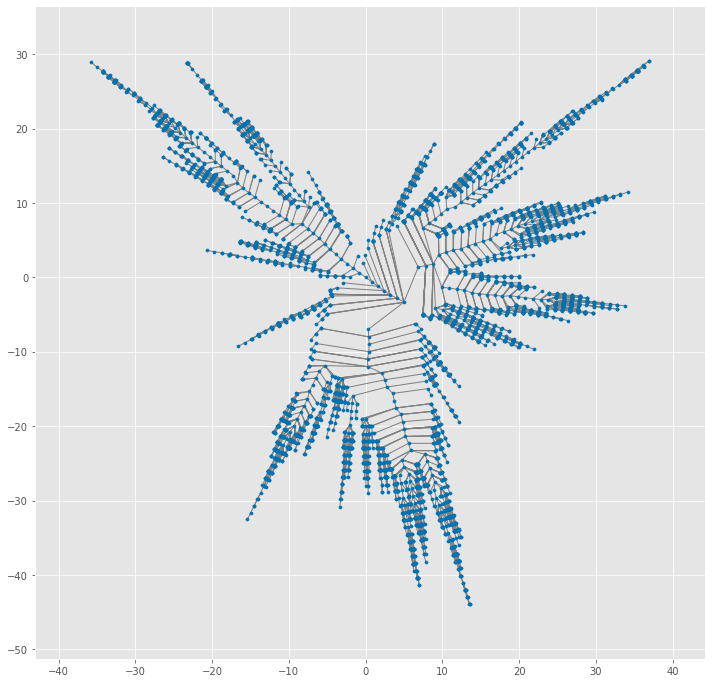

In [19]:
t0 = time()

# pos0 = nx.layout.planar_layout(g, scale=40)
# pos0 = graphviz_layout(g, prog="dot", root=list(g.nodes)[0])
# pos0 = graphviz_layout(g, prog='twopi')
pos0 = graphviz_layout(g, prog='sfdp')
pos = pos0.copy()
dt = time() - t0
print(f'{dt} sec')

# from scipy.spatial.distance import jensenshannon
# metric = []
# for i in range(len(nodes)):
#     s = subtree_sizes(g, i2k[i])
#     uniform = np.ones(len(s)) / len(s)
#     js = jensenshannon(s, uniform) 
#     metric.append(js)

## radial_layout
metric = d.max(axis=1)
iBest = np.argmin(metric)
# # iBest = np.argmax(metric)
pos = radial_layout(g, list(g.nodes)[iBest])


draw(g, pos, s=10, lw=1, labels=False, figsize=[12,12])
# draw(g, pos, s=10, lw=1, labels=True, figsize=[12,12])

## Best scaling

In [20]:
ideal_edge_length = {
    e: g.edges[e]['weight'] 
    for e in g.edges
}
actual_edge_length = {
    (p0,p1): np.linalg.norm(np.array(pos[p1])-np.array(pos[p0]))
    for (p0,p1) in g.edges
}
num = np.sum([ideal_edge_length[k]**2/actual_edge_length[k] for k in g.edges])
den = np.sum([ideal_edge_length[k] for k in g.edges])
s = num / den
print(f's = {s}')

pos = {k:np.array(v)*s for k,v in pos.items()}

s = 356.1014917068939


In [ ]:
# draw(g, pos,s=10, lw=1, labels=False, figsize=[36,36])

In [ ]:
# xy = np.array( [ pos[i2k[i]]for i in range(len(nodes)) ] )
# theta = (xy[:,0] - xy[:,0].min()) / (xy[:,0].max() - xy[:,0].min()) * np.pi*1
# r = (xy[:,1] - xy[:,1].min())
# # r = -(xy[:,1] - xy[:,1].max())

# xy2 = np.c_[r*np.cos(theta), r*np.sin(theta)]
# pos2 = {i2k[i]:xy2[i] for i in range(len(nodes))}
# draw(g, pos2)

# # pos = pos2

In [ ]:
# from umap import UMAP

# n_neighbors = 15

# umap = UMAP(
#     n_components=2,
#     n_neighbors=n_neighbors, 
#     min_dist=0.3,
#     metric='precomputed',
# #     n_epochs=500,
# #     negative_sample_rate=150,
# #     learning_rate=0.0001,
# #     init=np.array(list(pos.values()))
# )
# xy = umap.fit_transform(d)
# pos2 = {i2k[i]:xy[i,:2] for i in range(len(nodes))}


## New Ordering of Nodes

In [21]:
### list of node ids


# if ('math-genealogy' in fn 
#     or 'topics-800' in fn
#     or 'covid' in fn
#    ):
    
print('no re-ordering')
## no re-ordering
node_order = list(g.nodes)
## order preserving re-sort according to level
id2level = {i: g.nodes[i]['level'] for i in g.nodes}
nodeorder_level_pairs = [(i,id2level[i]) for i in node_order]
node_order = [n[0] for n in sorted(nodeorder_level_pairs, key=lambda x:x[1])]
bfs = nx.bfs_tree(g, node_order[0])
node_order = list(bfs) 

# else:
#     #max degree node
#     print('max degree node re-ordering')
#     degree = list(g.degree)
#     degree = list(zip(range(len(degree)), degree))
#     max_degree_node = max(degree, key=lambda x:x[1][1])
#     start = max_degree_node[1][0]
#     bfs = nx.bfs_tree(g, start)
#     node_order = list(bfs) 
    
# #     # random node, bfs
# #     start = next(iter(g.nodes.keys()))
# #     bfs = nx.bfs_tree(g, start)
# #     node_order = list(bfs) 

# #     #dfs
# #     node_order = list(nx.dfs_preorder_nodes(g, start))





no re-ordering


## Crossing removal

In [37]:
def isCrossed(e0, e1, pos=None):
    p0,p1 = e0
    q0,q1 = e1
    
    if p0 == q0 or p0 == q1 or p1==q0 or p1==q1: ##if two edges shares a node
        return False
    else:
        p0 = pos[p0]
        p1 = pos[p1]
        q0 = pos[q0]
        q1 = pos[q1]
        e0 = (pos[e0[0]],pos[e0[1]])
        e1 = (pos[e1[0]],pos[e1[1]])
        
        s00 = signOf(q0, e0)
        s10 = signOf(q1, e0)
        s01 = signOf(p0, e1)
        s11 = signOf(p1, e1)
        return s00*s10 <= 0 and s01*s11 <= 0 

    
def signOf(p, e):
    '''sign of point p with repect to the line of edge e'''
    px, py = p
    ax, ay = e[0]
    bx, by = e[1]
    
    a = ay - by
    b = bx - ax
    c = ay * (ax - bx) - ax * (ay - by)
    
    z = px*a + py*b + c
    return np.sign(z)


def subtreeSize(tree, node):
    subtree = nx.bfs_tree(tree, node)
    return len(subtree.nodes), subtree


def shrinkRotate(
    subtree=None, around=0, 
    scaleBy=0.5, rotateBy=np.pi/10, pos=None):

    ox, oy = pos[around]
    cos = np.cos(rotateBy)
    sin = np.sin(rotateBy)
    for k in subtree.nodes:
        x,y = pos[k]
        x,y = x-ox, y-oy
        x,y = x*scaleBy, y*scaleBy
        x,y = cos*x-sin*y, sin*x+cos*y
        x,y = x+ox, y+oy
        pos[k] = (x,y)

        
hasCrossing = False
c=1
while not hasCrossing:
    edges = edge_order[:c]
    for i,e0 in enumerate(edges):
        e1 = edges[-1]
        if isCrossed(e0, e1, pos):
            hasCrossing = True
    c += 1
c   

316

In [35]:
edge_order = []
for i,n in enumerate(tqdm(node_order)):
    m = node_order[i]
    for n in node_order[:i]:
        if (m,n) in g.edges:
            edge_order.append((m,n))
        if (n,m) in g.edges:
            edge_order.append((n,m))

## denaulay

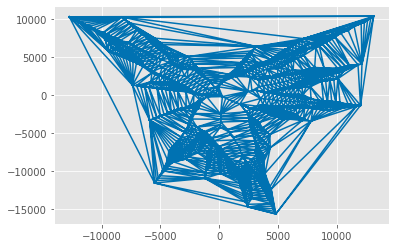

In [22]:
def simplex2edges(sim, points):
    res = dict()
    for t in sim:
        for i in range(3):
            a,b = t[i], t[(i+1)%3]
            if a > b:
                a,b = b,a
            res[(a,b)] = np.linalg.norm(points[a] - points[b])
    return res

points = np.array(list(pos[i] for i in node_order))
tri = Delaunay(points)
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.show()

denaulayDistance = simplex2edges(tri.simplices, points)

## to JSON

In [23]:
##graph to list
nodes = {k: g.nodes[k] for k in g.nodes}
edges = [[e[0], e[1], g.edges[e]] for e in g.edges]

nodes = [{
    'id': node_order[i],
    'index': 
    i,
    **nodes[node_order[i]]
} for i in range(len(nodes))]

edges = [{
    'source': e[0],
    'target': e[1],
    **e[2]
} for e in edges]

In [24]:
# ##store the position & perplexity
for i,node in enumerate(nodes):
    node['x'] = pos[node_order[i]][0]
    node['y'] = pos[node_order[i]][1]
    node['neighbors'] = list(nx.neighbors(g, node['id']))
#     node['x'] = node['pos'][0]
#     node['y'] = node['pos'][1]
    node['perplexity'] = len(list(nx.neighbors(g, node_order[i])))
    
    try: 
        parent = next(bfs.predecessors(node['id']))
    except StopIteration:
        parent = None
    node['parent'] = parent

    
virtual_edges = []
for i in tqdm(range(len(nodes))):
    for j in range(i+1, len(nodes)):
        if d[i,j] == 0:
            print(f'[warning] d[{i},{j}] = 0')
        else:
            if (i,j) in denaulayDistance:
                dij = d[i,j]
            elif hops[i,j] > 1 and hops[i,j] <= 5:
                dij = d[i,j]
            else:
                continue
            e = {
                'source': i2k[i],
                'target': i2k[j],
                'weight': dij,
                'hops': hops[i,j]
            }
            virtual_edges.append(e)
            
        
fn_out = fn.replace('dot', 'json').replace('txt', 'json')
print(fn_out)

if not Path(fn_out).parent.exists():
    os.makedirs(Path(fn_out).parent)
    
    
    
## option 1: nodes, edges, and virtualEdges with properties
# with open(fn_out, 'w') as f:
#     json.dump(dict(
#         edges = edges, 
#         virtual_edges = virtual_edges, 
#         nodes=nodes
#     ), f, indent=2)
# print('done')


## option 2: property arrays
nodeIds = [n['id'] for n in nodes]
nodeLabels = [n['label'] for n in nodes]
nodeLevels = [n['level'] for n in nodes]
nodeXs = [n['x'] for n in nodes]
nodeYs = [n['y'] for n in nodes]
nodePerplexities = [n['perplexity'] for n in nodes]
nodeParents = [n['parent'] for n in nodes]
nodeNeighbors = [n['neighbors'] for n in nodes]

edgeSources = [e['source'] for e in edges]
edgeTargets = [e['target'] for e in edges]
edgeLevels = [e['level'] for e in edges]
edgeWeights = [e['weight'] for e in edges]

virtualEdgeSources = [e['source'] for e in virtual_edges]
virtualEdgeTargets = [e['target'] for e in virtual_edges]
virtualEdgeWeights = [e['weight'] for e in virtual_edges]
virtualEdgeHops = [e['hops'] for e in virtual_edges]

with open(fn_out, 'w') as f:
    json.dump(dict(
        node_id=nodeIds, 
        node_label=nodeLabels, 
        node_level=nodeLevels,
        node_x=nodeXs,
        node_y=nodeYs,
        node_perplexity=nodePerplexities,
        node_parent=nodeParents,
        node_neighbors=nodeNeighbors,
        
        edge_source=edgeSources,
        edge_target=edgeTargets,
        edge_level=edgeLevels,
        edge_weight=edgeWeights,
        
        virtual_edge_source=virtualEdgeSources,
        virtual_edge_target=virtualEdgeTargets,
        virtual_edge_weight=virtualEdgeWeights,
        virtual_edge_hops=virtualEdgeHops,
        
    ), f, indent=2)
print('done')



./data/json/topics_faryad_5000/Graph_5000.json
done


In [ ]:
!mv ./data/json/topics_faryad_5000/Graph_50.json ./data/json/topics_faryad_5000/Graph_1200.json

In [ ]:
# ## contour of ellipse
# c = 2
# b = 1
# a = (b*b+c*c)**0.5

# x,y = np.meshgrid(
#     np.linspace(-5,5,101), 
#     np.linspace(-5,5,101)
# )

# z = x*x/(a*a) + y*y / (b*b)

# plt.contourf(z, levels=np.linspace(0.01,10,5))
# plt.axis('square')




In [ ]:
for n in nodes:
    n['id'] = n['index']
    del n['x']
    del n['y']

In [ ]:
## plot runtime
runtime = [{"count":0,"time":90143.04500003345},{"count":100,"time":149835.6250000652},{"count":200,"time":182153.8550000405},{"count":300,"time":207377.49500002246},{"count":400,"time":341016.79999998305},{"count":500,"time":380916.435000021},{"count":600,"time":438935.6899999548},{"count":700,"time":467613.99500002153},{"count":800,"time":501253.4450000385}]
x = np.array([r['count'] for r in runtime])
y = np.array([r['time'] for r in runtime])/1000/60

x = x[1:] - x[0]
y = y[1:]

plt.figure(figsize=[8,6])
plt.plot(x,y, 'o')
plt.ylim([0, plt.ylim()[1]])

plt.title('Topics graphs')
plt.xlabel('Number of nodes')
plt.ylabel('Time (minutes)')


